In [1]:
import centralized as CP
import davisyin as DY
import admm as admm
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
from numpy.linalg import inv
import matplotlib as plt
from matplotlib import rc
# Configura el tipo de letra globalmente
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman']})
rc('text', usetex=True)
#plt.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import proyecciones as pro
import time
import briceno as BA
import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [2]:
# Caso 1: Caso base
    
# Cambiar criterio de parada por errores relativos.
# Establecer la semilla
seed = 40
#41
np.random.seed(seed)

# Seteamos los parámetros:
N, M = 3, 6  # Son 2 tecnologías, 10 escenarios

_g_ = 1

# Probabilidades:
inv_, mc_, voll_, d_ = [50.0,  1000.0, 10000.0, 1000.0]
                       #[10.0, 2000.0, 10000.0, 1000.0]
                       #[50.0,  1000.0, 10000.0, 1000.0]
#Sigma = np.ones((1,M))
Sigma = np.random.rand(1,M)
Sigma /= Sigma.sum()
Sigma

array([[0.18, 0.02, 0.34, 0.13, 0.20, 0.13]])

In [3]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}".format(x)})
Times = {}
r_ = 1


# Parámetros funciones:
I    = (inv_ * np.ones((N, 1)) + r_*np.array([[-45], [0], [45]])) / _g_
print("I\n",I)
aux  = np.array([1/ _g_ + r_*20*i/ _g_ for i in range(N)])

mc_11 = 100
mc_22 = 500
mc_33 = 1000
MC   = (np.array([np.diag(mc_*aux/_g_ + r_*np.array([((-1)**m)*mc_11*m/_g_, ((-1)**m)*mc_22*m/_g_, ((-1)**(m+1))*mc_33*m/_g_]))/ _g_ for m in range(M)])) 
MC[-1]=(np.array([[1,0,0],[0,1,0],[0,0,1]])*88000) / _g_
print("MC\n",MC)

MC_pyomo = np.array([mc_*aux + r_*np.array([((-1)**m)*mc_11*m, ((-1)**m)*mc_22*m, ((-1)**(m+1))*mc_33*m]) for m in range(M)]).T.tolist()
for i in range(N):
    MC_pyomo[i][-1] = MC[-1][i][i]
MC_pyomo

VOLL = voll_ / _g_
print("VOLL\n",VOLL)
D    = (d_*np.ones((1,M)) + r_*np.array([-800, -250, 0, 250, 500, 3000])[np.newaxis])/ _g_
print("D\n",D)

e_ = 0

e1  = e_
e2  = e_
e31 = e_*1e2/2
e32 = e_

Q1, B1 = np.zeros((N,N)), I
Q2, B2 = 0.01*MC, np.zeros((N,M))
Q3, B3 = np.zeros((1,M)), VOLL*np.ones((1,M))


frobenius_norm = (e1+e2)*np.sqrt(N)+e31+e32+np.array([LA.norm(np.einsum('i,ikl->ikl',Sigma[0],0.01*MC)[xi], 'fro') for xi in range(M)]).sum()
#frobenius_norm = max([e1*np.sqrt(N),e31+e32,e2*np.sqrt(N)+np.array([LA.norm(np.einsum('i,ikl->ikl',Sigma[0],0.01*MC)[xi], 'fro') for xi in range(M)]).sum()])
print("frobenius_norm:",frobenius_norm)

def Grad_Phi_1(x1, Q_1 = np.zeros((N,N)), B_1 = I, e1 = e1, N = N):
       return np.dot(Q_1,x1)+B_1# - e1*np.dot(np.identity(N),np.maximum(-x1,0))


def Grad_Phi_2(x2, Q_2 = 0.01*MC, B_2 = np.zeros((N,M)), e2 = e2, N = N, M = M):

    return np.einsum('ijk,ki->ji', Q_2, x2)+B_2# - e2*np.einsum('ijk,ki->ji', np.array([np.diag(np.ones(N)) for m in range(M)]), np.maximum(-x2,0))


def Grad_Phi_3(x3, Q_3 = np.zeros((1,M)), B_3 = VOLL*np.ones((1,M)), D=D, e31=e31, e32= e32, M = M):
    return Q_3*x3+B_3 #- e31*np.dot(np.maximum(-x3,0),np.identity(M)) - e32*np.dot(np.maximum(-D+x3,0),np.identity(M))


def Grad_Phi(x1,x2,x3, P = Sigma):
    return Grad_Phi_1(x1), P*Grad_Phi_2(x2), P*Grad_Phi_3(x3)

def Grad_Phi_NA(x1,x2,x3, P = Sigma):
    return P*Grad_Phi_1(x1), P*Grad_Phi_2(x2), P*Grad_Phi_3(x3)

def Phi_1(x1, Q_1 = np.zeros((N,N)), B_1 = I, C_1 = 0.0, e1 = e1):
    return 0.5*np.einsum('ij,ji -> i', x1.T,np.dot(Q_1,x1))[:,np.newaxis]+np.dot(x1.T, B_1)+C_1 + e1/2*LA.norm(np.maximum(-x1.flatten(),0))**2

def Phi_2_xi(x2, Q_2 = 0.01*MC, B_2 = np.zeros((N,M)), C_2 = np.zeros((M, 1))):
    return 0.5*np.einsum('ij,ji -> i', x2.T, np.einsum('ijk,ki -> ji', Q_2, x2))[:,np.newaxis]+np.einsum('ij,ji->i',x2.T,B_2)[:,np.newaxis]+C_2 + e2/2*LA.norm(np.maximum(-x2.flatten(),0))**2

def Phi_3_xi(x3, Q_3 = np.zeros((1,M)), B_3 = VOLL*np.ones((1,M)), C_3 = -VOLL*D ):
    return (0.5*x3*Q_3*x3+B_3*x3+C_3).T + e31/2*LA.norm(np.maximum(-x3.flatten(),0))**2 + e32/2*LA.norm(np.maximum((D-x3).flatten(),0))**2


def objective_function(x1, x2, x3, P = Sigma, NA = True):

# NA = True, cumple la funcion que si se impuso 
#      la condición de no anticipatividad para x1
#      entonces, Phi_1(x1).shape == (M,1)
    if NA:
        return np.dot(P, Phi_1(x1) +Phi_2_xi(x2)+Phi_3_xi(x3))
    else:
        return Phi_1(x1)+ np.dot(P, Phi_2_xi(x2)+Phi_3_xi(x3))

I
 [[5.0]
 [50.0]
 [95.0]]
MC
 [[[1000.0 0.0 0.0]
  [0.0 21000.0 0.0]
  [0.0 0.0 41000.0]]

 [[900.0 0.0 0.0]
  [0.0 20500.0 0.0]
  [0.0 0.0 42000.0]]

 [[1200.0 0.0 0.0]
  [0.0 22000.0 0.0]
  [0.0 0.0 39000.0]]

 [[700.0 0.0 0.0]
  [0.0 19500.0 0.0]
  [0.0 0.0 44000.0]]

 [[1400.0 0.0 0.0]
  [0.0 23000.0 0.0]
  [0.0 0.0 37000.0]]

 [[88000.0 0.0 0.0]
  [0.0 88000.0 0.0]
  [0.0 0.0 88000.0]]]
VOLL
 10000.0
D
 [[200.0 750.0 1000.0 1250.0 1500.0 4000.0]]
frobenius_norm: 595.1406870090601


In [4]:
cp = time.time()
x1, x2, x3, rho, mu = map(np.array, CP.modelo(Sigma, N, M, \
                                              parametros = [I.T[0].tolist(),\
                                                            MC_pyomo,\
                                                            VOLL,\
                                                            D[0]] , show = 0))
fin = time.time()


Times["CP"] = fin - cp

x1 = x1[:,np.newaxis]
x2 = x2.T
x3 = x3[np.newaxis,:][0]
rho = rho[np.newaxis]

In [5]:
print(f"primal:\n{x1}\n{x2}\n{x3}")
print(f"Dual:\n{mu}\n{rho}")

primal:
[[1188.2]
 [44.8]
 [25.7]]
[[186.6 704.0 833.3 1188.2 714.3 11.4]
 [8.9 30.9 44.8 42.9 43.5 11.4]
 [4.6 15.1 25.6 19.0 25.7 11.4]]
[[0.0 0.0 96.2 0.0 716.5 3965.9]]
Dual:
[[0.0 0.0 0.0 39.9 0.0 0.0]
 [0.0 0.0 145.4 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 483.7 0.0]]
[[1865.7 6336.1 10000.0 8357.0 10000.0 10000.0]]


In [6]:
# DY
    
dy = time.time()
DY_list, DY_f_list, DY_z_list, Dual_DY_list, iterations_DY   = DY.Davis_Yin(N, M, frobenius_norm, Grad_Phi, D, (x1,x2,x3), Sigma)
fin = time.time()

Times["DY"] = fin - dy

Beta: 0.0016802749699833185
Gamma: 0.0031218162324379273
Lambda_k: 1
Iteration: 1 lambda_k: 1 Loss: 0.8310352033297772
Iteration: 2 lambda_k: 1 Loss: 0.7073862252784012
Iteration: 3 lambda_k: 1 Loss: 0.6279999442373778
Iteration: 4 lambda_k: 1 Loss: 0.5762411807069783
Iteration: 5 lambda_k: 1 Loss: 0.5498784584975096
Iteration: 6 lambda_k: 1 Loss: 0.5316815468733749
Iteration: 7 lambda_k: 1 Loss: 0.516868498733118
Iteration: 8 lambda_k: 1 Loss: 0.5073995894005161
Iteration: 9 lambda_k: 1 Loss: 0.5011011760404228
Iteration: 10 lambda_k: 1 Loss: 0.4965083676440122
Iteration: 11 lambda_k: 1 Loss: 0.4930361585580605
Iteration: 12 lambda_k: 1 Loss: 0.4904892272916616
Iteration: 13 lambda_k: 1 Loss: 0.48840373734393955
Iteration: 14 lambda_k: 1 Loss: 0.48644188250347625
Iteration: 15 lambda_k: 1 Loss: 0.48458791134431356
Iteration: 16 lambda_k: 1 Loss: 0.4828285908045649
Iteration: 17 lambda_k: 1 Loss: 0.4812012873159904
Iteration: 18 lambda_k: 1 Loss: 0.4797652028790013
Iteration: 19 lambda

Iteration: 159 lambda_k: 1 Loss: 0.3895692433689621
Iteration: 160 lambda_k: 1 Loss: 0.38909659490348875
Iteration: 161 lambda_k: 1 Loss: 0.3886250451414834
Iteration: 162 lambda_k: 1 Loss: 0.3881545904409313
Iteration: 163 lambda_k: 1 Loss: 0.3876852271876959
Iteration: 164 lambda_k: 1 Loss: 0.3872169517945448
Iteration: 165 lambda_k: 1 Loss: 0.38674976070023004
Iteration: 166 lambda_k: 1 Loss: 0.38628365036861767
Iteration: 167 lambda_k: 1 Loss: 0.38581861728786476
Iteration: 168 lambda_k: 1 Loss: 0.3853546579696416
Iteration: 169 lambda_k: 1 Loss: 0.3848917689483953
Iteration: 170 lambda_k: 1 Loss: 0.38442994678065373
Iteration: 171 lambda_k: 1 Loss: 0.3839691880443666
Iteration: 172 lambda_k: 1 Loss: 0.3835094893382817
Iteration: 173 lambda_k: 1 Loss: 0.38305084728135563
Iteration: 174 lambda_k: 1 Loss: 0.382593258512194
Iteration: 175 lambda_k: 1 Loss: 0.3821367196885231
Iteration: 176 lambda_k: 1 Loss: 0.381681227486689
Iteration: 177 lambda_k: 1 Loss: 0.38122677860118254
Iterati

Iteration: 316 lambda_k: 1 Loss: 0.32689848787179737
Iteration: 317 lambda_k: 1 Loss: 0.32656293230356304
Iteration: 318 lambda_k: 1 Loss: 0.32622806186299524
Iteration: 319 lambda_k: 1 Loss: 0.3258938745797155
Iteration: 320 lambda_k: 1 Loss: 0.3255603684898853
Iteration: 321 lambda_k: 1 Loss: 0.3252275416332716
Iteration: 322 lambda_k: 1 Loss: 0.3248953920638625
Iteration: 323 lambda_k: 1 Loss: 0.32456391783573846
Iteration: 324 lambda_k: 1 Loss: 0.3242331170107218
Iteration: 325 lambda_k: 1 Loss: 0.3239029876571997
Iteration: 326 lambda_k: 1 Loss: 0.32357352785012705
Iteration: 327 lambda_k: 1 Loss: 0.32324473567082124
Iteration: 328 lambda_k: 1 Loss: 0.32291660920692367
Iteration: 329 lambda_k: 1 Loss: 0.32258914655239906
Iteration: 330 lambda_k: 1 Loss: 0.3222623458075228
Iteration: 331 lambda_k: 1 Loss: 0.3219362050788585
Iteration: 332 lambda_k: 1 Loss: 0.3216107224792345
Iteration: 333 lambda_k: 1 Loss: 0.3212858961277205
Iteration: 334 lambda_k: 1 Loss: 0.32096172414960533
Ite

Iteration: 473 lambda_k: 1 Loss: 0.28150315127732217
Iteration: 474 lambda_k: 1 Loss: 0.2812546631143513
Iteration: 475 lambda_k: 1 Loss: 0.28100661806467253
Iteration: 476 lambda_k: 1 Loss: 0.28075901494995764
Iteration: 477 lambda_k: 1 Loss: 0.28051185259569517
Iteration: 478 lambda_k: 1 Loss: 0.2802651298311784
Iteration: 479 lambda_k: 1 Loss: 0.28001884548949224
Iteration: 480 lambda_k: 1 Loss: 0.27977299840750103
Iteration: 481 lambda_k: 1 Loss: 0.2795275874258363
Iteration: 482 lambda_k: 1 Loss: 0.27928261138888383
Iteration: 483 lambda_k: 1 Loss: 0.279038069144772
Iteration: 484 lambda_k: 1 Loss: 0.2787939595453591
Iteration: 485 lambda_k: 1 Loss: 0.27855028144622096
Iteration: 486 lambda_k: 1 Loss: 0.2783070337066392
Iteration: 487 lambda_k: 1 Loss: 0.27806421518958846
Iteration: 488 lambda_k: 1 Loss: 0.27782182476172507
Iteration: 489 lambda_k: 1 Loss: 0.27757986129337425
Iteration: 490 lambda_k: 1 Loss: 0.27733832365851846
Iteration: 491 lambda_k: 1 Loss: 0.27709721073478544


Iteration: 630 lambda_k: 1 Loss: 0.24725574245952506
Iteration: 631 lambda_k: 1 Loss: 0.24706453314933136
Iteration: 632 lambda_k: 1 Loss: 0.24687362173782598
Iteration: 633 lambda_k: 1 Loss: 0.24668300751705435
Iteration: 634 lambda_k: 1 Loss: 0.24649268978136682
Iteration: 635 lambda_k: 1 Loss: 0.24630266782741161
Iteration: 636 lambda_k: 1 Loss: 0.24611294095412764
Iteration: 637 lambda_k: 1 Loss: 0.24592350846273733
Iteration: 638 lambda_k: 1 Loss: 0.2457343696567399
Iteration: 639 lambda_k: 1 Loss: 0.2455455238419038
Iteration: 640 lambda_k: 1 Loss: 0.2453569703262602
Iteration: 641 lambda_k: 1 Loss: 0.24516870842009544
Iteration: 642 lambda_k: 1 Loss: 0.2449807374359448
Iteration: 643 lambda_k: 1 Loss: 0.24479305668858503
Iteration: 644 lambda_k: 1 Loss: 0.24460566549502757
Iteration: 645 lambda_k: 1 Loss: 0.24441856317451222
Iteration: 646 lambda_k: 1 Loss: 0.2442317490484995
Iteration: 647 lambda_k: 1 Loss: 0.24404522244066487
Iteration: 648 lambda_k: 1 Loss: 0.2438589826768915

Iteration: 786 lambda_k: 1 Loss: 0.22068160364559836
Iteration: 787 lambda_k: 1 Loss: 0.22053022502560013
Iteration: 788 lambda_k: 1 Loss: 0.2203790429440606
Iteration: 789 lambda_k: 1 Loss: 0.2202280564251165
Iteration: 790 lambda_k: 1 Loss: 0.22007726449940915
Iteration: 791 lambda_k: 1 Loss: 0.21992666620403617
Iteration: 792 lambda_k: 1 Loss: 0.21977626058250443
Iteration: 793 lambda_k: 1 Loss: 0.21962604668468316
Iteration: 794 lambda_k: 1 Loss: 0.2194760235667576
Iteration: 795 lambda_k: 1 Loss: 0.21932619029118375
Iteration: 796 lambda_k: 1 Loss: 0.2191765459266427
Iteration: 797 lambda_k: 1 Loss: 0.21902708954799666
Iteration: 798 lambda_k: 1 Loss: 0.2188778202362447
Iteration: 799 lambda_k: 1 Loss: 0.21872873707847934
Iteration: 800 lambda_k: 1 Loss: 0.21857983916784338
Iteration: 801 lambda_k: 1 Loss: 0.21843112560348768
Iteration: 802 lambda_k: 1 Loss: 0.21828259549052897
Iteration: 803 lambda_k: 1 Loss: 0.21813424794000805
Iteration: 804 lambda_k: 1 Loss: 0.2179860820688491

Iteration: 942 lambda_k: 1 Loss: 0.1989642653518519
Iteration: 943 lambda_k: 1 Loss: 0.19883492658500698
Iteration: 944 lambda_k: 1 Loss: 0.19870568958332901
Iteration: 945 lambda_k: 1 Loss: 0.19857655400967195
Iteration: 946 lambda_k: 1 Loss: 0.19844751952933848
Iteration: 947 lambda_k: 1 Loss: 0.19831858581006606
Iteration: 948 lambda_k: 1 Loss: 0.19818975252201254
Iteration: 949 lambda_k: 1 Loss: 0.1980610193377423
Iteration: 950 lambda_k: 1 Loss: 0.19793238593221207
Iteration: 951 lambda_k: 1 Loss: 0.19780385198275757
Iteration: 952 lambda_k: 1 Loss: 0.19767541716907888
Iteration: 953 lambda_k: 1 Loss: 0.19754708117322747
Iteration: 954 lambda_k: 1 Loss: 0.1974188436795925
Iteration: 955 lambda_k: 1 Loss: 0.19729070437488683
Iteration: 956 lambda_k: 1 Loss: 0.19716266294813414
Iteration: 957 lambda_k: 1 Loss: 0.1970347190906552
Iteration: 958 lambda_k: 1 Loss: 0.19690687249605493
Iteration: 959 lambda_k: 1 Loss: 0.19677912286020874
Iteration: 960 lambda_k: 1 Loss: 0.196651469881250

Iteration: 1096 lambda_k: 1 Loss: 0.18009063592884086
Iteration: 1097 lambda_k: 1 Loss: 0.1799741904531618
Iteration: 1098 lambda_k: 1 Loss: 0.17985781686750474
Iteration: 1099 lambda_k: 1 Loss: 0.17974151508692196
Iteration: 1100 lambda_k: 1 Loss: 0.1796252850275035
Iteration: 1101 lambda_k: 1 Loss: 0.1795091266063716
Iteration: 1102 lambda_k: 1 Loss: 0.17939303974167536
Iteration: 1103 lambda_k: 1 Loss: 0.17927702435258516
Iteration: 1104 lambda_k: 1 Loss: 0.17916108035928727
Iteration: 1105 lambda_k: 1 Loss: 0.1790452076829783
Iteration: 1106 lambda_k: 1 Loss: 0.17892940624586015
Iteration: 1107 lambda_k: 1 Loss: 0.17881367597113446
Iteration: 1108 lambda_k: 1 Loss: 0.17869801678299727
Iteration: 1109 lambda_k: 1 Loss: 0.1785824286066338
Iteration: 1110 lambda_k: 1 Loss: 0.17846691136821322
Iteration: 1111 lambda_k: 1 Loss: 0.17835146499488344
Iteration: 1112 lambda_k: 1 Loss: 0.1782360894147659
Iteration: 1113 lambda_k: 1 Loss: 0.17812078455695032
Iteration: 1114 lambda_k: 1 Loss: 

Iteration: 1249 lambda_k: 1 Loss: 0.16309971393086473
Iteration: 1250 lambda_k: 1 Loss: 0.16299441177338758
Iteration: 1251 lambda_k: 1 Loss: 0.16288917531302055
Iteration: 1252 lambda_k: 1 Loss: 0.16278400458593378
Iteration: 1253 lambda_k: 1 Loss: 0.16267889962874868
Iteration: 1254 lambda_k: 1 Loss: 0.1625738604785364
Iteration: 1255 lambda_k: 1 Loss: 0.16246888717281682
Iteration: 1256 lambda_k: 1 Loss: 0.16236397974955705
Iteration: 1257 lambda_k: 1 Loss: 0.16225913824717028
Iteration: 1258 lambda_k: 1 Loss: 0.1621543627045147
Iteration: 1259 lambda_k: 1 Loss: 0.16204965316089204
Iteration: 1260 lambda_k: 1 Loss: 0.1619450096560466
Iteration: 1261 lambda_k: 1 Loss: 0.16184043223016414
Iteration: 1262 lambda_k: 1 Loss: 0.16173592092387076
Iteration: 1263 lambda_k: 1 Loss: 0.16163147577823164
Iteration: 1264 lambda_k: 1 Loss: 0.16152709683475033
Iteration: 1265 lambda_k: 1 Loss: 0.16142278413536734
Iteration: 1266 lambda_k: 1 Loss: 0.1613185377224595
Iteration: 1267 lambda_k: 1 Loss

Iteration: 1402 lambda_k: 1 Loss: 0.14785590716000555
Iteration: 1403 lambda_k: 1 Loss: 0.14776181152712775
Iteration: 1404 lambda_k: 1 Loss: 0.14766778895525826
Iteration: 1405 lambda_k: 1 Loss: 0.14757383956278292
Iteration: 1406 lambda_k: 1 Loss: 0.1474799634685276
Iteration: 1407 lambda_k: 1 Loss: 0.14738616079159902
Iteration: 1408 lambda_k: 1 Loss: 0.14729243165133923
Iteration: 1409 lambda_k: 1 Loss: 0.14719877616733834
Iteration: 1410 lambda_k: 1 Loss: 0.14710519445944914
Iteration: 1411 lambda_k: 1 Loss: 0.14701168664779074
Iteration: 1412 lambda_k: 1 Loss: 0.14691825285274687
Iteration: 1413 lambda_k: 1 Loss: 0.1468248931949645
Iteration: 1414 lambda_k: 1 Loss: 0.14673160779535344
Iteration: 1415 lambda_k: 1 Loss: 0.1466383967750863
Iteration: 1416 lambda_k: 1 Loss: 0.14654526026231957
Iteration: 1417 lambda_k: 1 Loss: 0.14645219836832032
Iteration: 1418 lambda_k: 1 Loss: 0.14635921121649534
Iteration: 1419 lambda_k: 1 Loss: 0.14626629893083418
Iteration: 1420 lambda_k: 1 Los

Iteration: 1555 lambda_k: 1 Loss: 0.13438384043643398
Iteration: 1556 lambda_k: 1 Loss: 0.13430244996793517
Iteration: 1557 lambda_k: 1 Loss: 0.1342211535803805
Iteration: 1558 lambda_k: 1 Loss: 0.1341399514282852
Iteration: 1559 lambda_k: 1 Loss: 0.13405884366635637
Iteration: 1560 lambda_k: 1 Loss: 0.13397783044949266
Iteration: 1561 lambda_k: 1 Loss: 0.1338969119350687
Iteration: 1562 lambda_k: 1 Loss: 0.13381608827465385
Iteration: 1563 lambda_k: 1 Loss: 0.1337353596250781
Iteration: 1564 lambda_k: 1 Loss: 0.13365472614190838
Iteration: 1565 lambda_k: 1 Loss: 0.13357418798115225
Iteration: 1566 lambda_k: 1 Loss: 0.1334937452988265
Iteration: 1567 lambda_k: 1 Loss: 0.13341339825111534
Iteration: 1568 lambda_k: 1 Loss: 0.1333331469944172
Iteration: 1569 lambda_k: 1 Loss: 0.13325299168533206
Iteration: 1570 lambda_k: 1 Loss: 0.13317293248064602
Iteration: 1571 lambda_k: 1 Loss: 0.13309296953732708
Iteration: 1572 lambda_k: 1 Loss: 0.1330131030125259
Iteration: 1573 lambda_k: 1 Loss: 0

Iteration: 1708 lambda_k: 1 Loss: 0.12264213585179018
Iteration: 1709 lambda_k: 1 Loss: 0.12256722578322979
Iteration: 1710 lambda_k: 1 Loss: 0.12249233024114788
Iteration: 1711 lambda_k: 1 Loss: 0.12241744927087614
Iteration: 1712 lambda_k: 1 Loss: 0.12234258291153383
Iteration: 1713 lambda_k: 1 Loss: 0.12226773120448739
Iteration: 1714 lambda_k: 1 Loss: 0.12219289419219766
Iteration: 1715 lambda_k: 1 Loss: 0.1221180719156911
Iteration: 1716 lambda_k: 1 Loss: 0.12204326441525658
Iteration: 1717 lambda_k: 1 Loss: 0.12196847173099501
Iteration: 1718 lambda_k: 1 Loss: 0.12189369390294824
Iteration: 1719 lambda_k: 1 Loss: 0.12181893097111518
Iteration: 1720 lambda_k: 1 Loss: 0.1217441829754996
Iteration: 1721 lambda_k: 1 Loss: 0.12166944995618323
Iteration: 1722 lambda_k: 1 Loss: 0.12159473195339701
Iteration: 1723 lambda_k: 1 Loss: 0.12152002900758382
Iteration: 1724 lambda_k: 1 Loss: 0.12144534115945545
Iteration: 1725 lambda_k: 1 Loss: 0.12137066845004674
Iteration: 1726 lambda_k: 1 Lo

Iteration: 1861 lambda_k: 1 Loss: 0.1114874816482368
Iteration: 1862 lambda_k: 1 Loss: 0.11141634913022813
Iteration: 1863 lambda_k: 1 Loss: 0.11134523354395595
Iteration: 1864 lambda_k: 1 Loss: 0.11127413487813526
Iteration: 1865 lambda_k: 1 Loss: 0.11120305312167268
Iteration: 1866 lambda_k: 1 Loss: 0.11113198826366472
Iteration: 1867 lambda_k: 1 Loss: 0.11106094029339572
Iteration: 1868 lambda_k: 1 Loss: 0.11098990920033633
Iteration: 1869 lambda_k: 1 Loss: 0.11091889497414166
Iteration: 1870 lambda_k: 1 Loss: 0.1108478976046493
Iteration: 1871 lambda_k: 1 Loss: 0.11077691708187815
Iteration: 1872 lambda_k: 1 Loss: 0.11070595339602625
Iteration: 1873 lambda_k: 1 Loss: 0.11063500653746965
Iteration: 1874 lambda_k: 1 Loss: 0.11056407649676046
Iteration: 1875 lambda_k: 1 Loss: 0.11049316326462556
Iteration: 1876 lambda_k: 1 Loss: 0.11042226683196495
Iteration: 1877 lambda_k: 1 Loss: 0.11035138718985041
Iteration: 1878 lambda_k: 1 Loss: 0.11028052432952397
Iteration: 1879 lambda_k: 1 Lo

Iteration: 2014 lambda_k: 1 Loss: 0.10079787830817485
Iteration: 2015 lambda_k: 1 Loss: 0.10072929178787973
Iteration: 2016 lambda_k: 1 Loss: 0.10066072208172717
Iteration: 2017 lambda_k: 1 Loss: 0.10059216919712549
Iteration: 2018 lambda_k: 1 Loss: 0.1005236331415693
Iteration: 2019 lambda_k: 1 Loss: 0.10045511392263932
Iteration: 2020 lambda_k: 1 Loss: 0.10038661154800202
Iteration: 2021 lambda_k: 1 Loss: 0.10031812602540965
Iteration: 2022 lambda_k: 1 Loss: 0.10024965736269974
Iteration: 2023 lambda_k: 1 Loss: 0.10018120556779514
Iteration: 2024 lambda_k: 1 Loss: 0.10011277064870358
Iteration: 2025 lambda_k: 1 Loss: 0.10004435261351781
Iteration: 2026 lambda_k: 1 Loss: 0.0999759514704149
Iteration: 2027 lambda_k: 1 Loss: 0.09990756722765647
Iteration: 2028 lambda_k: 1 Loss: 0.09983919989358835
Iteration: 2029 lambda_k: 1 Loss: 0.09977084947664029
Iteration: 2030 lambda_k: 1 Loss: 0.09970251598532597
Iteration: 2031 lambda_k: 1 Loss: 0.0996341994282426
Iteration: 2032 lambda_k: 1 Los

Iteration: 2167 lambda_k: 1 Loss: 0.09050578270436041
Iteration: 2168 lambda_k: 1 Loss: 0.09043990221759493
Iteration: 2169 lambda_k: 1 Loss: 0.09037404060736715
Iteration: 2170 lambda_k: 1 Loss: 0.09030819789313216
Iteration: 2171 lambda_k: 1 Loss: 0.09024237409442395
Iteration: 2172 lambda_k: 1 Loss: 0.09017656923085575
Iteration: 2173 lambda_k: 1 Loss: 0.09011078332211982
Iteration: 2174 lambda_k: 1 Loss: 0.09004501638798779
Iteration: 2175 lambda_k: 1 Loss: 0.08997926844831063
Iteration: 2176 lambda_k: 1 Loss: 0.08991353952301875
Iteration: 2177 lambda_k: 1 Loss: 0.08984782963212216
Iteration: 2178 lambda_k: 1 Loss: 0.08978213879571058
Iteration: 2179 lambda_k: 1 Loss: 0.08971646703395335
Iteration: 2180 lambda_k: 1 Loss: 0.08965081436709982
Iteration: 2181 lambda_k: 1 Loss: 0.0895851808154792
Iteration: 2182 lambda_k: 1 Loss: 0.08951956639950089
Iteration: 2183 lambda_k: 1 Loss: 0.08945397113965428
Iteration: 2184 lambda_k: 1 Loss: 0.08938839505650922
Iteration: 2185 lambda_k: 1 L

Iteration: 2319 lambda_k: 1 Loss: 0.08072150607087444
Iteration: 2320 lambda_k: 1 Loss: 0.08065876620337553
Iteration: 2321 lambda_k: 1 Loss: 0.0805960491567145
Iteration: 2322 lambda_k: 1 Loss: 0.08053335496415012
Iteration: 2323 lambda_k: 1 Loss: 0.08047068365904884
Iteration: 2324 lambda_k: 1 Loss: 0.0804080352748849
Iteration: 2325 lambda_k: 1 Loss: 0.08034540984524072
Iteration: 2326 lambda_k: 1 Loss: 0.0802828074038071
Iteration: 2327 lambda_k: 1 Loss: 0.0802202279843836
Iteration: 2328 lambda_k: 1 Loss: 0.08015767162087868
Iteration: 2329 lambda_k: 1 Loss: 0.08009513834731022
Iteration: 2330 lambda_k: 1 Loss: 0.08003262819780557
Iteration: 2331 lambda_k: 1 Loss: 0.07997014120660194
Iteration: 2332 lambda_k: 1 Loss: 0.07990767740804672
Iteration: 2333 lambda_k: 1 Loss: 0.0798452368365976
Iteration: 2334 lambda_k: 1 Loss: 0.07978281952682315
Iteration: 2335 lambda_k: 1 Loss: 0.07972042551340285
Iteration: 2336 lambda_k: 1 Loss: 0.07965805483112752
Iteration: 2337 lambda_k: 1 Loss:

Iteration: 2472 lambda_k: 1 Loss: 0.0714096947872833
Iteration: 2473 lambda_k: 1 Loss: 0.07135090307370572
Iteration: 2474 lambda_k: 1 Loss: 0.07129214070853336
Iteration: 2475 lambda_k: 1 Loss: 0.07123340774537928
Iteration: 2476 lambda_k: 1 Loss: 0.07117470423801935
Iteration: 2477 lambda_k: 1 Loss: 0.07111603024039265
Iteration: 2478 lambda_k: 1 Loss: 0.07105738580660215
Iteration: 2479 lambda_k: 1 Loss: 0.070998770990915
Iteration: 2480 lambda_k: 1 Loss: 0.07094018584776295
Iteration: 2481 lambda_k: 1 Loss: 0.0708816304317427
Iteration: 2482 lambda_k: 1 Loss: 0.07082310479761653
Iteration: 2483 lambda_k: 1 Loss: 0.07076460900031267
Iteration: 2484 lambda_k: 1 Loss: 0.07070614309492565
Iteration: 2485 lambda_k: 1 Loss: 0.07064770713671693
Iteration: 2486 lambda_k: 1 Loss: 0.07058930118111517
Iteration: 2487 lambda_k: 1 Loss: 0.07053092528371668
Iteration: 2488 lambda_k: 1 Loss: 0.07047257950028604
Iteration: 2489 lambda_k: 1 Loss: 0.07041426388675634
Iteration: 2490 lambda_k: 1 Loss

Iteration: 2625 lambda_k: 1 Loss: 0.06279107331469043
Iteration: 2626 lambda_k: 1 Loss: 0.06273750056463241
Iteration: 2627 lambda_k: 1 Loss: 0.0626839675254827
Iteration: 2628 lambda_k: 1 Loss: 0.06263047428107668
Iteration: 2629 lambda_k: 1 Loss: 0.0625770209154821
Iteration: 2630 lambda_k: 1 Loss: 0.0625236075129993
Iteration: 2631 lambda_k: 1 Loss: 0.06247023415816177
Iteration: 2632 lambda_k: 1 Loss: 0.06241690093573635
Iteration: 2633 lambda_k: 1 Loss: 0.062363607930723895
Iteration: 2634 lambda_k: 1 Loss: 0.062310355228359475
Iteration: 2635 lambda_k: 1 Loss: 0.062257142914112905
Iteration: 2636 lambda_k: 1 Loss: 0.06220397107368906
Iteration: 2637 lambda_k: 1 Loss: 0.062150839818514894
Iteration: 2638 lambda_k: 1 Loss: 0.062097749188829474
Iteration: 2639 lambda_k: 1 Loss: 0.06204469928257466
Iteration: 2640 lambda_k: 1 Loss: 0.06199169018500002
Iteration: 2641 lambda_k: 1 Loss: 0.06193872200343199
Iteration: 2642 lambda_k: 1 Loss: 0.061885794818435785
Iteration: 2643 lambda_k:

Iteration: 2777 lambda_k: 1 Loss: 0.05515702660621541
Iteration: 2778 lambda_k: 1 Loss: 0.05511059233458567
Iteration: 2779 lambda_k: 1 Loss: 0.055064213354892484
Iteration: 2780 lambda_k: 1 Loss: 0.05501788980109634
Iteration: 2781 lambda_k: 1 Loss: 0.05497162177389807
Iteration: 2782 lambda_k: 1 Loss: 0.05492540940032213
Iteration: 2783 lambda_k: 1 Loss: 0.054879252807866805
Iteration: 2784 lambda_k: 1 Loss: 0.054833152120768267
Iteration: 2785 lambda_k: 1 Loss: 0.054787107461756426
Iteration: 2786 lambda_k: 1 Loss: 0.054741118953906674
Iteration: 2787 lambda_k: 1 Loss: 0.05469518672087028
Iteration: 2788 lambda_k: 1 Loss: 0.05464931088663652
Iteration: 2789 lambda_k: 1 Loss: 0.05460349157541602
Iteration: 2790 lambda_k: 1 Loss: 0.05455772891164308
Iteration: 2791 lambda_k: 1 Loss: 0.054512023019995776
Iteration: 2792 lambda_k: 1 Loss: 0.054466374025401304
Iteration: 2793 lambda_k: 1 Loss: 0.05442078205303378
Iteration: 2794 lambda_k: 1 Loss: 0.05437524722831195
Iteration: 2795 lambd

Iteration: 2929 lambda_k: 1 Loss: 0.04880964669485737
Iteration: 2930 lambda_k: 1 Loss: 0.048773089379629535
Iteration: 2931 lambda_k: 1 Loss: 0.04873658695594341
Iteration: 2932 lambda_k: 1 Loss: 0.04870013856858581
Iteration: 2933 lambda_k: 1 Loss: 0.04866374337447376
Iteration: 2934 lambda_k: 1 Loss: 0.048627400540841526
Iteration: 2935 lambda_k: 1 Loss: 0.04859110924781335
Iteration: 2936 lambda_k: 1 Loss: 0.048554868691495556
Iteration: 2937 lambda_k: 1 Loss: 0.04851867808622789
Iteration: 2938 lambda_k: 1 Loss: 0.048482536675910105
Iteration: 2939 lambda_k: 1 Loss: 0.048446443695427846
Iteration: 2940 lambda_k: 1 Loss: 0.04841039841059669
Iteration: 2941 lambda_k: 1 Loss: 0.04837440010921986
Iteration: 2942 lambda_k: 1 Loss: 0.0483384480877465
Iteration: 2943 lambda_k: 1 Loss: 0.04830254165575525
Iteration: 2944 lambda_k: 1 Loss: 0.048266680133405404
Iteration: 2945 lambda_k: 1 Loss: 0.04823086285232152
Iteration: 2946 lambda_k: 1 Loss: 0.04819508915934102
Iteration: 2947 lambda_

Iteration: 3080 lambda_k: 1 Loss: 0.04365462961221874
Iteration: 3081 lambda_k: 1 Loss: 0.04362087865231904
Iteration: 3082 lambda_k: 1 Loss: 0.043587135518488536
Iteration: 3083 lambda_k: 1 Loss: 0.04355340024028801
Iteration: 3084 lambda_k: 1 Loss: 0.04351967284578687
Iteration: 3085 lambda_k: 1 Loss: 0.0434859533616391
Iteration: 3086 lambda_k: 1 Loss: 0.04345224181315524
Iteration: 3087 lambda_k: 1 Loss: 0.04341853822437115
Iteration: 3088 lambda_k: 1 Loss: 0.043384842618112984
Iteration: 3089 lambda_k: 1 Loss: 0.04335115501605897
Iteration: 3090 lambda_k: 1 Loss: 0.043317475438798304
Iteration: 3091 lambda_k: 1 Loss: 0.043283803905886604
Iteration: 3092 lambda_k: 1 Loss: 0.043250140435898955
Iteration: 3093 lambda_k: 1 Loss: 0.04321648504648018
Iteration: 3094 lambda_k: 1 Loss: 0.04318283775439242
Iteration: 3095 lambda_k: 1 Loss: 0.04314919857556041
Iteration: 3096 lambda_k: 1 Loss: 0.04311556752511454
Iteration: 3097 lambda_k: 1 Loss: 0.04308194461743161
Iteration: 3098 lambda_k

Iteration: 3232 lambda_k: 1 Loss: 0.03861960320676263
Iteration: 3233 lambda_k: 1 Loss: 0.038587122085394485
Iteration: 3234 lambda_k: 1 Loss: 0.03855464941622745
Iteration: 3235 lambda_k: 1 Loss: 0.03852218519933201
Iteration: 3236 lambda_k: 1 Loss: 0.03848972943477023
Iteration: 3237 lambda_k: 1 Loss: 0.03845728212259583
Iteration: 3238 lambda_k: 1 Loss: 0.038424843262854266
Iteration: 3239 lambda_k: 1 Loss: 0.03839241285558238
Iteration: 3240 lambda_k: 1 Loss: 0.03835999090080882
Iteration: 3241 lambda_k: 1 Loss: 0.03832757739855372
Iteration: 3242 lambda_k: 1 Loss: 0.03829517234882884
Iteration: 3243 lambda_k: 1 Loss: 0.03826277575163764
Iteration: 3244 lambda_k: 1 Loss: 0.03823038760697505
Iteration: 3245 lambda_k: 1 Loss: 0.038198007914827525
Iteration: 3246 lambda_k: 1 Loss: 0.038165636675173226
Iteration: 3247 lambda_k: 1 Loss: 0.0381332738879819
Iteration: 3248 lambda_k: 1 Loss: 0.038100919553214735
Iteration: 3249 lambda_k: 1 Loss: 0.0380685736708246
Iteration: 3250 lambda_k:

Iteration: 3384 lambda_k: 1 Loss: 0.03377933237836427
Iteration: 3385 lambda_k: 1 Loss: 0.033748132057163024
Iteration: 3386 lambda_k: 1 Loss: 0.033716940105919024
Iteration: 3387 lambda_k: 1 Loss: 0.03368575652353847
Iteration: 3388 lambda_k: 1 Loss: 0.03365458130892162
Iteration: 3389 lambda_k: 1 Loss: 0.03362341446096285
Iteration: 3390 lambda_k: 1 Loss: 0.03359225597855061
Iteration: 3391 lambda_k: 1 Loss: 0.03356110586056754
Iteration: 3392 lambda_k: 1 Loss: 0.0335299641058904
Iteration: 3393 lambda_k: 1 Loss: 0.033498830713390285
Iteration: 3394 lambda_k: 1 Loss: 0.03346770568193252
Iteration: 3395 lambda_k: 1 Loss: 0.033436589010376654
Iteration: 3396 lambda_k: 1 Loss: 0.03340548069757647
Iteration: 3397 lambda_k: 1 Loss: 0.0333743807423802
Iteration: 3398 lambda_k: 1 Loss: 0.03334328914363034
Iteration: 3399 lambda_k: 1 Loss: 0.03331220590016387
Iteration: 3400 lambda_k: 1 Loss: 0.0332811310108121
Iteration: 3401 lambda_k: 1 Loss: 0.03325006447440083
Iteration: 3402 lambda_k: 1

Iteration: 3535 lambda_k: 1 Loss: 0.029162151939020994
Iteration: 3536 lambda_k: 1 Loss: 0.029132200328469048
Iteration: 3537 lambda_k: 1 Loss: 0.02910225687067366
Iteration: 3538 lambda_k: 1 Loss: 0.029072321563939817
Iteration: 3539 lambda_k: 1 Loss: 0.02904239440657029
Iteration: 3540 lambda_k: 1 Loss: 0.029012475396865547
Iteration: 3541 lambda_k: 1 Loss: 0.028982564533123766
Iteration: 3542 lambda_k: 1 Loss: 0.02895266181364094
Iteration: 3543 lambda_k: 1 Loss: 0.028922767236710813
Iteration: 3544 lambda_k: 1 Loss: 0.028892880800624843
Iteration: 3545 lambda_k: 1 Loss: 0.028863002503672366
Iteration: 3546 lambda_k: 1 Loss: 0.028833132344140585
Iteration: 3547 lambda_k: 1 Loss: 0.028803270320314482
Iteration: 3548 lambda_k: 1 Loss: 0.028773416430476872
Iteration: 3549 lambda_k: 1 Loss: 0.028743570672908517
Iteration: 3550 lambda_k: 1 Loss: 0.028713733045888073
Iteration: 3551 lambda_k: 1 Loss: 0.028683903547692083
Iteration: 3552 lambda_k: 1 Loss: 0.028654082176595007
Iteration: 35

Iteration: 3685 lambda_k: 1 Loss: 0.024759545952909592
Iteration: 3686 lambda_k: 1 Loss: 0.024730797367204196
Iteration: 3687 lambda_k: 1 Loss: 0.024702056662747073
Iteration: 3688 lambda_k: 1 Loss: 0.024673323837660303
Iteration: 3689 lambda_k: 1 Loss: 0.02464459889006563
Iteration: 3690 lambda_k: 1 Loss: 0.024615881818084367
Iteration: 3691 lambda_k: 1 Loss: 0.02458717261983759
Iteration: 3692 lambda_k: 1 Loss: 0.024558471293446096
Iteration: 3693 lambda_k: 1 Loss: 0.0245297778370302
Iteration: 3694 lambda_k: 1 Loss: 0.024501092248710107
Iteration: 3695 lambda_k: 1 Loss: 0.024472414526605663
Iteration: 3696 lambda_k: 1 Loss: 0.024443744668836285
Iteration: 3697 lambda_k: 1 Loss: 0.024415082673521382
Iteration: 3698 lambda_k: 1 Loss: 0.02438642853877989
Iteration: 3699 lambda_k: 1 Loss: 0.024357782262730623
Iteration: 3700 lambda_k: 1 Loss: 0.02432914384349203
Iteration: 3701 lambda_k: 1 Loss: 0.024300513279182336
Iteration: 3702 lambda_k: 1 Loss: 0.024271890567919632
Iteration: 3703 

Iteration: 3836 lambda_k: 1 Loss: 0.020506706373413095
Iteration: 3837 lambda_k: 1 Loss: 0.020479126569338816
Iteration: 3838 lambda_k: 1 Loss: 0.02045155436368891
Iteration: 3839 lambda_k: 1 Loss: 0.02042398975462481
Iteration: 3840 lambda_k: 1 Loss: 0.020396432740308904
Iteration: 3841 lambda_k: 1 Loss: 0.020368883318904386
Iteration: 3842 lambda_k: 1 Loss: 0.020341341488575398
Iteration: 3843 lambda_k: 1 Loss: 0.02031380724748676
Iteration: 3844 lambda_k: 1 Loss: 0.020286280593804235
Iteration: 3845 lambda_k: 1 Loss: 0.020258761525694585
Iteration: 3846 lambda_k: 1 Loss: 0.02023125004132528
Iteration: 3847 lambda_k: 1 Loss: 0.02020374613886479
Iteration: 3848 lambda_k: 1 Loss: 0.02017624981648245
Iteration: 3849 lambda_k: 1 Loss: 0.020148761072348472
Iteration: 3850 lambda_k: 1 Loss: 0.020121279904633978
Iteration: 3851 lambda_k: 1 Loss: 0.020093806311511125
Iteration: 3852 lambda_k: 1 Loss: 0.02006634029115283
Iteration: 3853 lambda_k: 1 Loss: 0.0200388818417331
Iteration: 3854 lam

Iteration: 3987 lambda_k: 1 Loss: 0.0164271964982743
Iteration: 3988 lambda_k: 1 Loss: 0.016400743882442864
Iteration: 3989 lambda_k: 1 Loss: 0.01637429860184259
Iteration: 3990 lambda_k: 1 Loss: 0.016347860654867596
Iteration: 3991 lambda_k: 1 Loss: 0.01632143003991467
Iteration: 3992 lambda_k: 1 Loss: 0.016295006755382833
Iteration: 3993 lambda_k: 1 Loss: 0.016268590799673802
Iteration: 3994 lambda_k: 1 Loss: 0.01624218217119178
Iteration: 3995 lambda_k: 1 Loss: 0.016215780868343486
Iteration: 3996 lambda_k: 1 Loss: 0.016189386889538193
Iteration: 3997 lambda_k: 1 Loss: 0.016163000233187782
Iteration: 3998 lambda_k: 1 Loss: 0.016136620897706764
Iteration: 3999 lambda_k: 1 Loss: 0.01611024888151216
Iteration: 4000 lambda_k: 1 Loss: 0.01608388418302454
Iteration: 4001 lambda_k: 1 Loss: 0.01605752680066585
Iteration: 4002 lambda_k: 1 Loss: 0.016031176732860766
Iteration: 4003 lambda_k: 1 Loss: 0.016004833978037095
Iteration: 4004 lambda_k: 1 Loss: 0.01597849853462524
Iteration: 4005 lam

Iteration: 4137 lambda_k: 1 Loss: 0.01254045296260597
Iteration: 4138 lambda_k: 1 Loss: 0.012515084511279854
Iteration: 4139 lambda_k: 1 Loss: 0.012489723195533174
Iteration: 4140 lambda_k: 1 Loss: 0.012464369014446443
Iteration: 4141 lambda_k: 1 Loss: 0.012439021967108485
Iteration: 4142 lambda_k: 1 Loss: 0.012413682052616037
Iteration: 4143 lambda_k: 1 Loss: 0.0123883492700741
Iteration: 4144 lambda_k: 1 Loss: 0.012363023618595896
Iteration: 4145 lambda_k: 1 Loss: 0.012337705097303054
Iteration: 4146 lambda_k: 1 Loss: 0.012312393705325506
Iteration: 4147 lambda_k: 1 Loss: 0.012287089441801836
Iteration: 4148 lambda_k: 1 Loss: 0.012261792305879064
Iteration: 4149 lambda_k: 1 Loss: 0.012236502296712894
Iteration: 4150 lambda_k: 1 Loss: 0.012211219413467806
Iteration: 4151 lambda_k: 1 Loss: 0.012185943655317014
Iteration: 4152 lambda_k: 1 Loss: 0.012160675021442672
Iteration: 4153 lambda_k: 1 Loss: 0.012135413511035883
Iteration: 4154 lambda_k: 1 Loss: 0.012110159123296911
Iteration: 41

Iteration: 4287 lambda_k: 1 Loss: 0.008814641830489382
Iteration: 4288 lambda_k: 1 Loss: 0.008790340111370252
Iteration: 4289 lambda_k: 1 Loss: 0.008766045548399066
Iteration: 4290 lambda_k: 1 Loss: 0.008741758143567167
Iteration: 4291 lambda_k: 1 Loss: 0.008717477898907902
Iteration: 4292 lambda_k: 1 Loss: 0.00869320481649699
Iteration: 4293 lambda_k: 1 Loss: 0.008668938898453197
Iteration: 4294 lambda_k: 1 Loss: 0.008644680146938958
Iteration: 4295 lambda_k: 1 Loss: 0.008620428564161006
Iteration: 4296 lambda_k: 1 Loss: 0.00859618415237072
Iteration: 4297 lambda_k: 1 Loss: 0.008571946913864951
Iteration: 4298 lambda_k: 1 Loss: 0.008547716850986617
Iteration: 4299 lambda_k: 1 Loss: 0.008523493966125313
Iteration: 4300 lambda_k: 1 Loss: 0.00849927826171788
Iteration: 4301 lambda_k: 1 Loss: 0.008475069740249183
Iteration: 4302 lambda_k: 1 Loss: 0.008450868404252597
Iteration: 4303 lambda_k: 1 Loss: 0.008426674256310938
Iteration: 4304 lambda_k: 1 Loss: 0.008402487299056797
Iteration: 43

Iteration: 4437 lambda_k: 1 Loss: 0.005251844590132925
Iteration: 4438 lambda_k: 1 Loss: 0.00522868274824823
Iteration: 4439 lambda_k: 1 Loss: 0.005205529527094095
Iteration: 4440 lambda_k: 1 Loss: 0.005182384954622301
Iteration: 4441 lambda_k: 1 Loss: 0.005159249059315792
Iteration: 4442 lambda_k: 1 Loss: 0.00513612187020051
Iteration: 4443 lambda_k: 1 Loss: 0.005113003416857308
Iteration: 4444 lambda_k: 1 Loss: 0.005089893729434466
Iteration: 4445 lambda_k: 1 Loss: 0.005066792838660473
Iteration: 4446 lambda_k: 1 Loss: 0.00504370077585712
Iteration: 4447 lambda_k: 1 Loss: 0.0050206175729527
Iteration: 4448 lambda_k: 1 Loss: 0.004997543262496057
Iteration: 4449 lambda_k: 1 Loss: 0.00497447787767073
Iteration: 4450 lambda_k: 1 Loss: 0.004951421452309464
Iteration: 4451 lambda_k: 1 Loss: 0.004928374020909117
Iteration: 4452 lambda_k: 1 Loss: 0.00490533561864608
Iteration: 4453 lambda_k: 1 Loss: 0.004882306281392041
Iteration: 4454 lambda_k: 1 Loss: 0.004859286045730417
Iteration: 4455 l

Iteration: 4586 lambda_k: 1 Loss: 0.0020893509354890467
Iteration: 4587 lambda_k: 1 Loss: 0.0020778458962149348
Iteration: 4588 lambda_k: 1 Loss: 0.002066550431658127
Iteration: 4589 lambda_k: 1 Loss: 0.00205546032202434
Iteration: 4590 lambda_k: 1 Loss: 0.0020445714969809458
Iteration: 4591 lambda_k: 1 Loss: 0.0020338799915024953
Iteration: 4592 lambda_k: 1 Loss: 0.0020233819769540514
Iteration: 4593 lambda_k: 1 Loss: 0.0020130736088872134
Iteration: 4594 lambda_k: 1 Loss: 0.002002951154481529
Iteration: 4595 lambda_k: 1 Loss: 0.0019930109693050177
Iteration: 4596 lambda_k: 1 Loss: 0.00198324951277295
Iteration: 4597 lambda_k: 1 Loss: 0.0019736633450153423
Iteration: 4598 lambda_k: 1 Loss: 0.0019642491175859496
Iteration: 4599 lambda_k: 1 Loss: 0.001955003564425514
Iteration: 4600 lambda_k: 1 Loss: 0.0019459234955602988
Iteration: 4601 lambda_k: 1 Loss: 0.0019370057935552108
Iteration: 4602 lambda_k: 1 Loss: 0.0019282474116955458
Iteration: 4603 lambda_k: 1 Loss: 0.0019196453727714123

Iteration: 4734 lambda_k: 1 Loss: 0.0014898263536417614
Iteration: 4735 lambda_k: 1 Loss: 0.0014890210010811654
Iteration: 4736 lambda_k: 1 Loss: 0.001488229936362791
Iteration: 4737 lambda_k: 1 Loss: 0.001487452907480361
Iteration: 4738 lambda_k: 1 Loss: 0.0014866896670298847
Iteration: 4739 lambda_k: 1 Loss: 0.0014859399721235801
Iteration: 4740 lambda_k: 1 Loss: 0.0014852035843059045
Iteration: 4741 lambda_k: 1 Loss: 0.0014844802694713654
Iteration: 4742 lambda_k: 1 Loss: 0.0014837697977837293
Iteration: 4743 lambda_k: 1 Loss: 0.0014830719435966462
Iteration: 4744 lambda_k: 1 Loss: 0.0014823864853753552
Iteration: 4745 lambda_k: 1 Loss: 0.001481713205619806
Iteration: 4746 lambda_k: 1 Loss: 0.0014810518907891266
Iteration: 4747 lambda_k: 1 Loss: 0.0014804023312274769
Iteration: 4748 lambda_k: 1 Loss: 0.0014797643210911749
Iteration: 4749 lambda_k: 1 Loss: 0.0014791376582773757
Iteration: 4750 lambda_k: 1 Loss: 0.001478522144353715
Iteration: 4751 lambda_k: 1 Loss: 0.0014779175844896

Iteration: 4881 lambda_k: 1 Loss: 0.0014486424725697097
Iteration: 4882 lambda_k: 1 Loss: 0.0014485999815665835
Iteration: 4883 lambda_k: 1 Loss: 0.0014485586037833048
Iteration: 4884 lambda_k: 1 Loss: 0.0014485183207295922
Iteration: 4885 lambda_k: 1 Loss: 0.0014484791148175464
Iteration: 4886 lambda_k: 1 Loss: 0.0014484409684467293
Iteration: 4887 lambda_k: 1 Loss: 0.00144840386364078
Iteration: 4888 lambda_k: 1 Loss: 0.0014483677821201886
Iteration: 4889 lambda_k: 1 Loss: 0.0014483327055755434
Iteration: 4890 lambda_k: 1 Loss: 0.001448298615934807
Iteration: 4891 lambda_k: 1 Loss: 0.0014482654955200543
Iteration: 4892 lambda_k: 1 Loss: 0.0014482333270822638
Iteration: 4893 lambda_k: 1 Loss: 0.0014482020937578604
Iteration: 4894 lambda_k: 1 Loss: 0.0014481717790002313
Iteration: 4895 lambda_k: 1 Loss: 0.001448142366523922
Iteration: 4896 lambda_k: 1 Loss: 0.0014481138402757728
Iteration: 4897 lambda_k: 1 Loss: 0.0014480861844296763
Iteration: 4898 lambda_k: 1 Loss: 0.0014480593833937

Iteration: 5028 lambda_k: 1 Loss: 0.00144819643852203
Iteration: 5029 lambda_k: 1 Loss: 0.0014482085352183233
Iteration: 5030 lambda_k: 1 Loss: 0.0014482206576558866
Iteration: 5031 lambda_k: 1 Loss: 0.001448232804240473
Iteration: 5032 lambda_k: 1 Loss: 0.0014482449734080746
Iteration: 5033 lambda_k: 1 Loss: 0.001448257163624657
Iteration: 5034 lambda_k: 1 Loss: 0.001448269373385631
Iteration: 5035 lambda_k: 1 Loss: 0.0014482816012153109
Iteration: 5036 lambda_k: 1 Loss: 0.001448293845666545
Iteration: 5037 lambda_k: 1 Loss: 0.001448306105320179
Iteration: 5038 lambda_k: 1 Loss: 0.0014483183787846598
Iteration: 5039 lambda_k: 1 Loss: 0.00144833066469558
Iteration: 5040 lambda_k: 1 Loss: 0.0014483429617151902
Iteration: 5041 lambda_k: 1 Loss: 0.0014483552685320914
Iteration: 5042 lambda_k: 1 Loss: 0.0014483675838607092
Iteration: 5043 lambda_k: 1 Loss: 0.0014483799064409063
Iteration: 5044 lambda_k: 1 Loss: 0.0014483922350376041
Iteration: 5045 lambda_k: 1 Loss: 0.0014484045684402765
I

Iteration: 5176 lambda_k: 1 Loss: 0.0014498117077260991
Iteration: 5177 lambda_k: 1 Loss: 0.00144982001642662
Iteration: 5178 lambda_k: 1 Loss: 0.0014498282856234715
Iteration: 5179 lambda_k: 1 Loss: 0.0014498365153891284
Iteration: 5180 lambda_k: 1 Loss: 0.0014498447057980613
Iteration: 5181 lambda_k: 1 Loss: 0.0014498528569267517
Iteration: 5182 lambda_k: 1 Loss: 0.0014498609688534901
Iteration: 5183 lambda_k: 1 Loss: 0.0014498690416585346
Iteration: 5184 lambda_k: 1 Loss: 0.0014498770754239468
Iteration: 5185 lambda_k: 1 Loss: 0.0014498850702335238
Iteration: 5186 lambda_k: 1 Loss: 0.0014498930261727778
Iteration: 5187 lambda_k: 1 Loss: 0.0014499009433289547
Iteration: 5188 lambda_k: 1 Loss: 0.0014499088217909374
Iteration: 5189 lambda_k: 1 Loss: 0.0014499166616491982
Iteration: 5190 lambda_k: 1 Loss: 0.0014499244629958157
Iteration: 5191 lambda_k: 1 Loss: 0.0014499322259243534
Iteration: 5192 lambda_k: 1 Loss: 0.001449939950529862
Iteration: 5193 lambda_k: 1 Loss: 0.001449947636908

Iteration: 5323 lambda_k: 1 Loss: 0.0014506665145360867
Iteration: 5324 lambda_k: 1 Loss: 0.0014506702566389879
Iteration: 5325 lambda_k: 1 Loss: 0.0014506739769317158
Iteration: 5326 lambda_k: 1 Loss: 0.0014506776755288768
Iteration: 5327 lambda_k: 1 Loss: 0.0014506813525446457
Iteration: 5328 lambda_k: 1 Loss: 0.001450685008092819
Iteration: 5329 lambda_k: 1 Loss: 0.0014506886422867723
Iteration: 5330 lambda_k: 1 Loss: 0.0014506922552394953
Iteration: 5331 lambda_k: 1 Loss: 0.0014506958470634726
Iteration: 5332 lambda_k: 1 Loss: 0.001450699417870858
Iteration: 5333 lambda_k: 1 Loss: 0.00145070296777339
Iteration: 5334 lambda_k: 1 Loss: 0.0014507064968822794
Iteration: 5335 lambda_k: 1 Loss: 0.001450710005308407
Iteration: 5336 lambda_k: 1 Loss: 0.0014507134931621894
Iteration: 5337 lambda_k: 1 Loss: 0.001450716960553688
Iteration: 5338 lambda_k: 1 Loss: 0.0014507204075924216
Iteration: 5339 lambda_k: 1 Loss: 0.0014507238343875815
Iteration: 5340 lambda_k: 1 Loss: 0.001450727241047837

Iteration: 5470 lambda_k: 1 Loss: 0.0014510340480301713
Iteration: 5471 lambda_k: 1 Loss: 0.0014510355941550585
Iteration: 5472 lambda_k: 1 Loss: 0.0014510371308422236
Iteration: 5473 lambda_k: 1 Loss: 0.0014510386581479703
Iteration: 5474 lambda_k: 1 Loss: 0.001451040176128191
Iteration: 5475 lambda_k: 1 Loss: 0.0014510416848385176
Iteration: 5476 lambda_k: 1 Loss: 0.0014510431843342488
Iteration: 5477 lambda_k: 1 Loss: 0.0014510446746704463
Iteration: 5478 lambda_k: 1 Loss: 0.001451046155901742
Iteration: 5479 lambda_k: 1 Loss: 0.0014510476280825849
Iteration: 5480 lambda_k: 1 Loss: 0.0014510490912670107
Iteration: 5481 lambda_k: 1 Loss: 0.0014510505455088039
Iteration: 5482 lambda_k: 1 Loss: 0.0014510519908614173
Iteration: 5483 lambda_k: 1 Loss: 0.0014510534273780664
Iteration: 5484 lambda_k: 1 Loss: 0.0014510548551116029
Iteration: 5485 lambda_k: 1 Loss: 0.0014510562741146399
Iteration: 5486 lambda_k: 1 Loss: 0.0014510576844394465
Iteration: 5487 lambda_k: 1 Loss: 0.00145105908613

Iteration: 5617 lambda_k: 1 Loss: 0.001451184095057895
Iteration: 5618 lambda_k: 1 Loss: 0.0014511847197884115
Iteration: 5619 lambda_k: 1 Loss: 0.0014511853406646788
Iteration: 5620 lambda_k: 1 Loss: 0.0014511859577103587
Iteration: 5621 lambda_k: 1 Loss: 0.0014511865709490423
Iteration: 5622 lambda_k: 1 Loss: 0.0014511871804041244
Iteration: 5623 lambda_k: 1 Loss: 0.0014511877860989453
Iteration: 5624 lambda_k: 1 Loss: 0.0014511883880565348
Iteration: 5625 lambda_k: 1 Loss: 0.0014511889862999265
Iteration: 5626 lambda_k: 1 Loss: 0.0014511895808519855
Iteration: 5627 lambda_k: 1 Loss: 0.001451190171735378
Iteration: 5628 lambda_k: 1 Loss: 0.00145119075897269
Iteration: 5629 lambda_k: 1 Loss: 0.001451191342586332
Iteration: 5630 lambda_k: 1 Loss: 0.0014511919225986384
Iteration: 5631 lambda_k: 1 Loss: 0.0014511924990317628
Iteration: 5632 lambda_k: 1 Loss: 0.0014511930719077212
Iteration: 5633 lambda_k: 1 Loss: 0.001451193641248422
Iteration: 5634 lambda_k: 1 Loss: 0.001451194207075617

Iteration: 5764 lambda_k: 1 Loss: 0.0014512445764098883
Iteration: 5765 lambda_k: 1 Loss: 0.0014512448278863152
Iteration: 5766 lambda_k: 1 Loss: 0.0014512450778120945
Iteration: 5767 lambda_k: 1 Loss: 0.0014512453261968218
Iteration: 5768 lambda_k: 1 Loss: 0.0014512455730500064
Iteration: 5769 lambda_k: 1 Loss: 0.001451245818381151
Iteration: 5770 lambda_k: 1 Loss: 0.0014512460621996979
Iteration: 5771 lambda_k: 1 Loss: 0.0014512463045149911
Iteration: 5772 lambda_k: 1 Loss: 0.0014512465453363353
Iteration: 5773 lambda_k: 1 Loss: 0.0014512467846729772
Iteration: 5774 lambda_k: 1 Loss: 0.001451247022534077
Iteration: 5775 lambda_k: 1 Loss: 0.0014512472589288008
Iteration: 5776 lambda_k: 1 Loss: 0.0014512474938662224
Iteration: 5777 lambda_k: 1 Loss: 0.0014512477273553983
Iteration: 5778 lambda_k: 1 Loss: 0.0014512479594052297
Iteration: 5779 lambda_k: 1 Loss: 0.0014512481900246334
Iteration: 5780 lambda_k: 1 Loss: 0.0014512484192224845
Iteration: 5781 lambda_k: 1 Loss: 0.00145124864700

Iteration: 5911 lambda_k: 1 Loss: 0.001451268942938869
Iteration: 5912 lambda_k: 1 Loss: 0.0014512690444539508
Iteration: 5913 lambda_k: 1 Loss: 0.0014512691453463197
Iteration: 5914 lambda_k: 1 Loss: 0.0014512692456198361
Iteration: 5915 lambda_k: 1 Loss: 0.0014512693452782886
Iteration: 5916 lambda_k: 1 Loss: 0.0014512694443255302
Iteration: 5917 lambda_k: 1 Loss: 0.0014512695427652896
Iteration: 5918 lambda_k: 1 Loss: 0.0014512696406013656
Iteration: 5919 lambda_k: 1 Loss: 0.0014512697378374407
Iteration: 5920 lambda_k: 1 Loss: 0.0014512698344772612
Iteration: 5921 lambda_k: 1 Loss: 0.001451269930524479
Iteration: 5922 lambda_k: 1 Loss: 0.0014512700259827706
Iteration: 5923 lambda_k: 1 Loss: 0.0014512701208557936
Iteration: 5924 lambda_k: 1 Loss: 0.001451270215147149
Iteration: 5925 lambda_k: 1 Loss: 0.001451270308860417
Iteration: 5926 lambda_k: 1 Loss: 0.001451270401999184
Iteration: 5927 lambda_k: 1 Loss: 0.0014512704945670008
Iteration: 5928 lambda_k: 1 Loss: 0.00145127058656738

Iteration: 6058 lambda_k: 1 Loss: 0.0014512788023912575
Iteration: 6059 lambda_k: 1 Loss: 0.0014512788436217255
Iteration: 6060 lambda_k: 1 Loss: 0.0014512788846013308
Iteration: 6061 lambda_k: 1 Loss: 0.0014512789253316278
Iteration: 6062 lambda_k: 1 Loss: 0.001451278965814154
Iteration: 6063 lambda_k: 1 Loss: 0.001451279006050432
Iteration: 6064 lambda_k: 1 Loss: 0.0014512790460419922
Iteration: 6065 lambda_k: 1 Loss: 0.0014512790857902926
Iteration: 6066 lambda_k: 1 Loss: 0.0014512791252968456
Iteration: 6067 lambda_k: 1 Loss: 0.001451279164563165
Iteration: 6068 lambda_k: 1 Loss: 0.0014512792035906985
Iteration: 6069 lambda_k: 1 Loss: 0.0014512792423808842
Iteration: 6070 lambda_k: 1 Loss: 0.0014512792809352525
Iteration: 6071 lambda_k: 1 Loss: 0.0014512793192552372
Iteration: 6072 lambda_k: 1 Loss: 0.0014512793573422116
Iteration: 6073 lambda_k: 1 Loss: 0.0014512793951976918
Iteration: 6074 lambda_k: 1 Loss: 0.001451279432823057
Iteration: 6075 lambda_k: 1 Loss: 0.0014512794702197

Iteration: 6205 lambda_k: 1 Loss: 0.00145128282062628
Iteration: 6206 lambda_k: 1 Loss: 0.0014512828375169166
Iteration: 6207 lambda_k: 1 Loss: 0.0014512828543059373
Iteration: 6208 lambda_k: 1 Loss: 0.0014512828709939457
Iteration: 6209 lambda_k: 1 Loss: 0.0014512828875815364
Iteration: 6210 lambda_k: 1 Loss: 0.0014512829040693406
Iteration: 6211 lambda_k: 1 Loss: 0.0014512829204579528
Iteration: 6212 lambda_k: 1 Loss: 0.001451282936747968
Iteration: 6213 lambda_k: 1 Loss: 0.001451282952940054
Iteration: 6214 lambda_k: 1 Loss: 0.0014512829690347356
Iteration: 6215 lambda_k: 1 Loss: 0.0014512829850326279
Iteration: 6216 lambda_k: 1 Loss: 0.0014512830009343327
Iteration: 6217 lambda_k: 1 Loss: 0.0014512830167404272
Iteration: 6218 lambda_k: 1 Loss: 0.0014512830324515025
Iteration: 6219 lambda_k: 1 Loss: 0.0014512830480681131
Iteration: 6220 lambda_k: 1 Loss: 0.0014512830635908546
Iteration: 6221 lambda_k: 1 Loss: 0.001451283079020339
Iteration: 6222 lambda_k: 1 Loss: 0.00145128309435705

Iteration: 6352 lambda_k: 1 Loss: 0.001451284474172962
Iteration: 6353 lambda_k: 1 Loss: 0.0014512844811698305
Iteration: 6354 lambda_k: 1 Loss: 0.0014512844881251455
Iteration: 6355 lambda_k: 1 Loss: 0.0014512844950392235
Iteration: 6356 lambda_k: 1 Loss: 0.0014512845019122498
Iteration: 6357 lambda_k: 1 Loss: 0.0014512845087445183
Iteration: 6358 lambda_k: 1 Loss: 0.001451284515536301
Iteration: 6359 lambda_k: 1 Loss: 0.0014512845222877855
Iteration: 6360 lambda_k: 1 Loss: 0.0014512845289992257
Iteration: 6361 lambda_k: 1 Loss: 0.0014512845356708696
Iteration: 6362 lambda_k: 1 Loss: 0.001451284542302946
Iteration: 6363 lambda_k: 1 Loss: 0.0014512845488957376
Iteration: 6364 lambda_k: 1 Loss: 0.0014512845554494195
Iteration: 6365 lambda_k: 1 Loss: 0.0014512845619642789
Iteration: 6366 lambda_k: 1 Loss: 0.001451284568440543
Iteration: 6367 lambda_k: 1 Loss: 0.001451284574878435
Iteration: 6368 lambda_k: 1 Loss: 0.001451284581278179
Iteration: 6369 lambda_k: 1 Loss: 0.001451284587640003

Iteration: 6500 lambda_k: 1 Loss: 0.0014512851659521046
Iteration: 6501 lambda_k: 1 Loss: 0.0014512851688736692
Iteration: 6502 lambda_k: 1 Loss: 0.0014512851717781673
Iteration: 6503 lambda_k: 1 Loss: 0.0014512851746657238
Iteration: 6504 lambda_k: 1 Loss: 0.0014512851775364888
Iteration: 6505 lambda_k: 1 Loss: 0.001451285180390517
Iteration: 6506 lambda_k: 1 Loss: 0.001451285183227897
Iteration: 6507 lambda_k: 1 Loss: 0.0014512851860487561
Iteration: 6508 lambda_k: 1 Loss: 0.0014512851888531853
Iteration: 6509 lambda_k: 1 Loss: 0.00145128519164127
Iteration: 6510 lambda_k: 1 Loss: 0.0014512851944131217
Iteration: 6511 lambda_k: 1 Loss: 0.0014512851971688295
Iteration: 6512 lambda_k: 1 Loss: 0.0014512851999085076
Iteration: 6513 lambda_k: 1 Loss: 0.00145128520263221
Iteration: 6514 lambda_k: 1 Loss: 0.001451285205340075
Iteration: 6515 lambda_k: 1 Loss: 0.0014512852080321922
Iteration: 6516 lambda_k: 1 Loss: 0.0014512852107086316
Iteration: 6517 lambda_k: 1 Loss: 0.001451285213369509


Iteration: 6647 lambda_k: 1 Loss: 0.0014512854555678754
Iteration: 6648 lambda_k: 1 Loss: 0.001451285456815634
Iteration: 6649 lambda_k: 1 Loss: 0.0014512854580562868
Iteration: 6650 lambda_k: 1 Loss: 0.0014512854592898348
Iteration: 6651 lambda_k: 1 Loss: 0.0014512854605163417
Iteration: 6652 lambda_k: 1 Loss: 0.0014512854617358389
Iteration: 6653 lambda_k: 1 Loss: 0.0014512854629483902
Iteration: 6654 lambda_k: 1 Loss: 0.0014512854641540313
Iteration: 6655 lambda_k: 1 Loss: 0.0014512854653527933
Iteration: 6656 lambda_k: 1 Loss: 0.0014512854665447157
Iteration: 6657 lambda_k: 1 Loss: 0.0014512854677298445
Iteration: 6658 lambda_k: 1 Loss: 0.0014512854689082246
Iteration: 6659 lambda_k: 1 Loss: 0.0014512854700798898
Iteration: 6660 lambda_k: 1 Loss: 0.0014512854712448577
Iteration: 6661 lambda_k: 1 Loss: 0.0014512854724031876
Iteration: 6662 lambda_k: 1 Loss: 0.001451285473554975
Iteration: 6663 lambda_k: 1 Loss: 0.0014512854747001456
Iteration: 6664 lambda_k: 1 Loss: 0.00145128547583

Iteration: 6794 lambda_k: 1 Loss: 0.0014512855802581459
Iteration: 6795 lambda_k: 1 Loss: 0.001451285580801455
Iteration: 6796 lambda_k: 1 Loss: 0.001451285581341748
Iteration: 6797 lambda_k: 1 Loss: 0.001451285581878996
Iteration: 6798 lambda_k: 1 Loss: 0.0014512855824132392
Iteration: 6799 lambda_k: 1 Loss: 0.0014512855829445304
Iteration: 6800 lambda_k: 1 Loss: 0.001451285583472865
Iteration: 6801 lambda_k: 1 Loss: 0.0014512855839982895
Iteration: 6802 lambda_k: 1 Loss: 0.001451285584520753
Iteration: 6803 lambda_k: 1 Loss: 0.0014512855850403168
Iteration: 6804 lambda_k: 1 Loss: 0.0014512855855570012
Iteration: 6805 lambda_k: 1 Loss: 0.0014512855860708057
Iteration: 6806 lambda_k: 1 Loss: 0.0014512855865817466
Iteration: 6807 lambda_k: 1 Loss: 0.0014512855870898764
Iteration: 6808 lambda_k: 1 Loss: 0.0014512855875951597
Iteration: 6809 lambda_k: 1 Loss: 0.001451285588097652
Iteration: 6810 lambda_k: 1 Loss: 0.0014512855885973237
Iteration: 6811 lambda_k: 1 Loss: 0.001451285589094236

Iteration: 6942 lambda_k: 1 Loss: 0.0014512856352891278
Iteration: 6943 lambda_k: 1 Loss: 0.0014512856355295349
Iteration: 6944 lambda_k: 1 Loss: 0.0014512856357686624
Iteration: 6945 lambda_k: 1 Loss: 0.0014512856360064728
Iteration: 6946 lambda_k: 1 Loss: 0.0014512856362430258
Iteration: 6947 lambda_k: 1 Loss: 0.001451285636478265
Iteration: 6948 lambda_k: 1 Loss: 0.0014512856367122579
Iteration: 6949 lambda_k: 1 Loss: 0.0014512856369449682
Iteration: 6950 lambda_k: 1 Loss: 0.0014512856371764304
Iteration: 6951 lambda_k: 1 Loss: 0.001451285637406646
Iteration: 6952 lambda_k: 1 Loss: 0.00145128563763562
Iteration: 6953 lambda_k: 1 Loss: 0.001451285637863348
Iteration: 6954 lambda_k: 1 Loss: 0.0014512856380898165
Iteration: 6955 lambda_k: 1 Loss: 0.001451285638315091
Iteration: 6956 lambda_k: 1 Loss: 0.0014512856385391353
Iteration: 6957 lambda_k: 1 Loss: 0.0014512856387619891
Iteration: 6958 lambda_k: 1 Loss: 0.0014512856389836193
Iteration: 6959 lambda_k: 1 Loss: 0.001451285639204035

Iteration: 7090 lambda_k: 1 Loss: 0.00145128565988638
Iteration: 7091 lambda_k: 1 Loss: 0.0014512856599952935
Iteration: 7092 lambda_k: 1 Loss: 0.0014512856601036754
Iteration: 7093 lambda_k: 1 Loss: 0.001451285660211442
Iteration: 7094 lambda_k: 1 Loss: 0.001451285660318658
Iteration: 7095 lambda_k: 1 Loss: 0.0014512856604252979
Iteration: 7096 lambda_k: 1 Loss: 0.001451285660531381
Iteration: 7097 lambda_k: 1 Loss: 0.0014512856606369365
Iteration: 7098 lambda_k: 1 Loss: 0.0014512856607419135
Iteration: 7099 lambda_k: 1 Loss: 0.0014512856608463562
Iteration: 7100 lambda_k: 1 Loss: 0.0014512856609502347
Iteration: 7101 lambda_k: 1 Loss: 0.0014512856610535713
Iteration: 7102 lambda_k: 1 Loss: 0.0014512856611563533
Iteration: 7103 lambda_k: 1 Loss: 0.0014512856612586024
Iteration: 7104 lambda_k: 1 Loss: 0.0014512856613603047
Iteration: 7105 lambda_k: 1 Loss: 0.0014512856614614894
Iteration: 7106 lambda_k: 1 Loss: 0.0014512856615621678
Iteration: 7107 lambda_k: 1 Loss: 0.00145128566166230

Iteration: 7237 lambda_k: 1 Loss: 0.0014512856710953528
Iteration: 7238 lambda_k: 1 Loss: 0.0014512856711461361
Iteration: 7239 lambda_k: 1 Loss: 0.001451285671196707
Iteration: 7240 lambda_k: 1 Loss: 0.0014512856712469893
Iteration: 7241 lambda_k: 1 Loss: 0.0014512856712970298
Iteration: 7242 lambda_k: 1 Loss: 0.0014512856713467756
Iteration: 7243 lambda_k: 1 Loss: 0.0014512856713963203
Iteration: 7244 lambda_k: 1 Loss: 0.0014512856714455934
Iteration: 7245 lambda_k: 1 Loss: 0.0014512856714946171
Iteration: 7246 lambda_k: 1 Loss: 0.0014512856715433956
Iteration: 7247 lambda_k: 1 Loss: 0.0014512856715918837
Iteration: 7248 lambda_k: 1 Loss: 0.0014512856716401754
Iteration: 7249 lambda_k: 1 Loss: 0.001451285671688202
Iteration: 7250 lambda_k: 1 Loss: 0.0014512856717359866
Iteration: 7251 lambda_k: 1 Loss: 0.0014512856717835117
Iteration: 7252 lambda_k: 1 Loss: 0.001451285671830826
Iteration: 7253 lambda_k: 1 Loss: 0.0014512856718779015
Iteration: 7254 lambda_k: 1 Loss: 0.001451285671924

Iteration: 7384 lambda_k: 1 Loss: 0.0014512856763768296
Iteration: 7385 lambda_k: 1 Loss: 0.0014512856764010752
Iteration: 7386 lambda_k: 1 Loss: 0.0014512856764252134
Iteration: 7387 lambda_k: 1 Loss: 0.0014512856764491938
Iteration: 7388 lambda_k: 1 Loss: 0.0014512856764730773
Iteration: 7389 lambda_k: 1 Loss: 0.0014512856764968293
Iteration: 7390 lambda_k: 1 Loss: 0.0014512856765204881
Iteration: 7391 lambda_k: 1 Loss: 0.0014512856765440509
Iteration: 7392 lambda_k: 1 Loss: 0.0014512856765674965
Iteration: 7393 lambda_k: 1 Loss: 0.0014512856765908013
Iteration: 7394 lambda_k: 1 Loss: 0.001451285676614004
Iteration: 7395 lambda_k: 1 Loss: 0.0014512856766370778
Iteration: 7396 lambda_k: 1 Loss: 0.0014512856766600464
Iteration: 7397 lambda_k: 1 Loss: 0.0014512856766828956
Iteration: 7398 lambda_k: 1 Loss: 0.0014512856767056066
Iteration: 7399 lambda_k: 1 Loss: 0.0014512856767282224
Iteration: 7400 lambda_k: 1 Loss: 0.0014512856767507185
Iteration: 7401 lambda_k: 1 Loss: 0.0014512856767

Iteration: 7532 lambda_k: 1 Loss: 0.0014512856789338333
Iteration: 7533 lambda_k: 1 Loss: 0.0014512856789455945
Iteration: 7534 lambda_k: 1 Loss: 0.0014512856789573036
Iteration: 7535 lambda_k: 1 Loss: 0.0014512856789689608
Iteration: 7536 lambda_k: 1 Loss: 0.0014512856789805414
Iteration: 7537 lambda_k: 1 Loss: 0.0014512856789920783
Iteration: 7538 lambda_k: 1 Loss: 0.0014512856790035572
Iteration: 7539 lambda_k: 1 Loss: 0.0014512856790149665
Iteration: 7540 lambda_k: 1 Loss: 0.0014512856790263344
Iteration: 7541 lambda_k: 1 Loss: 0.0014512856790376406
Iteration: 7542 lambda_k: 1 Loss: 0.0014512856790488797
Iteration: 7543 lambda_k: 1 Loss: 0.001451285679060076
Iteration: 7544 lambda_k: 1 Loss: 0.0014512856790712561
Iteration: 7545 lambda_k: 1 Loss: 0.0014512856790823462
Iteration: 7546 lambda_k: 1 Loss: 0.0014512856790934215
Iteration: 7547 lambda_k: 1 Loss: 0.0014512856791044043
Iteration: 7548 lambda_k: 1 Loss: 0.001451285679115364
Iteration: 7549 lambda_k: 1 Loss: 0.00145128567912

Iteration: 7679 lambda_k: 1 Loss: 0.0014512856801798834
Iteration: 7680 lambda_k: 1 Loss: 0.001451285680185764
Iteration: 7681 lambda_k: 1 Loss: 0.0014512856801915947
Iteration: 7682 lambda_k: 1 Loss: 0.0014512856801974154
Iteration: 7683 lambda_k: 1 Loss: 0.0014512856802031925
Iteration: 7684 lambda_k: 1 Loss: 0.0014512856802089526
Iteration: 7685 lambda_k: 1 Loss: 0.0014512856802146859
Iteration: 7686 lambda_k: 1 Loss: 0.0014512856802203766
Iteration: 7687 lambda_k: 1 Loss: 0.001451285680226051
Iteration: 7688 lambda_k: 1 Loss: 0.0014512856802317059
Iteration: 7689 lambda_k: 1 Loss: 0.0014512856802373357
Iteration: 7690 lambda_k: 1 Loss: 0.0014512856802429293
Iteration: 7691 lambda_k: 1 Loss: 0.0014512856802484924
Iteration: 7692 lambda_k: 1 Loss: 0.0014512856802540196
Iteration: 7693 lambda_k: 1 Loss: 0.0014512856802595439
Iteration: 7694 lambda_k: 1 Loss: 0.0014512856802650202
Iteration: 7695 lambda_k: 1 Loss: 0.001451285680270483
Iteration: 7696 lambda_k: 1 Loss: 0.001451285680275

Iteration: 7826 lambda_k: 1 Loss: 0.0014512856808044884
Iteration: 7827 lambda_k: 1 Loss: 0.001451285680807433
Iteration: 7828 lambda_k: 1 Loss: 0.001451285680810381
Iteration: 7829 lambda_k: 1 Loss: 0.001451285680813312
Iteration: 7830 lambda_k: 1 Loss: 0.001451285680816228
Iteration: 7831 lambda_k: 1 Loss: 0.0014512856808191164
Iteration: 7832 lambda_k: 1 Loss: 0.0014512856808220067
Iteration: 7833 lambda_k: 1 Loss: 0.0014512856808248837
Iteration: 7834 lambda_k: 1 Loss: 0.001451285680827734
Iteration: 7835 lambda_k: 1 Loss: 0.0014512856808305832
Iteration: 7836 lambda_k: 1 Loss: 0.0014512856808334238
Iteration: 7837 lambda_k: 1 Loss: 0.0014512856808362327
Iteration: 7838 lambda_k: 1 Loss: 0.0014512856808390402
Iteration: 7839 lambda_k: 1 Loss: 0.0014512856808418352
Iteration: 7840 lambda_k: 1 Loss: 0.0014512856808446045
Iteration: 7841 lambda_k: 1 Loss: 0.0014512856808473772
Iteration: 7842 lambda_k: 1 Loss: 0.0014512856808501404
Iteration: 7843 lambda_k: 1 Loss: 0.00145128568085287

Iteration: 7973 lambda_k: 1 Loss: 0.0014512856811219606
Iteration: 7974 lambda_k: 1 Loss: 0.001451285681123489
Iteration: 7975 lambda_k: 1 Loss: 0.0014512856811250275
Iteration: 7976 lambda_k: 1 Loss: 0.00145128568112654
Iteration: 7977 lambda_k: 1 Loss: 0.001451285681128012
Iteration: 7978 lambda_k: 1 Loss: 0.0014512856811295144
Iteration: 7979 lambda_k: 1 Loss: 0.001451285681131001
Iteration: 7980 lambda_k: 1 Loss: 0.001451285681132507
Iteration: 7981 lambda_k: 1 Loss: 0.0014512856811339835
Iteration: 7982 lambda_k: 1 Loss: 0.0014512856811354194
Iteration: 7983 lambda_k: 1 Loss: 0.0014512856811368879
Iteration: 7984 lambda_k: 1 Loss: 0.0014512856811383513
Iteration: 7985 lambda_k: 1 Loss: 0.0014512856811398005
Iteration: 7986 lambda_k: 1 Loss: 0.0014512856811412609
Iteration: 7987 lambda_k: 1 Loss: 0.001451285681142665
Iteration: 7988 lambda_k: 1 Loss: 0.00145128568114409
Iteration: 7989 lambda_k: 1 Loss: 0.001451285681145527
Iteration: 7990 lambda_k: 1 Loss: 0.0014512856811469508
It

Iteration: 8121 lambda_k: 1 Loss: 0.0014512856812869581
Iteration: 8122 lambda_k: 1 Loss: 0.001451285681287743
Iteration: 8123 lambda_k: 1 Loss: 0.0014512856812885274
Iteration: 8124 lambda_k: 1 Loss: 0.0014512856812893076
Iteration: 8125 lambda_k: 1 Loss: 0.0014512856812900932
Iteration: 8126 lambda_k: 1 Loss: 0.0014512856812908604
Iteration: 8127 lambda_k: 1 Loss: 0.001451285681291648
Iteration: 8128 lambda_k: 1 Loss: 0.0014512856812923583
Iteration: 8129 lambda_k: 1 Loss: 0.001451285681293121
Iteration: 8130 lambda_k: 1 Loss: 0.0014512856812938853
Iteration: 8131 lambda_k: 1 Loss: 0.001451285681294648
Iteration: 8132 lambda_k: 1 Loss: 0.0014512856812953913
Iteration: 8133 lambda_k: 1 Loss: 0.0014512856812961556
Iteration: 8134 lambda_k: 1 Loss: 0.0014512856812969061
Iteration: 8135 lambda_k: 1 Loss: 0.0014512856812976347
Iteration: 8136 lambda_k: 1 Loss: 0.0014512856812983774
Iteration: 8137 lambda_k: 1 Loss: 0.001451285681299122
Iteration: 8138 lambda_k: 1 Loss: 0.00145128568129986

Iteration: 8269 lambda_k: 1 Loss: 0.0014512856813723315
Iteration: 8270 lambda_k: 1 Loss: 0.0014512856813727454
Iteration: 8271 lambda_k: 1 Loss: 0.0014512856813731615
Iteration: 8272 lambda_k: 1 Loss: 0.0014512856813735549
Iteration: 8273 lambda_k: 1 Loss: 0.0014512856813739651
Iteration: 8274 lambda_k: 1 Loss: 0.00145128568137437
Iteration: 8275 lambda_k: 1 Loss: 0.0014512856813747718
Iteration: 8276 lambda_k: 1 Loss: 0.001451285681375159
Iteration: 8277 lambda_k: 1 Loss: 0.001451285681375561
Iteration: 8278 lambda_k: 1 Loss: 0.00145128568137595
Iteration: 8279 lambda_k: 1 Loss: 0.0014512856813763508
Iteration: 8280 lambda_k: 1 Loss: 0.001451285681376738
Iteration: 8281 lambda_k: 1 Loss: 0.0014512856813771366
Iteration: 8282 lambda_k: 1 Loss: 0.0014512856813775224
Iteration: 8283 lambda_k: 1 Loss: 0.0014512856813779073
Iteration: 8284 lambda_k: 1 Loss: 0.0014512856813782909
Iteration: 8285 lambda_k: 1 Loss: 0.0014512856813786753
Iteration: 8286 lambda_k: 1 Loss: 0.0014512856813790624

Iteration: 8416 lambda_k: 1 Loss: 0.0014512856814166337
Iteration: 8417 lambda_k: 1 Loss: 0.001451285681416836
Iteration: 8418 lambda_k: 1 Loss: 0.0014512856814170535
Iteration: 8419 lambda_k: 1 Loss: 0.0014512856814172734
Iteration: 8420 lambda_k: 1 Loss: 0.0014512856814174768
Iteration: 8421 lambda_k: 1 Loss: 0.0014512856814176858
Iteration: 8422 lambda_k: 1 Loss: 0.0014512856814178994
Iteration: 8423 lambda_k: 1 Loss: 0.001451285681418118
Iteration: 8424 lambda_k: 1 Loss: 0.0014512856814183303
Iteration: 8425 lambda_k: 1 Loss: 0.0014512856814185421
Iteration: 8426 lambda_k: 1 Loss: 0.0014512856814187388
Iteration: 8427 lambda_k: 1 Loss: 0.001451285681418948
Iteration: 8428 lambda_k: 1 Loss: 0.0014512856814191623
Iteration: 8429 lambda_k: 1 Loss: 0.0014512856814193596
Iteration: 8430 lambda_k: 1 Loss: 0.0014512856814195671
Iteration: 8431 lambda_k: 1 Loss: 0.001451285681419778
Iteration: 8432 lambda_k: 1 Loss: 0.0014512856814199821
Iteration: 8433 lambda_k: 1 Loss: 0.0014512856814201

Iteration: 8563 lambda_k: 1 Loss: 0.0014512856814401479
Iteration: 8564 lambda_k: 1 Loss: 0.001451285681440271
Iteration: 8565 lambda_k: 1 Loss: 0.001451285681440387
Iteration: 8566 lambda_k: 1 Loss: 0.001451285681440503
Iteration: 8567 lambda_k: 1 Loss: 0.0014512856814406039
Iteration: 8568 lambda_k: 1 Loss: 0.0014512856814407177
Iteration: 8569 lambda_k: 1 Loss: 0.0014512856814408225
Iteration: 8570 lambda_k: 1 Loss: 0.0014512856814409322
Iteration: 8571 lambda_k: 1 Loss: 0.0014512856814410458
Iteration: 8572 lambda_k: 1 Loss: 0.0014512856814411497
Iteration: 8573 lambda_k: 1 Loss: 0.0014512856814412672
Iteration: 8574 lambda_k: 1 Loss: 0.0014512856814413847
Iteration: 8575 lambda_k: 1 Loss: 0.00145128568144148
Iteration: 8576 lambda_k: 1 Loss: 0.0014512856814415962
Iteration: 8577 lambda_k: 1 Loss: 0.0014512856814417
Iteration: 8578 lambda_k: 1 Loss: 0.0014512856814417898
Iteration: 8579 lambda_k: 1 Loss: 0.0014512856814419
Iteration: 8580 lambda_k: 1 Loss: 0.0014512856814420062
Ite

Iteration: 8711 lambda_k: 1 Loss: 0.001451285681452272
Iteration: 8712 lambda_k: 1 Loss: 0.00145128568145234
Iteration: 8713 lambda_k: 1 Loss: 0.0014512856814524041
Iteration: 8714 lambda_k: 1 Loss: 0.0014512856814524486
Iteration: 8715 lambda_k: 1 Loss: 0.0014512856814525145
Iteration: 8716 lambda_k: 1 Loss: 0.0014512856814525791
Iteration: 8717 lambda_k: 1 Loss: 0.001451285681452628
Iteration: 8718 lambda_k: 1 Loss: 0.0014512856814526917
Iteration: 8719 lambda_k: 1 Loss: 0.0014512856814527472
Iteration: 8720 lambda_k: 1 Loss: 0.0014512856814528088
Iteration: 8721 lambda_k: 1 Loss: 0.0014512856814528758
Iteration: 8722 lambda_k: 1 Loss: 0.0014512856814529217
Iteration: 8723 lambda_k: 1 Loss: 0.0014512856814529833
Iteration: 8724 lambda_k: 1 Loss: 0.0014512856814530451
Iteration: 8725 lambda_k: 1 Loss: 0.0014512856814531002
Iteration: 8726 lambda_k: 1 Loss: 0.0014512856814531416
Iteration: 8727 lambda_k: 1 Loss: 0.0014512856814532077
Iteration: 8728 lambda_k: 1 Loss: 0.0014512856814532

Iteration: 8858 lambda_k: 1 Loss: 0.0014512856814587957
Iteration: 8859 lambda_k: 1 Loss: 0.001451285681458833
Iteration: 8860 lambda_k: 1 Loss: 0.0014512856814588705
Iteration: 8861 lambda_k: 1 Loss: 0.0014512856814588913
Iteration: 8862 lambda_k: 1 Loss: 0.0014512856814589306
Iteration: 8863 lambda_k: 1 Loss: 0.0014512856814589662
Iteration: 8864 lambda_k: 1 Loss: 0.0014512856814589898
Iteration: 8865 lambda_k: 1 Loss: 0.001451285681459024
Iteration: 8866 lambda_k: 1 Loss: 0.0014512856814590624
Iteration: 8867 lambda_k: 1 Loss: 0.0014512856814590802
Iteration: 8868 lambda_k: 1 Loss: 0.0014512856814591164
Iteration: 8869 lambda_k: 1 Loss: 0.001451285681459148
Iteration: 8870 lambda_k: 1 Loss: 0.0014512856814591832
Iteration: 8871 lambda_k: 1 Loss: 0.0014512856814592181
Iteration: 8872 lambda_k: 1 Loss: 0.0014512856814592324
Iteration: 8873 lambda_k: 1 Loss: 0.0014512856814592695
Iteration: 8874 lambda_k: 1 Loss: 0.0014512856814593105
Iteration: 8875 lambda_k: 1 Loss: 0.001451285681459

Iteration: 9005 lambda_k: 1 Loss: 0.0014512856814624649
Iteration: 9006 lambda_k: 1 Loss: 0.0014512856814624766
Iteration: 9007 lambda_k: 1 Loss: 0.0014512856814625024
Iteration: 9008 lambda_k: 1 Loss: 0.0014512856814625243
Iteration: 9009 lambda_k: 1 Loss: 0.0014512856814625488
Iteration: 9010 lambda_k: 1 Loss: 0.0014512856814625707
Iteration: 9011 lambda_k: 1 Loss: 0.001451285681462576
Iteration: 9012 lambda_k: 1 Loss: 0.0014512856814625993
Iteration: 9013 lambda_k: 1 Loss: 0.001451285681462619
Iteration: 9014 lambda_k: 1 Loss: 0.0014512856814626383
Iteration: 9015 lambda_k: 1 Loss: 0.0014512856814626457
Iteration: 9016 lambda_k: 1 Loss: 0.0014512856814626696
Iteration: 9017 lambda_k: 1 Loss: 0.0014512856814626915
Iteration: 9018 lambda_k: 1 Loss: 0.0014512856814626965
Iteration: 9019 lambda_k: 1 Loss: 0.0014512856814627173
Iteration: 9020 lambda_k: 1 Loss: 0.0014512856814627281
Iteration: 9021 lambda_k: 1 Loss: 0.0014512856814627466
Iteration: 9022 lambda_k: 1 Loss: 0.00145128568146

Iteration: 9152 lambda_k: 1 Loss: 0.0014512856814645648
Iteration: 9153 lambda_k: 1 Loss: 0.0014512856814645815
Iteration: 9154 lambda_k: 1 Loss: 0.0014512856814645758
Iteration: 9155 lambda_k: 1 Loss: 0.0014512856814645888
Iteration: 9156 lambda_k: 1 Loss: 0.0014512856814646075
Iteration: 9157 lambda_k: 1 Loss: 0.001451285681464605
Iteration: 9158 lambda_k: 1 Loss: 0.0014512856814646205
Iteration: 9159 lambda_k: 1 Loss: 0.0014512856814646344
Iteration: 9160 lambda_k: 1 Loss: 0.0014512856814646272
Iteration: 9161 lambda_k: 1 Loss: 0.0014512856814646344
Iteration: 9162 lambda_k: 1 Loss: 0.0014512856814646524
Iteration: 9163 lambda_k: 1 Loss: 0.0014512856814646482
Iteration: 9164 lambda_k: 1 Loss: 0.0014512856814646656
Iteration: 9165 lambda_k: 1 Loss: 0.0014512856814646667
Iteration: 9166 lambda_k: 1 Loss: 0.0014512856814646892
Iteration: 9167 lambda_k: 1 Loss: 0.0014512856814646886
Iteration: 9168 lambda_k: 1 Loss: 0.0014512856814647094
Iteration: 9169 lambda_k: 1 Loss: 0.0014512856814

Iteration: 9299 lambda_k: 1 Loss: 0.0014512856814655525
Iteration: 9300 lambda_k: 1 Loss: 0.0014512856814655666
Iteration: 9301 lambda_k: 1 Loss: 0.0014512856814655549
Iteration: 9302 lambda_k: 1 Loss: 0.0014512856814655724
Iteration: 9303 lambda_k: 1 Loss: 0.0014512856814655759
Iteration: 9304 lambda_k: 1 Loss: 0.0014512856814655635
Iteration: 9305 lambda_k: 1 Loss: 0.0014512856814655765
Iteration: 9306 lambda_k: 1 Loss: 0.0014512856814655748
Iteration: 9307 lambda_k: 1 Loss: 0.0014512856814655809
Iteration: 9308 lambda_k: 1 Loss: 0.001451285681465596
Iteration: 9309 lambda_k: 1 Loss: 0.0014512856814655865
Iteration: 9310 lambda_k: 1 Loss: 0.0014512856814655993
Iteration: 9311 lambda_k: 1 Loss: 0.0014512856814656058
Iteration: 9312 lambda_k: 1 Loss: 0.0014512856814655958
Iteration: 9313 lambda_k: 1 Loss: 0.0014512856814656065
Iteration: 9314 lambda_k: 1 Loss: 0.0014512856814656114
Iteration: 9315 lambda_k: 1 Loss: 0.0014512856814656086
Iteration: 9316 lambda_k: 1 Loss: 0.0014512856814

Iteration: 9446 lambda_k: 1 Loss: 0.0014512856814656815
Iteration: 9447 lambda_k: 1 Loss: 0.0014512856814656867
Iteration: 9448 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9449 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9450 lambda_k: 1 Loss: 0.0014512856814656808
Iteration: 9451 lambda_k: 1 Loss: 0.0014512856814656798
Iteration: 9452 lambda_k: 1 Loss: 0.001451285681465686
Iteration: 9453 lambda_k: 1 Loss: 0.0014512856814656806
Iteration: 9454 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9455 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9456 lambda_k: 1 Loss: 0.0014512856814656815
Iteration: 9457 lambda_k: 1 Loss: 0.0014512856814656867
Iteration: 9458 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9459 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9460 lambda_k: 1 Loss: 0.0014512856814656808
Iteration: 9461 lambda_k: 1 Loss: 0.0014512856814656798
Iteration: 9462 lambda_k: 1 Loss: 0.001451285681465686
Iteration: 9463 lambda_k: 1 Loss: 0.00145128568146

Iteration: 9593 lambda_k: 1 Loss: 0.0014512856814656806
Iteration: 9594 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9595 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9596 lambda_k: 1 Loss: 0.0014512856814656815
Iteration: 9597 lambda_k: 1 Loss: 0.0014512856814656867
Iteration: 9598 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9599 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9600 lambda_k: 1 Loss: 0.0014512856814656808
Iteration: 9601 lambda_k: 1 Loss: 0.0014512856814656798
Iteration: 9602 lambda_k: 1 Loss: 0.001451285681465686
Iteration: 9603 lambda_k: 1 Loss: 0.0014512856814656806
Iteration: 9604 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9605 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9606 lambda_k: 1 Loss: 0.0014512856814656815
Iteration: 9607 lambda_k: 1 Loss: 0.0014512856814656867
Iteration: 9608 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9609 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9610 lambda_k: 1 Loss: 0.0014512856814

Iteration: 9740 lambda_k: 1 Loss: 0.0014512856814656808
Iteration: 9741 lambda_k: 1 Loss: 0.0014512856814656798
Iteration: 9742 lambda_k: 1 Loss: 0.001451285681465686
Iteration: 9743 lambda_k: 1 Loss: 0.0014512856814656806
Iteration: 9744 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9745 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9746 lambda_k: 1 Loss: 0.0014512856814656815
Iteration: 9747 lambda_k: 1 Loss: 0.0014512856814656867
Iteration: 9748 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9749 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9750 lambda_k: 1 Loss: 0.0014512856814656808
Iteration: 9751 lambda_k: 1 Loss: 0.0014512856814656798
Iteration: 9752 lambda_k: 1 Loss: 0.001451285681465686
Iteration: 9753 lambda_k: 1 Loss: 0.0014512856814656806
Iteration: 9754 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9755 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9756 lambda_k: 1 Loss: 0.0014512856814656815
Iteration: 9757 lambda_k: 1 Loss: 0.00145128568146

Iteration: 9887 lambda_k: 1 Loss: 0.0014512856814656867
Iteration: 9888 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9889 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9890 lambda_k: 1 Loss: 0.0014512856814656808
Iteration: 9891 lambda_k: 1 Loss: 0.0014512856814656798
Iteration: 9892 lambda_k: 1 Loss: 0.001451285681465686
Iteration: 9893 lambda_k: 1 Loss: 0.0014512856814656806
Iteration: 9894 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9895 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9896 lambda_k: 1 Loss: 0.0014512856814656815
Iteration: 9897 lambda_k: 1 Loss: 0.0014512856814656867
Iteration: 9898 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9899 lambda_k: 1 Loss: 0.0014512856814656802
Iteration: 9900 lambda_k: 1 Loss: 0.0014512856814656808
Iteration: 9901 lambda_k: 1 Loss: 0.0014512856814656798
Iteration: 9902 lambda_k: 1 Loss: 0.001451285681465686
Iteration: 9903 lambda_k: 1 Loss: 0.0014512856814656806
Iteration: 9904 lambda_k: 1 Loss: 0.00145128568146

In [7]:
iter_ = -1 # Minimo en 96633
print(f"Iterations:\n{iterations_DY}")
print("Primal: (x1,x2,x3)\n",DY_list[iter_])
print("Primal: (xf1,xf2,xf3)\n",DY_f_list[iter_])
print("Primal: (z1,z2,z3)\n",DY_z_list[iter_])
print("Dual: (Capacity, Equilibrium)\n",Dual_DY_list[iter_])

Iterations:
10000
Primal: (x1,x2,x3)
 ((array([[1186.8],
       [43.6],
       [24.4]]), array([[186.6, 704.0, 833.3, 1186.8, 714.3, 11.4],
       [8.9, 30.9, 43.6, 43.6, 43.5, 11.4],
       [4.6, 15.1, 24.4, 19.6, 24.4, 11.4]]), array([[0.0, 0.0, 98.7, 0.0, 717.8, 3965.9]])), 'infactible')
Primal: (xf1,xf2,xf3)
 ((array([[1186.8],
       [43.6],
       [24.4]]), array([[186.6, 704.0, 833.3, 1186.8, 714.3, 11.4],
       [8.9, 30.9, 43.6, 43.6, 43.5, 11.4],
       [4.6, 15.1, 24.4, 19.6, 24.4, 11.4]]), array([[0.0, 0.0, 98.7, 0.0, 717.8, 3965.9]])), 'infactible')
Primal: (z1,z2,z3)
 ((array([[1186.8],
       [43.5],
       [24.1]]), array([[186.6, 704.0, 833.3, 1186.9, 714.3, 11.4],
       [8.9, 30.9, 44.0, 43.7, 43.5, 11.4],
       [4.6, 15.1, 24.9, 19.6, 25.0, 11.4]]), array([[0.0, 0.0, 98.7, 0.0, 717.8, 3965.9]])), 'infactible')
Dual: (Capacity, Equilibrium)
 (array([[0.0, 0.0, 0.0, 39.9, 0.0, 0.0],
       [0.0, 0.0, 139.8, 15.4, 0.0, 0.0],
       [0.0, 0.0, 167.1, 0.0, 191.2, 0.0]])

In [8]:
# BA    
ba = time.time()
x_BA_list, z_BA_list, dual_BA_list, iterations_BA   = BA.Briceno_Arias(N, M, frobenius_norm, Grad_Phi_NA, Sigma, D, (x1,x2,x3),gamma=1e-3, lambdan=1e-3)
fin = time.time()

Times["BA"] = fin - ba

beta:  0.0016802749699833185
gamma: 0.0031709202631556546
Iteration: 1 lambda_n: 0.9954164741229811 Loss: 0.5936327346105819
Iteration: 2 lambda_n: 0.9814303396086871 Loss: 0.5149427551414544
Iteration: 3 lambda_n: 1.0269566995626496 Loss: 0.4781593803207887
Iteration: 4 lambda_n: 0.9682333555626561 Loss: 0.4525025159426966
Iteration: 5 lambda_n: 1.0011622519448642 Loss: 0.4362423071995406
Iteration: 6 lambda_n: 0.9848913499371857 Loss: 0.42455104070545546
Iteration: 7 lambda_n: 0.8796698594233883 Loss: 0.41651063133363686
Iteration: 8 lambda_n: 1.0151120646595293 Loss: 0.41039462134533444
Iteration: 9 lambda_n: 0.9449198016447052 Loss: 0.4048632475527174
Iteration: 10 lambda_n: 0.8937882581944954 Loss: 0.400157045837584
Iteration: 11 lambda_n: 1.0044576771845004 Loss: 0.3960492493683219
Iteration: 12 lambda_n: 0.9066605172962854 Loss: 0.3917624459876942
Iteration: 13 lambda_n: 0.9023278938851468 Loss: 0.3881930472818085
Iteration: 14 lambda_n: 0.9448027371495705 Loss: 0.38490588140490

Iteration: 121 lambda_n: 0.9408734914113958 Loss: 0.3081991276154623
Iteration: 122 lambda_n: 0.9204643949529475 Loss: 0.3078915819833699
Iteration: 123 lambda_n: 0.9798168909918029 Loss: 0.3075913714834052
Iteration: 124 lambda_n: 0.9664678764547813 Loss: 0.3072724881243514
Iteration: 125 lambda_n: 1.0071266401657342 Loss: 0.3069586602145383
Iteration: 126 lambda_n: 0.8763204699933627 Loss: 0.3066323536842094
Iteration: 127 lambda_n: 0.8882093267318734 Loss: 0.3063490759310524
Iteration: 128 lambda_n: 0.955263531643216 Loss: 0.30606252228362724
Iteration: 129 lambda_n: 0.9175304164344341 Loss: 0.3057549496682136
Iteration: 130 lambda_n: 0.9580818253642019 Loss: 0.30546015406420945
Iteration: 131 lambda_n: 0.8934411902095888 Loss: 0.30515295504361145
Iteration: 132 lambda_n: 1.0010495443806433 Loss: 0.3048670853901053
Iteration: 133 lambda_n: 1.017446569768795 Loss: 0.3045474123751346
Iteration: 134 lambda_n: 1.0287079529388399 Loss: 0.30422321135707564
Iteration: 135 lambda_n: 0.91276

Iteration: 240 lambda_n: 0.8943708936943343 Loss: 0.2752723841264248
Iteration: 241 lambda_n: 0.9244374085093023 Loss: 0.2750402858470387
Iteration: 242 lambda_n: 1.0027376737919877 Loss: 0.27480081422079833
Iteration: 243 lambda_n: 0.9066134612850706 Loss: 0.27454154014428667
Iteration: 244 lambda_n: 0.9530940095204509 Loss: 0.2743075889854086
Iteration: 245 lambda_n: 0.9323930360085613 Loss: 0.2740620895124467
Iteration: 246 lambda_n: 1.0066085965902851 Loss: 0.2738223790739444
Iteration: 247 lambda_n: 0.8877963842084625 Loss: 0.2735640711755758
Iteration: 248 lambda_n: 0.8784537410489119 Loss: 0.2733367082398705
Iteration: 249 lambda_n: 1.0039563686894608 Loss: 0.273112136378402
Iteration: 250 lambda_n: 0.965834143648374 Loss: 0.27285593193620356
Iteration: 251 lambda_n: 1.0057028244000121 Loss: 0.2726099491407442
Iteration: 252 lambda_n: 0.983237210595136 Loss: 0.2723543062281112
Iteration: 253 lambda_n: 0.9732518418443373 Loss: 0.27210487468928557
Iteration: 254 lambda_n: 0.967324

Iteration: 359 lambda_n: 0.9142597065200994 Loss: 0.2490628305683966
Iteration: 360 lambda_n: 0.955514177024377 Loss: 0.24887248031745807
Iteration: 361 lambda_n: 0.9619115800317878 Loss: 0.24867388714115332
Iteration: 362 lambda_n: 0.9591471574363135 Loss: 0.24847432751063186
Iteration: 363 lambda_n: 0.9164377847402481 Loss: 0.24827570500292998
Iteration: 364 lambda_n: 0.8859702699121376 Loss: 0.24808627207530834
Iteration: 365 lambda_n: 0.9601356541564475 Loss: 0.24790345519033746
Iteration: 366 lambda_n: 1.0158438225206248 Loss: 0.24770566824743134
Iteration: 367 lambda_n: 0.9650688963097004 Loss: 0.24749678701456632
Iteration: 368 lambda_n: 1.0126425504189183 Loss: 0.2472987277751232
Iteration: 369 lambda_n: 0.8926329256968469 Loss: 0.2470912854409449
Iteration: 370 lambda_n: 0.9531392308002278 Loss: 0.24690877676666725
Iteration: 371 lambda_n: 0.9977606812737273 Loss: 0.24671422661435144
Iteration: 372 lambda_n: 0.9583597711254358 Loss: 0.24651093607104038
Iteration: 373 lambda_n:

Iteration: 477 lambda_n: 0.9756448059988472 Loss: 0.2279268483280556
Iteration: 478 lambda_n: 1.0061010239056354 Loss: 0.22776179093176582
Iteration: 479 lambda_n: 0.9311537196217373 Loss: 0.2275918779829737
Iteration: 480 lambda_n: 1.0242237812536277 Loss: 0.22743490430078528
Iteration: 481 lambda_n: 0.9469520458393746 Loss: 0.2272625286072219
Iteration: 482 lambda_n: 0.9854353078718106 Loss: 0.22710344825007656
Iteration: 483 lambda_n: 0.9746810536707321 Loss: 0.22693818280170144
Iteration: 484 lambda_n: 0.8863345126869606 Loss: 0.22677500787500646
Iteration: 485 lambda_n: 0.8780772116207363 Loss: 0.22662688031298914
Iteration: 486 lambda_n: 0.9090550672879253 Loss: 0.22648036420172504
Iteration: 487 lambda_n: 0.9408128508230343 Loss: 0.22632891630496982
Iteration: 488 lambda_n: 0.9125359914847923 Loss: 0.22617243119190014
Iteration: 489 lambda_n: 1.002439922452238 Loss: 0.2260209029562602
Iteration: 490 lambda_n: 0.958157236955331 Loss: 0.2258547165554955
Iteration: 491 lambda_n: 0.

Iteration: 595 lambda_n: 1.0106463925370959 Loss: 0.21057656244820758
Iteration: 596 lambda_n: 0.9346135301210182 Loss: 0.21043599662899432
Iteration: 597 lambda_n: 0.9029484841351667 Loss: 0.2103062260125593
Iteration: 598 lambda_n: 0.9045121513485505 Loss: 0.2101810485444027
Iteration: 599 lambda_n: 0.9961824400509803 Loss: 0.21005584422972642
Iteration: 600 lambda_n: 1.0118862090585823 Loss: 0.20991816038933675
Iteration: 601 lambda_n: 1.0202082478746881 Loss: 0.20977853966084917
Iteration: 602 lambda_n: 0.8796358195625892 Loss: 0.2096380092645567
Iteration: 603 lambda_n: 1.0070353224308393 Loss: 0.2095170484505809
Iteration: 604 lambda_n: 0.9119840483588817 Loss: 0.2093787731694122
Iteration: 605 lambda_n: 0.9254271988579261 Loss: 0.2092537596636075
Iteration: 606 lambda_n: 1.0190790797368134 Loss: 0.20912709680886257
Iteration: 607 lambda_n: 0.9402713586519241 Loss: 0.20898783203100277
Iteration: 608 lambda_n: 1.009918043228389 Loss: 0.2088595551073536
Iteration: 609 lambda_n: 0.9

Iteration: 713 lambda_n: 1.0049375020501843 Loss: 0.1961638328105163
Iteration: 714 lambda_n: 0.9726596944910284 Loss: 0.19604767738692663
Iteration: 715 lambda_n: 0.9862219179588987 Loss: 0.19593543107568265
Iteration: 716 lambda_n: 0.9082582907886192 Loss: 0.19582179445581083
Iteration: 717 lambda_n: 0.9061612360303238 Loss: 0.19571730365342016
Iteration: 718 lambda_n: 0.9365881851339697 Loss: 0.1956132033988035
Iteration: 719 lambda_n: 0.9731714511851997 Loss: 0.19550576146513549
Iteration: 720 lambda_n: 0.9381514621956277 Loss: 0.19539428769547224
Iteration: 721 lambda_n: 0.8885522233872467 Loss: 0.19528698987258825
Iteration: 722 lambda_n: 0.8807784930947795 Loss: 0.19518551463106174
Iteration: 723 lambda_n: 0.9698224449119136 Loss: 0.1950850677226399
Iteration: 724 lambda_n: 1.0240138993708257 Loss: 0.19497461946193054
Iteration: 725 lambda_n: 1.0178361042820947 Loss: 0.19485817756296359
Iteration: 726 lambda_n: 0.9401507847957754 Loss: 0.19474262426079617
Iteration: 727 lambda_n

Iteration: 831 lambda_n: 0.9627085375735823 Loss: 0.1842433086022699
Iteration: 832 lambda_n: 1.0005331218562445 Loss: 0.18414964850497167
Iteration: 833 lambda_n: 0.8797567157007232 Loss: 0.18405250673999665
Iteration: 834 lambda_n: 1.0128251470306822 Loss: 0.18396728199297827
Iteration: 835 lambda_n: 0.9269342428709001 Loss: 0.18386936551054964
Iteration: 836 lambda_n: 1.0226882808451685 Loss: 0.183779965586954
Iteration: 837 lambda_n: 0.9769182433275091 Loss: 0.18368155028470765
Iteration: 838 lambda_n: 0.8901885098362569 Loss: 0.1835877737619241
Iteration: 839 lambda_n: 0.9558083810639108 Loss: 0.18350252836140984
Iteration: 840 lambda_n: 0.9508841148442294 Loss: 0.18341120206251982
Iteration: 841 lambda_n: 0.9117225538425608 Loss: 0.1833205634107182
Iteration: 842 lambda_n: 0.9458436185484707 Loss: 0.18323386490120985
Iteration: 843 lambda_n: 0.9722491217269101 Loss: 0.18314412795266224
Iteration: 844 lambda_n: 0.8950035173514248 Loss: 0.18305210531565194
Iteration: 845 lambda_n: 

Iteration: 949 lambda_n: 0.9786635095730886 Loss: 0.1745473637999956
Iteration: 950 lambda_n: 0.8926420467053446 Loss: 0.1744731323394476
Iteration: 951 lambda_n: 1.0182609789922648 Loss: 0.17440554630677596
Iteration: 952 lambda_n: 0.9888023766356578 Loss: 0.17432857472149496
Iteration: 953 lambda_n: 0.9954356257073343 Loss: 0.17425396790044415
Iteration: 954 lambda_n: 1.016071693496748 Loss: 0.1741789948417664
Iteration: 955 lambda_n: 0.9888298984129656 Loss: 0.17410260482366272
Iteration: 956 lambda_n: 0.9812954857416271 Loss: 0.174028398392394
Iteration: 957 lambda_n: 1.0085340223176935 Loss: 0.17395488760522637
Iteration: 958 lambda_n: 0.985395570205258 Loss: 0.17387946857275127
Iteration: 959 lambda_n: 1.0159056490897274 Loss: 0.17380591180391594
Iteration: 960 lambda_n: 1.0264129259617976 Loss: 0.17373020994101393
Iteration: 961 lambda_n: 0.9008425562484108 Loss: 0.17365386223008042
Iteration: 962 lambda_n: 0.9923499709104262 Loss: 0.17358697536161094
Iteration: 963 lambda_n: 0.

Iteration: 1066 lambda_n: 0.9332471197539874 Loss: 0.16683087769880434
Iteration: 1067 lambda_n: 0.9894915945685494 Loss: 0.16677106431715674
Iteration: 1068 lambda_n: 1.0015981468749824 Loss: 0.1667077196494668
Iteration: 1069 lambda_n: 0.995951291120518 Loss: 0.16664367835034924
Iteration: 1070 lambda_n: 0.9635859657160306 Loss: 0.1665800765930264
Iteration: 1071 lambda_n: 0.8841972674298477 Loss: 0.1665186167647804
Iteration: 1072 lambda_n: 0.9639768092114559 Loss: 0.16646228673202548
Iteration: 1073 lambda_n: 0.9630401097835636 Loss: 0.16640094056318538
Iteration: 1074 lambda_n: 1.0021197621899964 Loss: 0.16633972576817885
Iteration: 1075 lambda_n: 1.0270842014784929 Loss: 0.16627610131647114
Iteration: 1076 lambda_n: 0.8908367541550876 Loss: 0.16621097082450828
Iteration: 1077 lambda_n: 0.9729607466959267 Loss: 0.16615454956107456
Iteration: 1078 lambda_n: 0.9915393059803826 Loss: 0.16609299302609917
Iteration: 1079 lambda_n: 0.9316450396873256 Loss: 0.16603033406863593
Iteration:

Iteration: 1183 lambda_n: 0.9333475213066824 Loss: 0.16005642188239197
Iteration: 1184 lambda_n: 1.0146567113717064 Loss: 0.16000318028931587
Iteration: 1185 lambda_n: 0.9607469446359331 Loss: 0.159945347445501
Iteration: 1186 lambda_n: 1.0249357519706943 Loss: 0.15989063497452216
Iteration: 1187 lambda_n: 0.9123519619162428 Loss: 0.15983231545448898
Iteration: 1188 lambda_n: 0.9224583530266665 Loss: 0.1597804472091196
Iteration: 1189 lambda_n: 0.9747588410560417 Loss: 0.15972804526806803
Iteration: 1190 lambda_n: 0.8906303402097631 Loss: 0.15967271595552351
Iteration: 1191 lambda_n: 0.8839332326405492 Loss: 0.15962220351497597
Iteration: 1192 lambda_n: 1.015094989228235 Loss: 0.15957210867545757
Iteration: 1193 lambda_n: 0.9976207901006039 Loss: 0.15951462395096297
Iteration: 1194 lambda_n: 0.969379135537093 Loss: 0.1594581770199873
Iteration: 1195 lambda_n: 0.8919263996782973 Loss: 0.1594033738925925
Iteration: 1196 lambda_n: 1.022569719572051 Loss: 0.15935299017802057
Iteration: 119

Iteration: 1300 lambda_n: 0.971038188199809 Loss: 0.1539486433254022
Iteration: 1301 lambda_n: 1.0160654785801808 Loss: 0.1538976812130225
Iteration: 1302 lambda_n: 0.954466184424994 Loss: 0.15384438958303454
Iteration: 1303 lambda_n: 0.9236187114861452 Loss: 0.15379436133997423
Iteration: 1304 lambda_n: 0.9129152570072918 Loss: 0.15374597956979483
Iteration: 1305 lambda_n: 0.9705465557171961 Loss: 0.1536981867783269
Iteration: 1306 lambda_n: 1.0007021808542425 Loss: 0.15364740678764177
Iteration: 1307 lambda_n: 0.9172846271997178 Loss: 0.153595081605616
Iteration: 1308 lambda_n: 0.8943482315651187 Loss: 0.1535471485250408
Iteration: 1309 lambda_n: 0.9101817205092663 Loss: 0.15350044119659778
Iteration: 1310 lambda_n: 0.9714386489373482 Loss: 0.15345293400898036
Iteration: 1311 lambda_n: 1.0219227786090463 Loss: 0.15340225896204898
Iteration: 1312 lambda_n: 0.9333164652612883 Loss: 0.15334898335176644
Iteration: 1313 lambda_n: 0.9295852488669091 Loss: 0.15330035810943574
Iteration: 131

Iteration: 1417 lambda_n: 0.9907288459139427 Loss: 0.14830698663625375
Iteration: 1418 lambda_n: 1.0268518997764269 Loss: 0.14825861447095864
Iteration: 1419 lambda_n: 0.8823521756092151 Loss: 0.14820850320238632
Iteration: 1420 lambda_n: 0.902677854698259 Loss: 0.14816546492103708
Iteration: 1421 lambda_n: 1.0162614372823036 Loss: 0.1481214543597478
Iteration: 1422 lambda_n: 0.9014576314471565 Loss: 0.1480719283199194
Iteration: 1423 lambda_n: 0.9474817558604312 Loss: 0.14802801855811487
Iteration: 1424 lambda_n: 0.9379328469019268 Loss: 0.14798188747134236
Iteration: 1425 lambda_n: 1.0238995816474172 Loss: 0.14793624239250175
Iteration: 1426 lambda_n: 1.0116443144911642 Loss: 0.14788643679480137
Iteration: 1427 lambda_n: 0.9117654747425984 Loss: 0.14783725181202195
Iteration: 1428 lambda_n: 0.9107298338671482 Loss: 0.14779294428611092
Iteration: 1429 lambda_n: 0.8782729262597618 Loss: 0.14774870666639195
Iteration: 1430 lambda_n: 0.9157909013188021 Loss: 0.14770606432691025
Iteration

Iteration: 1533 lambda_n: 0.8905776457426056 Loss: 0.14306157886990048
Iteration: 1534 lambda_n: 0.9601920576463983 Loss: 0.14302066703116445
Iteration: 1535 lambda_n: 0.9670367079218105 Loss: 0.14297657171172914
Iteration: 1536 lambda_n: 0.9609051194419345 Loss: 0.14293217757623014
Iteration: 1537 lambda_n: 0.930588158606072 Loss: 0.142888080399334
Iteration: 1538 lambda_n: 1.0260389693794132 Loss: 0.14284538931116586
Iteration: 1539 lambda_n: 1.0210352379779002 Loss: 0.14279833561785252
Iteration: 1540 lambda_n: 0.9670505595292701 Loss: 0.14275152881318473
Iteration: 1541 lambda_n: 1.021099865321552 Loss: 0.1427072130471192
Iteration: 1542 lambda_n: 0.9657947008034415 Loss: 0.1426604370384766
Iteration: 1543 lambda_n: 0.9795851266817148 Loss: 0.14261621073078115
Iteration: 1544 lambda_n: 0.9436484525528046 Loss: 0.14257136867839917
Iteration: 1545 lambda_n: 1.0036868513498582 Loss: 0.1425281869087153
Iteration: 1546 lambda_n: 0.9154387461366043 Loss: 0.14248227366959404
Iteration: 15

Iteration: 1650 lambda_n: 0.9796849293351177 Loss: 0.13801674871670744
Iteration: 1651 lambda_n: 0.9505427978672228 Loss: 0.13797352199969518
Iteration: 1652 lambda_n: 0.9322729579018952 Loss: 0.1379315957299174
Iteration: 1653 lambda_n: 0.9151162243794656 Loss: 0.13789048922522606
Iteration: 1654 lambda_n: 0.8871443058161754 Loss: 0.13785015261113334
Iteration: 1655 lambda_n: 0.8777250762120001 Loss: 0.13781106166470994
Iteration: 1656 lambda_n: 0.9998482391055232 Loss: 0.13777239800860336
Iteration: 1657 lambda_n: 0.9292155478327289 Loss: 0.13772836905802732
Iteration: 1658 lambda_n: 1.0209480188732563 Loss: 0.13768746488328595
Iteration: 1659 lambda_n: 0.9492252428971459 Loss: 0.13764253786502234
Iteration: 1660 lambda_n: 0.896680356055081 Loss: 0.13760078205362392
Iteration: 1661 lambda_n: 0.976776015470311 Loss: 0.1375613508958763
Iteration: 1662 lambda_n: 1.0186933629677748 Loss: 0.13751841158334122
Iteration: 1663 lambda_n: 0.9537847755498684 Loss: 0.13747364534899295
Iteration:

Iteration: 1767 lambda_n: 0.9562890993561773 Loss: 0.13316007697224422
Iteration: 1768 lambda_n: 0.9575194806729439 Loss: 0.13311954450828795
Iteration: 1769 lambda_n: 0.9341428285475112 Loss: 0.13307897382249106
Iteration: 1770 lambda_n: 0.9365676572035831 Loss: 0.13303940715044926
Iteration: 1771 lambda_n: 0.9579444244469987 Loss: 0.13299975107605597
Iteration: 1772 lambda_n: 0.9077830678551939 Loss: 0.13295920356384527
Iteration: 1773 lambda_n: 0.92900760906332 Loss: 0.13292079233141485
Iteration: 1774 lambda_n: 0.9240583104374147 Loss: 0.1328814958878523
Iteration: 1775 lambda_n: 0.95778262139512 Loss: 0.13284242181583186
Iteration: 1776 lambda_n: 0.9149588230459098 Loss: 0.13280193523469866
Iteration: 1777 lambda_n: 0.8854914367243045 Loss: 0.13276327204167696
Iteration: 1778 lambda_n: 0.9306814571170686 Loss: 0.13272586625480123
Iteration: 1779 lambda_n: 1.0217590471175673 Loss: 0.13268656413581384
Iteration: 1780 lambda_n: 1.017783011469299 Loss: 0.13264343056971462
Iteration: 1

Iteration: 1884 lambda_n: 0.950118699968422 Loss: 0.12854371589541652
Iteration: 1885 lambda_n: 1.0120963286868347 Loss: 0.12850502590359478
Iteration: 1886 lambda_n: 0.9456988114797481 Loss: 0.12846382649722177
Iteration: 1887 lambda_n: 0.9988843389035719 Loss: 0.12842534386819565
Iteration: 1888 lambda_n: 0.9046455949105026 Loss: 0.12838471110301733
Iteration: 1889 lambda_n: 0.9458420302762807 Loss: 0.12834792486381488
Iteration: 1890 lambda_n: 1.0154951983130578 Loss: 0.12830947616597255
Iteration: 1891 lambda_n: 0.9471128777622234 Loss: 0.1282682104332877
Iteration: 1892 lambda_n: 0.8910849976860722 Loss: 0.12822973746945207
Iteration: 1893 lambda_n: 1.0012811661506942 Loss: 0.12819355271719243
Iteration: 1894 lambda_n: 0.9077766797594222 Loss: 0.12815290666121357
Iteration: 1895 lambda_n: 0.9890971513949255 Loss: 0.1281160694610759
Iteration: 1896 lambda_n: 0.8928365663816731 Loss: 0.12807594578438292
Iteration: 1897 lambda_n: 0.9384712651970469 Loss: 0.12803973975148905
Iteration

Iteration: 2001 lambda_n: 0.9089459701479734 Loss: 0.1241012443741333
Iteration: 2002 lambda_n: 1.0271905816565852 Loss: 0.12406571044728196
Iteration: 2003 lambda_n: 0.9514540620799122 Loss: 0.12402556792167209
Iteration: 2004 lambda_n: 0.9555713922067436 Loss: 0.1239883991877726
Iteration: 2005 lambda_n: 1.002990343256981 Loss: 0.12395108287887224
Iteration: 2006 lambda_n: 0.891162421659701 Loss: 0.12391192892938371
Iteration: 2007 lambda_n: 0.9050226810761695 Loss: 0.12387715314297494
Iteration: 2008 lambda_n: 0.8777069592304787 Loss: 0.12384184829410108
Iteration: 2009 lambda_n: 0.9439705418598624 Loss: 0.12380762053992304
Iteration: 2010 lambda_n: 0.9360369617469959 Loss: 0.12377082101274833
Iteration: 2011 lambda_n: 0.9995724686129591 Loss: 0.12373434363808156
Iteration: 2012 lambda_n: 1.0058781469277376 Loss: 0.12369540414972639
Iteration: 2013 lambda_n: 0.9003405187830074 Loss: 0.12365623371796707
Iteration: 2014 lambda_n: 0.918188170021915 Loss: 0.12362118599732318
Iteration: 

Iteration: 2117 lambda_n: 0.939697495253876 Loss: 0.11986487665874748
Iteration: 2118 lambda_n: 0.9101230752463145 Loss: 0.11983052361162204
Iteration: 2119 lambda_n: 1.026309464962859 Loss: 0.11979726658046409
Iteration: 2120 lambda_n: 0.923104854629976 Loss: 0.11975978057699548
Iteration: 2121 lambda_n: 1.0053968423389736 Loss: 0.11972608029044994
Iteration: 2122 lambda_n: 1.0025996757606208 Loss: 0.11968939203563186
Iteration: 2123 lambda_n: 0.8955885720825943 Loss: 0.11965282326784753
Iteration: 2124 lambda_n: 0.8783621877116595 Loss: 0.11962017280789664
Iteration: 2125 lambda_n: 0.8963933404392573 Loss: 0.1195881638324234
Iteration: 2126 lambda_n: 0.8980152085689042 Loss: 0.11955551131699058
Iteration: 2127 lambda_n: 0.9679669758420806 Loss: 0.11952281349506377
Iteration: 2128 lambda_n: 0.9825438189820468 Loss: 0.11948758368232427
Iteration: 2129 lambda_n: 0.8980159773530735 Loss: 0.11945183957214427
Iteration: 2130 lambda_n: 0.8946986216858859 Loss: 0.11941918530407417
Iteration:

Iteration: 2233 lambda_n: 1.0258728737932241 Loss: 0.11593506486800682
Iteration: 2234 lambda_n: 1.0018816319806378 Loss: 0.11589933212645406
Iteration: 2235 lambda_n: 0.9715262770974288 Loss: 0.11586444971615704
Iteration: 2236 lambda_n: 0.9837859295729221 Loss: 0.11583063804868865
Iteration: 2237 lambda_n: 0.9504180236822752 Loss: 0.11579641343015902
Iteration: 2238 lambda_n: 0.9291537038187638 Loss: 0.11576336291143259
Iteration: 2239 lambda_n: 1.0057318962307549 Loss: 0.1157310644051661
Iteration: 2240 lambda_n: 0.9719507496542854 Loss: 0.11569611750402223
Iteration: 2241 lambda_n: 0.9869814536290688 Loss: 0.11566235825022535
Iteration: 2242 lambda_n: 0.9494207126042234 Loss: 0.11562809062081152
Iteration: 2243 lambda_n: 0.9553796879824339 Loss: 0.11559514029836072
Iteration: 2244 lambda_n: 0.9455842441266703 Loss: 0.11556199605758845
Iteration: 2245 lambda_n: 1.024906356736032 Loss: 0.1155292044236738
Iteration: 2246 lambda_n: 1.0048309823818151 Loss: 0.11549367596664215
Iteration

Iteration: 2349 lambda_n: 1.0038288871018577 Loss: 0.1121717147039321
Iteration: 2350 lambda_n: 0.961761706116939 Loss: 0.1121382487583589
Iteration: 2351 lambda_n: 0.9201634399372427 Loss: 0.11210619751576469
Iteration: 2352 lambda_n: 0.9489569009631205 Loss: 0.11207554377898013
Iteration: 2353 lambda_n: 0.9100697029080139 Loss: 0.11204394208872771
Iteration: 2354 lambda_n: 1.0037779729925866 Loss: 0.112013646338895
Iteration: 2355 lambda_n: 0.9329565553977995 Loss: 0.11198024303665062
Iteration: 2356 lambda_n: 0.9943471415791935 Loss: 0.1119492082614294
Iteration: 2357 lambda_n: 0.8921755461832493 Loss: 0.11191614334299745
Iteration: 2358 lambda_n: 0.9996150599690065 Loss: 0.11188648696571746
Iteration: 2359 lambda_n: 1.0197287641706485 Loss: 0.11185327091742894
Iteration: 2360 lambda_n: 1.0148164541411007 Loss: 0.11181939954751806
Iteration: 2361 lambda_n: 1.007825881876174 Loss: 0.11178570449041088
Iteration: 2362 lambda_n: 0.9803483523656559 Loss: 0.11175225451694228
Iteration: 23

Iteration: 2465 lambda_n: 0.8895270674733571 Loss: 0.10853629500482412
Iteration: 2466 lambda_n: 0.9928131257059314 Loss: 0.10850785826000665
Iteration: 2467 lambda_n: 0.8993536733110603 Loss: 0.10847613039391403
Iteration: 2468 lambda_n: 0.9676928637504639 Loss: 0.10844739959366467
Iteration: 2469 lambda_n: 0.999933847608943 Loss: 0.10841649612305664
Iteration: 2470 lambda_n: 1.0079135437435847 Loss: 0.10838457457409086
Iteration: 2471 lambda_n: 0.9916197755394878 Loss: 0.1083524102263616
Iteration: 2472 lambda_n: 0.9422682449504128 Loss: 0.10832077760776361
Iteration: 2473 lambda_n: 0.9145847391779957 Loss: 0.10829073020117143
Iteration: 2474 lambda_n: 0.9065879892546631 Loss: 0.10826157567606005
Iteration: 2475 lambda_n: 0.9250876162981105 Loss: 0.10823268582756912
Iteration: 2476 lambda_n: 0.9140091701127463 Loss: 0.10820321639922667
Iteration: 2477 lambda_n: 0.8926609975444983 Loss: 0.10817410981970862
Iteration: 2478 lambda_n: 0.9636927675021375 Loss: 0.10814569262691534
Iteratio

Iteration: 2581 lambda_n: 0.9929900766467659 Loss: 0.10508653498509872
Iteration: 2582 lambda_n: 1.0246917317807827 Loss: 0.10505604828342346
Iteration: 2583 lambda_n: 0.9002442074432093 Loss: 0.10502459974429612
Iteration: 2584 lambda_n: 0.9677704600374543 Loss: 0.10499698056709754
Iteration: 2585 lambda_n: 0.963776695002655 Loss: 0.10496729962407629
Iteration: 2586 lambda_n: 0.9580931869477519 Loss: 0.10493775156367234
Iteration: 2587 lambda_n: 0.9951936793765654 Loss: 0.10490838803447375
Iteration: 2588 lambda_n: 1.0250953408108339 Loss: 0.10487789819058202
Iteration: 2589 lambda_n: 1.0242126923010406 Loss: 0.1048465037033818
Iteration: 2590 lambda_n: 0.880161513987174 Loss: 0.10481514793882243
Iteration: 2591 lambda_n: 0.9341199418625795 Loss: 0.10478821189566076
Iteration: 2592 lambda_n: 0.9026847740032661 Loss: 0.10475963382928513
Iteration: 2593 lambda_n: 0.8754247741879466 Loss: 0.10473202677249571
Iteration: 2594 lambda_n: 0.9002607044421553 Loss: 0.10470526213123896
Iteration

Iteration: 2697 lambda_n: 1.0278364986696193 Loss: 0.10177183311374564
Iteration: 2698 lambda_n: 0.9982748085707208 Loss: 0.10174151009045874
Iteration: 2699 lambda_n: 0.8855029263790873 Loss: 0.10171207001552254
Iteration: 2700 lambda_n: 0.9298562560861781 Loss: 0.10168596479681315
Iteration: 2701 lambda_n: 0.9432820455603455 Loss: 0.10165856088041765
Iteration: 2702 lambda_n: 0.9809137641263094 Loss: 0.10163077064330636
Iteration: 2703 lambda_n: 1.0262895563517092 Loss: 0.10160188166051533
Iteration: 2704 lambda_n: 1.0204994269087564 Loss: 0.10157166712959388
Iteration: 2705 lambda_n: 0.9517498855975401 Loss: 0.10154163415586433
Iteration: 2706 lambda_n: 0.9111422529737556 Loss: 0.10151363458604107
Iteration: 2707 lambda_n: 1.0056155854716828 Loss: 0.10148683872354879
Iteration: 2708 lambda_n: 0.9705318142511274 Loss: 0.1014572744473516
Iteration: 2709 lambda_n: 1.0166756316495789 Loss: 0.1014287518621614
Iteration: 2710 lambda_n: 0.9176148910346028 Loss: 0.10139888375587751
Iteratio

Iteration: 2813 lambda_n: 0.9251529122737694 Loss: 0.09855419833590152
Iteration: 2814 lambda_n: 1.008606491778811 Loss: 0.09852797449028022
Iteration: 2815 lambda_n: 0.9588524091855416 Loss: 0.09849939484998031
Iteration: 2816 lambda_n: 0.8817990805793052 Loss: 0.09847223472182186
Iteration: 2817 lambda_n: 1.0236196178086276 Loss: 0.09844726557384141
Iteration: 2818 lambda_n: 0.9060131286191504 Loss: 0.09841829020348311
Iteration: 2819 lambda_n: 1.0205078682374393 Loss: 0.09839265300090594
Iteration: 2820 lambda_n: 0.9318638428951087 Loss: 0.0983637856949875
Iteration: 2821 lambda_n: 0.9396072503366618 Loss: 0.09833743528884108
Iteration: 2822 lambda_n: 1.0171151496095021 Loss: 0.0983108748383537
Iteration: 2823 lambda_n: 0.9893620314832305 Loss: 0.09828213331008791
Iteration: 2824 lambda_n: 0.9229646335642105 Loss: 0.09825418615976385
Iteration: 2825 lambda_n: 0.973494058918212 Loss: 0.09822812365210265
Iteration: 2826 lambda_n: 0.9167954633531891 Loss: 0.09820064354561053
Iteration:

Iteration: 2929 lambda_n: 1.0242540387960213 Loss: 0.09547899670770137
Iteration: 2930 lambda_n: 1.01343319182301 Loss: 0.09545109285684336
Iteration: 2931 lambda_n: 1.0039355111962056 Loss: 0.09542349389623016
Iteration: 2932 lambda_n: 1.0101987721516947 Loss: 0.0953961634836595
Iteration: 2933 lambda_n: 0.8866102434741022 Loss: 0.09536867247175469
Iteration: 2934 lambda_n: 1.0027906594641436 Loss: 0.09534455314479721
Iteration: 2935 lambda_n: 0.9774365446858182 Loss: 0.0953172822486251
Iteration: 2936 lambda_n: 0.9830959035365056 Loss: 0.09529071033315482
Iteration: 2937 lambda_n: 1.025546790709095 Loss: 0.0952639939387754
Iteration: 2938 lambda_n: 0.9228014890957217 Loss: 0.09523613384823532
Iteration: 2939 lambda_n: 1.011667397720933 Loss: 0.09521107387884173
Iteration: 2940 lambda_n: 0.8825597404232339 Loss: 0.09518360997195653
Iteration: 2941 lambda_n: 0.8781981350547284 Loss: 0.09515965932398954
Iteration: 2942 lambda_n: 0.9528355321994679 Loss: 0.09513583456240007
Iteration: 29

Iteration: 3045 lambda_n: 0.9269609196297333 Loss: 0.09249826135272246
Iteration: 3046 lambda_n: 0.8758090991921648 Loss: 0.09247399788296483
Iteration: 3047 lambda_n: 0.9474378634894053 Loss: 0.09245108081903655
Iteration: 3048 lambda_n: 0.9089503586037703 Loss: 0.09242629744959019
Iteration: 3049 lambda_n: 1.0234775371551346 Loss: 0.09240252882710018
Iteration: 3050 lambda_n: 1.0218764788440053 Loss: 0.09237577443986046
Iteration: 3051 lambda_n: 0.9677389762301011 Loss: 0.0923490717082775
Iteration: 3052 lambda_n: 0.9702922013766289 Loss: 0.09232379276612115
Iteration: 3053 lambda_n: 0.8837722169629855 Loss: 0.09229845593618444
Iteration: 3054 lambda_n: 0.9556810361224432 Loss: 0.09227538617734411
Iteration: 3055 lambda_n: 1.013757123562802 Loss: 0.09225044743904631
Iteration: 3056 lambda_n: 0.8808819156450686 Loss: 0.09222400243229929
Iteration: 3057 lambda_n: 0.964014066891939 Loss: 0.09220103164449527
Iteration: 3058 lambda_n: 1.002188099997634 Loss: 0.09217590119493678
Iteration:

Iteration: 3161 lambda_n: 1.0190218599218195 Loss: 0.08966592252418203
Iteration: 3162 lambda_n: 1.0229886211231818 Loss: 0.08964028719460498
Iteration: 3163 lambda_n: 0.9273524269310851 Loss: 0.08961456154337746
Iteration: 3164 lambda_n: 0.9083378132697263 Loss: 0.08959124925248997
Iteration: 3165 lambda_n: 0.903652495992761 Loss: 0.08956842254845705
Iteration: 3166 lambda_n: 0.9791373741170942 Loss: 0.08954572101542181
Iteration: 3167 lambda_n: 1.0228566280579487 Loss: 0.08952113138778524
Iteration: 3168 lambda_n: 0.9865166945256991 Loss: 0.08949545301844421
Iteration: 3169 lambda_n: 0.949563509505914 Loss: 0.08947069598203611
Iteration: 3170 lambda_n: 0.9318480478748349 Loss: 0.08944687468038108
Iteration: 3171 lambda_n: 0.8809974604750989 Loss: 0.08942350576071603
Iteration: 3172 lambda_n: 1.0124617272177394 Loss: 0.08940141937244205
Iteration: 3173 lambda_n: 0.9032944312599147 Loss: 0.08937604566705211
Iteration: 3174 lambda_n: 0.9003477022151914 Loss: 0.08935341583047102
Iteratio

Iteration: 3277 lambda_n: 0.9597476386266482 Loss: 0.08694835902704198
Iteration: 3278 lambda_n: 1.0010136523749724 Loss: 0.08692516029349714
Iteration: 3279 lambda_n: 0.9879428767427498 Loss: 0.08690097269286931
Iteration: 3280 lambda_n: 0.9804825545009247 Loss: 0.08687710961206255
Iteration: 3281 lambda_n: 1.0060161356867658 Loss: 0.08685343525537953
Iteration: 3282 lambda_n: 0.9300346349713098 Loss: 0.08682915315245317
Iteration: 3283 lambda_n: 1.0142313547561979 Loss: 0.08680671304919164
Iteration: 3284 lambda_n: 0.9360957073337463 Loss: 0.0867822499985599
Iteration: 3285 lambda_n: 0.9540074741775671 Loss: 0.08675967971701569
Iteration: 3286 lambda_n: 0.8885327012254309 Loss: 0.08673668548628204
Iteration: 3287 lambda_n: 0.9494235478365581 Loss: 0.08671527667737024
Iteration: 3288 lambda_n: 0.8900268672161963 Loss: 0.08669240833542137
Iteration: 3289 lambda_n: 0.9391384420737066 Loss: 0.08667097794248041
Iteration: 3290 lambda_n: 1.022394257832217 Loss: 0.08664837252308291
Iteratio

Iteration: 3393 lambda_n: 0.9524283449839149 Loss: 0.08433080410341878
Iteration: 3394 lambda_n: 0.9005214180890665 Loss: 0.08430870398040162
Iteration: 3395 lambda_n: 0.9837047494919591 Loss: 0.0842878156458719
Iteration: 3396 lambda_n: 0.973482268429855 Loss: 0.08426500578916399
Iteration: 3397 lambda_n: 0.9652195633614382 Loss: 0.0842424412960412
Iteration: 3398 lambda_n: 0.8895737779756091 Loss: 0.08422007650245944
Iteration: 3399 lambda_n: 0.965766121612939 Loss: 0.08419947176051543
Iteration: 3400 lambda_n: 0.8762997224779981 Loss: 0.08417710994100737
Iteration: 3401 lambda_n: 0.9672573481195634 Loss: 0.084156826816029
Iteration: 3402 lambda_n: 0.9203651416721372 Loss: 0.08413444602724136
Iteration: 3403 lambda_n: 0.9064525113342887 Loss: 0.08411315788819071
Iteration: 3404 lambda_n: 0.9001837676592988 Loss: 0.08409219879491665
Iteration: 3405 lambda_n: 0.9925182666244916 Loss: 0.0840713917556882
Iteration: 3406 lambda_n: 0.8873708678565215 Loss: 0.0840484585630145
Iteration: 340

Iteration: 3510 lambda_n: 0.9886155835478214 Loss: 0.0818049798500182
Iteration: 3511 lambda_n: 0.946936704045209 Loss: 0.08178301144691674
Iteration: 3512 lambda_n: 0.9156348439331689 Loss: 0.08176197757679797
Iteration: 3513 lambda_n: 0.8861347325642613 Loss: 0.08174164678665041
Iteration: 3514 lambda_n: 0.9059974429254777 Loss: 0.08172197831242073
Iteration: 3515 lambda_n: 0.9888224744251971 Loss: 0.08170187634334788
Iteration: 3516 lambda_n: 0.9056964403795038 Loss: 0.08167994512842904
Iteration: 3517 lambda_n: 0.9662301728961268 Loss: 0.08165986549937251
Iteration: 3518 lambda_n: 1.0167224981249932 Loss: 0.08163845198464291
Iteration: 3519 lambda_n: 0.9449113370170066 Loss: 0.08161592863155337
Iteration: 3520 lambda_n: 0.899950088092238 Loss: 0.08159500465942864
Iteration: 3521 lambda_n: 0.9621930160807568 Loss: 0.08157508396548505
Iteration: 3522 lambda_n: 0.9971265940176284 Loss: 0.08155379361709131
Iteration: 3523 lambda_n: 1.0059654941537557 Loss: 0.08153173924369976
Iteration

Iteration: 3626 lambda_n: 0.9834786287200048 Loss: 0.07941176751625441
Iteration: 3627 lambda_n: 0.9976549043843257 Loss: 0.07939099414153947
Iteration: 3628 lambda_n: 0.9980966086913707 Loss: 0.07936993277536128
Iteration: 3629 lambda_n: 0.9238730234318648 Loss: 0.07934887368166825
Iteration: 3630 lambda_n: 0.9076947722078826 Loss: 0.07932939109740458
Iteration: 3631 lambda_n: 0.9834132127705288 Loss: 0.07931025945466226
Iteration: 3632 lambda_n: 0.9742029939237179 Loss: 0.07928954277710218
Iteration: 3633 lambda_n: 0.9150357879672907 Loss: 0.07926903142586007
Iteration: 3634 lambda_n: 0.8935125608994173 Loss: 0.07924977614407902
Iteration: 3635 lambda_n: 0.997343295695304 Loss: 0.07923098345185779
Iteration: 3636 lambda_n: 1.012628107335508 Loss: 0.07921001817232531
Iteration: 3637 lambda_n: 0.9848455847155902 Loss: 0.07918874384474336
Iteration: 3638 lambda_n: 0.9015175551118355 Loss: 0.07916806514300798
Iteration: 3639 lambda_n: 1.0270687891344903 Loss: 0.07914914649126964
Iteratio

Iteration: 3742 lambda_n: 0.8802694429608391 Loss: 0.0773179850294778
Iteration: 3743 lambda_n: 0.948396777726087 Loss: 0.07730276882430313
Iteration: 3744 lambda_n: 0.936463056062579 Loss: 0.07728638744739975
Iteration: 3745 lambda_n: 1.008558688085314 Loss: 0.07727022527654348
Iteration: 3746 lambda_n: 1.0202200650609796 Loss: 0.07725283271273523
Iteration: 3747 lambda_n: 0.9437174417214915 Loss: 0.07723525398686605
Iteration: 3748 lambda_n: 0.980287927247326 Loss: 0.0772190071989696
Iteration: 3749 lambda_n: 0.9059487464702886 Loss: 0.07720214405417881
Iteration: 3750 lambda_n: 1.016881607952326 Loss: 0.07718657220616333
Iteration: 3751 lambda_n: 1.0298474647562856 Loss: 0.07716910664000728
Iteration: 3752 lambda_n: 0.9437767591534572 Loss: 0.07715143297710532
Iteration: 3753 lambda_n: 0.9774619550117873 Loss: 0.07713524975341716
Iteration: 3754 lambda_n: 0.8769228582750902 Loss: 0.0771185015866355
Iteration: 3755 lambda_n: 1.0235551140722747 Loss: 0.07710348765148216
Iteration: 375

Iteration: 3858 lambda_n: 0.9552565697077531 Loss: 0.07547987708136067
Iteration: 3859 lambda_n: 0.9941621518699353 Loss: 0.07546441846404803
Iteration: 3860 lambda_n: 0.9100573876376837 Loss: 0.07544833649170848
Iteration: 3861 lambda_n: 0.9494001257522148 Loss: 0.07543362086868337
Iteration: 3862 lambda_n: 1.0026945493296286 Loss: 0.0754182746822831
Iteration: 3863 lambda_n: 1.0292703676527886 Loss: 0.07540207319091444
Iteration: 3864 lambda_n: 1.0044485214037449 Loss: 0.07538544889628424
Iteration: 3865 lambda_n: 0.9191985855957104 Loss: 0.07536923205526462
Iteration: 3866 lambda_n: 0.9846296564805918 Loss: 0.0753543973445496
Iteration: 3867 lambda_n: 0.962302459161907 Loss: 0.07533851236644865
Iteration: 3868 lambda_n: 0.9776052093498093 Loss: 0.07532299347561479
Iteration: 3869 lambda_n: 0.974141411178326 Loss: 0.07530723362780972
Iteration: 3870 lambda_n: 0.923821548863309 Loss: 0.07529153547101584
Iteration: 3871 lambda_n: 0.9218728302840715 Loss: 0.07527665367972043
Iteration: 

Iteration: 3974 lambda_n: 1.0145611528137044 Loss: 0.07372362389069952
Iteration: 3975 lambda_n: 0.9233362464488859 Loss: 0.07370774245856482
Iteration: 3976 lambda_n: 0.9616393006379712 Loss: 0.07369329221850378
Iteration: 3977 lambda_n: 1.01567246227876 Loss: 0.0736782456240181
Iteration: 3978 lambda_n: 0.9207336928716676 Loss: 0.073662356974357
Iteration: 3979 lambda_n: 0.9807969408117074 Loss: 0.07364795664734083
Iteration: 3980 lambda_n: 1.0185100427818796 Loss: 0.0736326200389974
Iteration: 3981 lambda_n: 0.9042570123791382 Loss: 0.07361669712608196
Iteration: 3982 lambda_n: 0.9809043831611202 Loss: 0.07360256344019335
Iteration: 3983 lambda_n: 1.0023941234043496 Loss: 0.0735872347673594
Iteration: 3984 lambda_n: 0.9650171520906228 Loss: 0.07357157357423298
Iteration: 3985 lambda_n: 0.9303139901853731 Loss: 0.07355649955032179
Iteration: 3986 lambda_n: 0.8958781501509896 Loss: 0.07354197056201729
Iteration: 3987 lambda_n: 0.949964515377698 Loss: 0.07352798209936566
Iteration: 398

Iteration: 4090 lambda_n: 0.9785703991928059 Loss: 0.07200555967680705
Iteration: 4091 lambda_n: 0.8849934289710979 Loss: 0.07199054192180121
Iteration: 4092 lambda_n: 1.0020278220472403 Loss: 0.0719769621439402
Iteration: 4093 lambda_n: 0.9379484760777884 Loss: 0.07196158858140178
Iteration: 4094 lambda_n: 0.998116984893152 Loss: 0.07194720020650551
Iteration: 4095 lambda_n: 0.9864973385894491 Loss: 0.07193189094344073
Iteration: 4096 lambda_n: 1.0223859807713065 Loss: 0.0719167620743036
Iteration: 4097 lambda_n: 0.9756349947618923 Loss: 0.07190108506484909
Iteration: 4098 lambda_n: 0.9117899476341489 Loss: 0.0718861270879074
Iteration: 4099 lambda_n: 0.9972638474724933 Loss: 0.07187214986704799
Iteration: 4100 lambda_n: 0.9675426830654353 Loss: 0.07185686441930214
Iteration: 4101 lambda_n: 1.0095259628282154 Loss: 0.07184203660469454
Iteration: 4102 lambda_n: 0.877051506378259 Loss: 0.07182656753542785
Iteration: 4103 lambda_n: 0.9836492128994542 Loss: 0.07181313023328294
Iteration: 

Iteration: 4206 lambda_n: 0.9766303902984491 Loss: 0.07032371106011479
Iteration: 4207 lambda_n: 1.0169031865280502 Loss: 0.07030893432216599
Iteration: 4208 lambda_n: 0.8990475741384257 Loss: 0.07029355001450886
Iteration: 4209 lambda_n: 1.0034841310576 Loss: 0.07027995023006985
Iteration: 4210 lambda_n: 0.8793114231252454 Loss: 0.07026477229474014
Iteration: 4211 lambda_n: 0.9169831449775244 Loss: 0.07025147397323661
Iteration: 4212 lambda_n: 0.8787370531276205 Loss: 0.07023760735200568
Iteration: 4213 lambda_n: 0.8916647967906223 Loss: 0.07022432047208625
Iteration: 4214 lambda_n: 0.9998471976337298 Loss: 0.0702108394919838
Iteration: 4215 lambda_n: 1.0235315797819604 Loss: 0.07019572453666692
Iteration: 4216 lambda_n: 0.9333376256012883 Loss: 0.07018025333319047
Iteration: 4217 lambda_n: 0.8766427613768532 Loss: 0.07016614706088214
Iteration: 4218 lambda_n: 0.9667993307432848 Loss: 0.07015289904903772
Iteration: 4219 lambda_n: 0.9107967365942787 Loss: 0.07013829018098651
Iteration:

Iteration: 4322 lambda_n: 1.0235949228652965 Loss: 0.06867041283374702
Iteration: 4323 lambda_n: 0.9338771854742397 Loss: 0.06865511258125426
Iteration: 4324 lambda_n: 0.9397933915279283 Loss: 0.06864115486275991
Iteration: 4325 lambda_n: 0.8938389497582201 Loss: 0.06862711012945752
Iteration: 4326 lambda_n: 0.9049481100590013 Loss: 0.06861375347732333
Iteration: 4327 lambda_n: 0.8814004564048197 Loss: 0.06860023212174175
Iteration: 4328 lambda_n: 0.9019886932493926 Loss: 0.06858706383230843
Iteration: 4329 lambda_n: 0.8936895919077197 Loss: 0.06857358924755251
Iteration: 4330 lambda_n: 0.9501720872326641 Loss: 0.0685602399326309
Iteration: 4331 lambda_n: 0.8877862929457946 Loss: 0.06854604832150668
Iteration: 4332 lambda_n: 0.9614424683492899 Loss: 0.06853278980630761
Iteration: 4333 lambda_n: 0.9622714624686014 Loss: 0.06851843269858778
Iteration: 4334 lambda_n: 0.9460868605835969 Loss: 0.06850406469060466
Iteration: 4335 lambda_n: 0.8796965897906642 Loss: 0.06848993978353865
Iterati

Iteration: 4438 lambda_n: 0.9007834784337113 Loss: 0.06704083172781362
Iteration: 4439 lambda_n: 0.9454757558588142 Loss: 0.06702752410881749
Iteration: 4440 lambda_n: 0.8970623197177622 Loss: 0.06701355762253619
Iteration: 4441 lambda_n: 0.9155289702397211 Loss: 0.06700030761450715
Iteration: 4442 lambda_n: 0.9190584779906297 Loss: 0.06698678616776199
Iteration: 4443 lambda_n: 0.9790716176933794 Loss: 0.06697321393771742
Iteration: 4444 lambda_n: 0.955163452444221 Loss: 0.06695875694059791
Iteration: 4445 lambda_n: 0.9250458931092592 Loss: 0.06694465444655366
Iteration: 4446 lambda_n: 1.0289126795415666 Loss: 0.06693099801134346
Iteration: 4447 lambda_n: 0.9582126379749867 Loss: 0.06691580979210066
Iteration: 4448 lambda_n: 1.0168480927999495 Loss: 0.06690166672890539
Iteration: 4449 lambda_n: 0.9381161391356495 Loss: 0.06688665981646029
Iteration: 4450 lambda_n: 0.880067254861954 Loss: 0.06687281631845302
Iteration: 4451 lambda_n: 0.8852427361369043 Loss: 0.06685983071041532
Iteratio

Iteration: 4554 lambda_n: 0.9103823552478109 Loss: 0.06541649137935059
Iteration: 4555 lambda_n: 0.9831977593217699 Loss: 0.0654032051961445
Iteration: 4556 lambda_n: 1.011452841767346 Loss: 0.0653888578813778
Iteration: 4557 lambda_n: 0.9168883058646524 Loss: 0.06537409992651896
Iteration: 4558 lambda_n: 0.8906118040388286 Loss: 0.06536072321690993
Iteration: 4559 lambda_n: 0.88627134498554 Loss: 0.06534773119810403
Iteration: 4560 lambda_n: 1.0278300989241471 Loss: 0.0653348038043808
Iteration: 4561 lambda_n: 0.9425178929337059 Loss: 0.06531981322761703
Iteration: 4562 lambda_n: 0.9381245358371845 Loss: 0.06530606844727425
Iteration: 4563 lambda_n: 0.8941010412236181 Loss: 0.06529238920237018
Iteration: 4564 lambda_n: 0.8887343339173549 Loss: 0.0652793532485954
Iteration: 4565 lambda_n: 0.9048446038214084 Loss: 0.06526639685977019
Iteration: 4566 lambda_n: 0.8810658922480452 Loss: 0.06525320695862134
Iteration: 4567 lambda_n: 0.9784557889904347 Loss: 0.06524036499018639
Iteration: 45

Iteration: 4670 lambda_n: 0.9038118053933575 Loss: 0.06381682935166486
Iteration: 4671 lambda_n: 1.0291303278413084 Loss: 0.06380380912152402
Iteration: 4672 lambda_n: 0.9590769314894657 Loss: 0.06378898531336591
Iteration: 4673 lambda_n: 0.9859020231968869 Loss: 0.0637751722483919
Iteration: 4674 lambda_n: 0.9887955815384556 Loss: 0.06376097452516467
Iteration: 4675 lambda_n: 0.9003541207523622 Loss: 0.06374673685360861
Iteration: 4676 lambda_n: 1.0103339022084514 Loss: 0.0637337741518395
Iteration: 4677 lambda_n: 1.0000724666343597 Loss: 0.0637192297366174
Iteration: 4678 lambda_n: 0.9193983051271515 Loss: 0.0637048348168184
Iteration: 4679 lambda_n: 0.9326003665521735 Loss: 0.0636916026707681
Iteration: 4680 lambda_n: 0.9316103278441826 Loss: 0.06367818204497962
Iteration: 4681 lambda_n: 0.991996905799319 Loss: 0.06366477720250516
Iteration: 4682 lambda_n: 0.9225984885331149 Loss: 0.06365050515219368
Iteration: 4683 lambda_n: 1.0174004813718218 Loss: 0.06363723311497603
Iteration: 4

Iteration: 4786 lambda_n: 0.8844001797857667 Loss: 0.062232486850581865
Iteration: 4787 lambda_n: 1.0267028485555925 Loss: 0.062219924578903026
Iteration: 4788 lambda_n: 0.949959485454014 Loss: 0.062205342849747436
Iteration: 4789 lambda_n: 1.0217608978607 Loss: 0.06219185283938472
Iteration: 4790 lambda_n: 1.0139357284283854 Loss: 0.06217734510704574
Iteration: 4791 lambda_n: 0.9559788240455709 Loss: 0.062162950433010795
Iteration: 4792 lambda_n: 1.014804709087224 Loss: 0.062149380344411254
Iteration: 4793 lambda_n: 0.9005735001629287 Loss: 0.062134977116516964
Iteration: 4794 lambda_n: 0.9625551793270612 Loss: 0.062122196817631994
Iteration: 4795 lambda_n: 0.9986321544934176 Loss: 0.06210853861770277
Iteration: 4796 lambda_n: 1.013813804773495 Loss: 0.062094370359266564
Iteration: 4797 lambda_n: 0.9279735086448668 Loss: 0.06207998864409876
Iteration: 4798 lambda_n: 0.9046577065800891 Loss: 0.062066826349240246
Iteration: 4799 lambda_n: 1.0072145562497807 Loss: 0.06205399633852578
Ite

Iteration: 4902 lambda_n: 1.018405804000934 Loss: 0.060667589200950556
Iteration: 4903 lambda_n: 1.0208567358774325 Loss: 0.06065334484360938
Iteration: 4904 lambda_n: 0.9113140144476146 Loss: 0.06063906831647335
Iteration: 4905 lambda_n: 0.9389191637303579 Loss: 0.06062632551600654
Iteration: 4906 lambda_n: 0.9584468988699384 Loss: 0.06061319848196777
Iteration: 4907 lambda_n: 0.9767879407658047 Loss: 0.060599800280913524
Iteration: 4908 lambda_n: 0.9706744657511095 Loss: 0.0605861476139919
Iteration: 4909 lambda_n: 0.9944715157068077 Loss: 0.06057258232219284
Iteration: 4910 lambda_n: 0.9272679554513802 Loss: 0.060558686456740535
Iteration: 4911 lambda_n: 0.8826956708988076 Loss: 0.06054573145303429
Iteration: 4912 lambda_n: 0.9553690251778818 Loss: 0.060533400807136324
Iteration: 4913 lambda_n: 1.020250958923041 Loss: 0.06052005675913178
Iteration: 4914 lambda_n: 0.886681876497642 Loss: 0.06050580853821417
Iteration: 4915 lambda_n: 0.8810487566822416 Loss: 0.06049342739421153
Iterat

Iteration: 5018 lambda_n: 0.8984748655626154 Loss: 0.05913358805394821
Iteration: 5019 lambda_n: 0.9262679778409264 Loss: 0.05912123062513086
Iteration: 5020 lambda_n: 0.9688263275858426 Loss: 0.05910849279920731
Iteration: 5021 lambda_n: 0.8764750993814643 Loss: 0.05909517174139781
Iteration: 5022 lambda_n: 0.9513887304455634 Loss: 0.059083122263145944
Iteration: 5023 lambda_n: 0.9053780111199697 Loss: 0.05907004481005629
Iteration: 5024 lambda_n: 0.9638176915956156 Loss: 0.05905760165282081
Iteration: 5025 lambda_n: 0.9723453152734393 Loss: 0.05904435730138359
Iteration: 5026 lambda_n: 0.9155246678901783 Loss: 0.0590309978411682
Iteration: 5027 lambda_n: 0.9252160448884632 Loss: 0.059018420968085746
Iteration: 5028 lambda_n: 0.9277203238293672 Loss: 0.05900571283830768
Iteration: 5029 lambda_n: 1.0082831631935414 Loss: 0.05899297223949591
Iteration: 5030 lambda_n: 0.9525816853390539 Loss: 0.05897912739131972
Iteration: 5031 lambda_n: 0.9697569941888485 Loss: 0.05896604943888425
Itera

Iteration: 5134 lambda_n: 0.886367247474124 Loss: 0.0576228987815804
Iteration: 5135 lambda_n: 0.9457935930193704 Loss: 0.05761093170995008
Iteration: 5136 lambda_n: 1.022056621947351 Loss: 0.05759816436021471
Iteration: 5137 lambda_n: 0.9820564537753896 Loss: 0.057584369912784844
Iteration: 5138 lambda_n: 0.9318589110394107 Loss: 0.057571117671932764
Iteration: 5139 lambda_n: 0.9452119812714923 Loss: 0.0575585449322844
Iteration: 5140 lambda_n: 0.9569473156781664 Loss: 0.05754579413857572
Iteration: 5141 lambda_n: 0.9219469016117811 Loss: 0.057532887199738474
Iteration: 5142 lambda_n: 1.0040297765927442 Loss: 0.05752045439294804
Iteration: 5143 lambda_n: 0.8825696783535167 Loss: 0.05750691696816502
Iteration: 5144 lambda_n: 0.9037198796726278 Loss: 0.05749501918358062
Iteration: 5145 lambda_n: 0.9185761781613222 Loss: 0.057482838199854266
Iteration: 5146 lambda_n: 0.9972701879587015 Loss: 0.05747045896802674
Iteration: 5147 lambda_n: 0.9853348225503911 Loss: 0.05745702149237158
Iterat

Iteration: 5250 lambda_n: 0.9446566597043545 Loss: 0.05615413356700921
Iteration: 5251 lambda_n: 0.939385501093858 Loss: 0.05614163510735231
Iteration: 5252 lambda_n: 0.9462565562890995 Loss: 0.05612920865401056
Iteration: 5253 lambda_n: 0.9510870109833179 Loss: 0.05611669359371556
Iteration: 5254 lambda_n: 0.9487478760059005 Loss: 0.05610411695923548
Iteration: 5255 lambda_n: 0.9351515755446507 Loss: 0.05609157356779501
Iteration: 5256 lambda_n: 0.9324511632538 Loss: 0.05607921219390586
Iteration: 5257 lambda_n: 0.9712278122868228 Loss: 0.056066888752006064
Iteration: 5258 lambda_n: 0.9275514067929826 Loss: 0.056054055206918356
Iteration: 5259 lambda_n: 0.8933796372669203 Loss: 0.05604180105499884
Iteration: 5260 lambda_n: 0.9581891662992356 Loss: 0.056030000449595996
Iteration: 5261 lambda_n: 0.9109328825067305 Loss: 0.056017346062907654
Iteration: 5262 lambda_n: 0.9090469493236302 Loss: 0.056005317963165414
Iteration: 5263 lambda_n: 0.9685297662040769 Loss: 0.05599331689867465
Itera

Iteration: 5366 lambda_n: 0.9164969763864269 Loss: 0.05471168718351856
Iteration: 5367 lambda_n: 0.9118659255426124 Loss: 0.054699830138713185
Iteration: 5368 lambda_n: 0.9304343536893633 Loss: 0.05468803531515294
Iteration: 5369 lambda_n: 0.9762769079551542 Loss: 0.05467600268647752
Iteration: 5370 lambda_n: 0.9773818262410601 Loss: 0.05466337978949134
Iteration: 5371 lambda_n: 0.9664097524563234 Loss: 0.05465074525465405
Iteration: 5372 lambda_n: 0.9042142027579029 Loss: 0.05463825516209891
Iteration: 5373 lambda_n: 0.9143335744471187 Loss: 0.05462657124769028
Iteration: 5374 lambda_n: 0.9191502785037224 Loss: 0.05461475888542503
Iteration: 5375 lambda_n: 0.9066654993319884 Loss: 0.054602886639320884
Iteration: 5376 lambda_n: 0.8879068421258369 Loss: 0.05459117795704666
Iteration: 5377 lambda_n: 0.933416837264375 Loss: 0.054579713742934556
Iteration: 5378 lambda_n: 0.9133238784916619 Loss: 0.05456766429507175
Iteration: 5379 lambda_n: 0.893981677450665 Loss: 0.05455587657825162
Itera

Iteration: 5482 lambda_n: 1.0243415693603404 Loss: 0.053300946034544404
Iteration: 5483 lambda_n: 0.9659634339098021 Loss: 0.05328801944195398
Iteration: 5484 lambda_n: 0.9165255248117402 Loss: 0.05327583242650021
Iteration: 5485 lambda_n: 0.9307282249650806 Loss: 0.05326427172683994
Iteration: 5486 lambda_n: 0.961737219802472 Loss: 0.05325253445803559
Iteration: 5487 lambda_n: 0.9483954315109259 Loss: 0.05324040887079073
Iteration: 5488 lambda_n: 0.877956466144107 Loss: 0.05322845421713421
Iteration: 5489 lambda_n: 1.006864177459539 Loss: 0.05321738986560355
Iteration: 5490 lambda_n: 0.974224720908044 Loss: 0.05320470382206734
Iteration: 5491 lambda_n: 0.9559506568843407 Loss: 0.05319243192525371
Iteration: 5492 lambda_n: 0.9265718311074191 Loss: 0.05318039299733029
Iteration: 5493 lambda_n: 0.8902160951945083 Loss: 0.053168726684822844
Iteration: 5494 lambda_n: 0.9857504818671438 Loss: 0.053157520559837634
Iteration: 5495 lambda_n: 1.0194281768677036 Loss: 0.05314511462885974
Iterati

Iteration: 5598 lambda_n: 0.9100887583038051 Loss: 0.05192074695664099
Iteration: 5599 lambda_n: 0.9696677465239196 Loss: 0.051909576322383404
Iteration: 5600 lambda_n: 0.9246667511576705 Loss: 0.05189767735622198
Iteration: 5601 lambda_n: 1.0196644762901705 Loss: 0.051886333445968914
Iteration: 5602 lambda_n: 1.002029532237026 Loss: 0.05187382731089288
Iteration: 5603 lambda_n: 0.8904394665147848 Loss: 0.05186154075740013
Iteration: 5604 lambda_n: 0.9355748005308042 Loss: 0.05185062522276058
Iteration: 5605 lambda_n: 0.9386603589758753 Loss: 0.05183915917059707
Iteration: 5606 lambda_n: 0.889746056544533 Loss: 0.05182765816578702
Iteration: 5607 lambda_n: 0.8870597452049787 Loss: 0.05181675913604862
Iteration: 5608 lambda_n: 0.910970915102053 Loss: 0.051805895580660025
Iteration: 5609 lambda_n: 0.9102667142870846 Loss: 0.05179474186287924
Iteration: 5610 lambda_n: 0.8930656740022606 Loss: 0.05178359947184103
Iteration: 5611 lambda_n: 0.9586595200070794 Loss: 0.051772670264430075
Itera

Iteration: 5714 lambda_n: 1.0060472776115785 Loss: 0.05058941899262746
Iteration: 5715 lambda_n: 0.9932740811125594 Loss: 0.05057744402415583
Iteration: 5716 lambda_n: 1.017033540036561 Loss: 0.05056562457549284
Iteration: 5717 lambda_n: 0.9643575293736141 Loss: 0.050553525987540315
Iteration: 5718 lambda_n: 1.020663330496046 Loss: 0.05054205738489957
Iteration: 5719 lambda_n: 0.9390768966872928 Loss: 0.0505299227252013
Iteration: 5720 lambda_n: 0.9270453100437978 Loss: 0.05051876128072638
Iteration: 5721 lambda_n: 0.8934770099641474 Loss: 0.05050774588099722
Iteration: 5722 lambda_n: 0.9484316055419597 Loss: 0.05049713221152978
Iteration: 5723 lambda_n: 0.9382899554319399 Loss: 0.05048586880952496
Iteration: 5724 lambda_n: 0.9914697063191543 Loss: 0.050474728967674916
Iteration: 5725 lambda_n: 0.9176537324354721 Loss: 0.05046296112361805
Iteration: 5726 lambda_n: 0.8882843787766495 Loss: 0.0504520724996124
Iteration: 5727 lambda_n: 1.0063213094525385 Loss: 0.05044153519691939
Iteratio

Iteration: 5830 lambda_n: 0.9177564943348092 Loss: 0.04929621158549591
Iteration: 5831 lambda_n: 0.9073044170967471 Loss: 0.049285656911555176
Iteration: 5832 lambda_n: 1.0087920995348265 Loss: 0.04927522557951541
Iteration: 5833 lambda_n: 0.891197939499723 Loss: 0.049263631102663685
Iteration: 5834 lambda_n: 0.9772007278469228 Loss: 0.0492533913982188
Iteration: 5835 lambda_n: 0.9276070666376091 Loss: 0.04924216700364746
Iteration: 5836 lambda_n: 0.9145039855371019 Loss: 0.04923151561229798
Iteration: 5837 lambda_n: 0.8969882719387957 Loss: 0.04922101788174404
Iteration: 5838 lambda_n: 0.9861737921521588 Loss: 0.04921072430780321
Iteration: 5839 lambda_n: 1.028035989846084 Loss: 0.04919941080220016
Iteration: 5840 lambda_n: 1.0213851224282275 Loss: 0.049187620992762304
Iteration: 5841 lambda_n: 0.9005769748905983 Loss: 0.04917591144758155
Iteration: 5842 lambda_n: 0.9224581100707219 Loss: 0.04916559019440809
Iteration: 5843 lambda_n: 0.9068862612352303 Loss: 0.04915502137786642
Iterat

Iteration: 5946 lambda_n: 0.9252933284213198 Loss: 0.04803898498854501
Iteration: 5947 lambda_n: 0.9892718299604388 Loss: 0.0480287497937277
Iteration: 5948 lambda_n: 0.9807888771856539 Loss: 0.048017810775975694
Iteration: 5949 lambda_n: 0.9384380770339705 Loss: 0.0480069695201783
Iteration: 5950 lambda_n: 0.8780948846684055 Loss: 0.04799660008767711
Iteration: 5951 lambda_n: 0.985153858271588 Loss: 0.04798690070139979
Iteration: 5952 lambda_n: 0.9549344541128408 Loss: 0.047976022517577696
Iteration: 5953 lambda_n: 0.9344065211577748 Loss: 0.047965481827283565
Iteration: 5954 lambda_n: 1.0244994330389552 Loss: 0.04795517135742913
Iteration: 5955 lambda_n: 0.9064647443200936 Loss: 0.04794387091019735
Iteration: 5956 lambda_n: 1.0208809841796722 Loss: 0.04793387598051881
Iteration: 5957 lambda_n: 0.9165238276002642 Loss: 0.047922623539997516
Iteration: 5958 lambda_n: 0.9995787814011001 Loss: 0.04791252502305508
Iteration: 5959 lambda_n: 0.8899447020781478 Loss: 0.047901515339777004
Iter

Iteration: 6062 lambda_n: 0.9580467791461053 Loss: 0.04684202365621909
Iteration: 6063 lambda_n: 0.976889200827735 Loss: 0.04683187676524013
Iteration: 6064 lambda_n: 0.9329464984650491 Loss: 0.04682153448760825
Iteration: 6065 lambda_n: 0.904362368459204 Loss: 0.04681166136980789
Iteration: 6066 lambda_n: 0.9869887521383065 Loss: 0.04680209442722099
Iteration: 6067 lambda_n: 1.0033070160468283 Loss: 0.04679165754200015
Iteration: 6068 lambda_n: 0.8973423344082494 Loss: 0.046781052524679234
Iteration: 6069 lambda_n: 0.9006978224709135 Loss: 0.046771571342420756
Iteration: 6070 lambda_n: 1.029010422570112 Loss: 0.04676205829989562
Iteration: 6071 lambda_n: 0.9972544142586192 Loss: 0.04675119444655975
Iteration: 6072 lambda_n: 0.9673580806945726 Loss: 0.04674067034898967
Iteration: 6073 lambda_n: 0.8976313238788916 Loss: 0.046730465974728956
Iteration: 6074 lambda_n: 1.0101900214694846 Loss: 0.04672100085161322
Iteration: 6075 lambda_n: 0.9354292782890593 Loss: 0.046710353137350995
Itera

Iteration: 6178 lambda_n: 0.9575427401135796 Loss: 0.04569237117916268
Iteration: 6179 lambda_n: 1.0108832100388243 Loss: 0.0456827181565502
Iteration: 6180 lambda_n: 0.9203050283517371 Loss: 0.04567253214682607
Iteration: 6181 lambda_n: 0.9258426086442134 Loss: 0.04566326307069207
Iteration: 6182 lambda_n: 0.8920445938477606 Loss: 0.04565394229829272
Iteration: 6183 lambda_n: 0.9819106426372445 Loss: 0.045644965652218795
Iteration: 6184 lambda_n: 0.8840755398031127 Loss: 0.045635089078187904
Iteration: 6185 lambda_n: 0.9305051755879157 Loss: 0.04562620052309166
Iteration: 6186 lambda_n: 0.9328555123630884 Loss: 0.04561684919850881
Iteration: 6187 lambda_n: 0.9825191817462071 Loss: 0.04560747841241117
Iteration: 6188 lambda_n: 0.8894337609568563 Loss: 0.04559761324655401
Iteration: 6189 lambda_n: 0.8864502897516335 Loss: 0.04558868671053269
Iteration: 6190 lambda_n: 0.9102432797311807 Loss: 0.04557979389057595
Iteration: 6191 lambda_n: 0.8824203174706893 Loss: 0.045570666303027745
Iter

Iteration: 6294 lambda_n: 0.9729041912130777 Loss: 0.044607733733794355
Iteration: 6295 lambda_n: 0.9203416622209435 Loss: 0.044598457117516366
Iteration: 6296 lambda_n: 0.9021475843818307 Loss: 0.04458968614599432
Iteration: 6297 lambda_n: 0.8879411733231155 Loss: 0.04458109277955535
Iteration: 6298 lambda_n: 0.9267665301383031 Loss: 0.044572638811187816
Iteration: 6299 lambda_n: 0.9837415735405323 Loss: 0.04456381950658477
Iteration: 6300 lambda_n: 1.0108201119067988 Loss: 0.04455446284022398
Iteration: 6301 lambda_n: 0.9568469344521054 Loss: 0.04454485380047814
Iteration: 6302 lambda_n: 0.9093115068631894 Loss: 0.04453576267885973
Iteration: 6303 lambda_n: 0.9962861634297111 Loss: 0.04452712756156688
Iteration: 6304 lambda_n: 0.9683317394648882 Loss: 0.04451767139051598
Iteration: 6305 lambda_n: 0.8774654425760415 Loss: 0.04450848544548462
Iteration: 6306 lambda_n: 0.9771919919595328 Loss: 0.044500165664190676
Iteration: 6307 lambda_n: 0.9258951815942804 Loss: 0.04449090498769892
It

Iteration: 6410 lambda_n: 0.886426909321273 Loss: 0.04358040446950083
Iteration: 6411 lambda_n: 0.9859514961187319 Loss: 0.04357247477366296
Iteration: 6412 lambda_n: 0.9715721314385611 Loss: 0.04356365983398693
Iteration: 6413 lambda_n: 0.9199723325414306 Loss: 0.04355497868173634
Iteration: 6414 lambda_n: 0.9906134345356379 Loss: 0.04354676336838018
Iteration: 6415 lambda_n: 0.9606229094440479 Loss: 0.043537922441976885
Iteration: 6416 lambda_n: 0.8926678851656658 Loss: 0.04352935433375448
Iteration: 6417 lambda_n: 0.9402607018308107 Loss: 0.043521396897028115
Iteration: 6418 lambda_n: 0.9819788406578446 Loss: 0.04351301995907192
Iteration: 6419 lambda_n: 1.0057199292066255 Loss: 0.04350427655449971
Iteration: 6420 lambda_n: 0.8976323066002104 Loss: 0.04349532728054175
Iteration: 6421 lambda_n: 0.9259540448169259 Loss: 0.04348734452965587
Iteration: 6422 lambda_n: 1.0060885734941751 Loss: 0.04347911457656518
Iteration: 6423 lambda_n: 0.907317588241638 Loss: 0.043470177756314475
Itera

Iteration: 6526 lambda_n: 0.9875502856682422 Loss: 0.04258958619889948
Iteration: 6527 lambda_n: 1.0259854014033087 Loss: 0.04257962478575745
Iteration: 6528 lambda_n: 0.8969851814084174 Loss: 0.04256936489455552
Iteration: 6529 lambda_n: 1.0044404448662179 Loss: 0.04256047113491389
Iteration: 6530 lambda_n: 0.9073417602221876 Loss: 0.04255058947843868
Iteration: 6531 lambda_n: 1.0259757293785936 Loss: 0.04254173554670635
Iteration: 6532 lambda_n: 0.9110650908480692 Loss: 0.042531800710410975
Iteration: 6533 lambda_n: 1.0231254748924792 Loss: 0.0425230486332202
Iteration: 6534 lambda_n: 0.9178589163259173 Loss: 0.042513292517245796
Iteration: 6535 lambda_n: 0.9008680593358457 Loss: 0.04250460622716304
Iteration: 6536 lambda_n: 0.94938343097376 Loss: 0.0424961381988504
Iteration: 6537 lambda_n: 0.9890670197611856 Loss: 0.0424872727156037
Iteration: 6538 lambda_n: 0.8943907444091671 Loss: 0.042478098231348065
Iteration: 6539 lambda_n: 0.8774671697332569 Loss: 0.0424698548238817
Iteration

Iteration: 6642 lambda_n: 0.927247199776369 Loss: 0.041625077310705694
Iteration: 6643 lambda_n: 0.979967311373367 Loss: 0.04161717242943833
Iteration: 6644 lambda_n: 0.9154627904493167 Loss: 0.04160881907897567
Iteration: 6645 lambda_n: 0.8759141023501896 Loss: 0.041601016521662766
Iteration: 6646 lambda_n: 0.9201108325642752 Loss: 0.041593551883299495
Iteration: 6647 lambda_n: 0.9713433639813822 Loss: 0.04158571143970288
Iteration: 6648 lambda_n: 0.9807646382383277 Loss: 0.04157743536364249
Iteration: 6649 lambda_n: 0.8945830711975744 Loss: 0.04156907999809743
Iteration: 6650 lambda_n: 0.9492680683234229 Loss: 0.04156145972741786
Iteration: 6651 lambda_n: 1.0109857140652443 Loss: 0.04155337450200585
Iteration: 6652 lambda_n: 0.8803912786757759 Loss: 0.04154476457889936
Iteration: 6653 lambda_n: 0.90058808411715 Loss: 0.04153726773281791
Iteration: 6654 lambda_n: 0.985261221297164 Loss: 0.041529599694436176
Iteration: 6655 lambda_n: 1.0261160496568598 Loss: 0.04152121159117763
Iterati

Iteration: 6758 lambda_n: 1.0047531430046888 Loss: 0.040693455886756144
Iteration: 6759 lambda_n: 1.011252252978333 Loss: 0.04068498060911295
Iteration: 6760 lambda_n: 1.0179498126296609 Loss: 0.04067645115860384
Iteration: 6761 lambda_n: 0.9199680376124791 Loss: 0.0406678658712221
Iteration: 6762 lambda_n: 0.9246503154902543 Loss: 0.04066010754126074
Iteration: 6763 lambda_n: 0.9711731435882618 Loss: 0.040652310260053795
Iteration: 6764 lambda_n: 0.9655583202665283 Loss: 0.04064412123129995
Iteration: 6765 lambda_n: 0.9786824232702886 Loss: 0.04063598013264845
Iteration: 6766 lambda_n: 0.8841986683095767 Loss: 0.040627728966242345
Iteration: 6767 lambda_n: 0.9877374094770773 Loss: 0.04062027491504126
Iteration: 6768 lambda_n: 0.8812251017699091 Loss: 0.040611948544318224
Iteration: 6769 lambda_n: 0.9397183411695379 Loss: 0.040604520575989844
Iteration: 6770 lambda_n: 0.9450988364918711 Loss: 0.040596600068381186
Iteration: 6771 lambda_n: 0.9062647241862969 Loss: 0.040588634751897945
I

Iteration: 6874 lambda_n: 1.0095991756914349 Loss: 0.039762243653597575
Iteration: 6875 lambda_n: 1.0113437316383824 Loss: 0.03975386360049166
Iteration: 6876 lambda_n: 1.0187058816667252 Loss: 0.03974546911126151
Iteration: 6877 lambda_n: 0.958109164703432 Loss: 0.03973701355825075
Iteration: 6878 lambda_n: 0.9282529286808177 Loss: 0.03972906101530876
Iteration: 6879 lambda_n: 0.930109797823528 Loss: 0.03972135632320648
Iteration: 6880 lambda_n: 0.9857738717177393 Loss: 0.03971363625487311
Iteration: 6881 lambda_n: 0.9306612625048727 Loss: 0.03970545420499252
Iteration: 6882 lambda_n: 0.9690988994345932 Loss: 0.03969772963302921
Iteration: 6883 lambda_n: 0.9201694554333919 Loss: 0.03968968606306666
Iteration: 6884 lambda_n: 0.9630615329135559 Loss: 0.03968204864461855
Iteration: 6885 lambda_n: 0.9808252684857007 Loss: 0.03967405525802478
Iteration: 6886 lambda_n: 0.8917848596571573 Loss: 0.03966591447080953
Iteration: 6887 lambda_n: 0.9838470465409859 Loss: 0.039658512745304145
Iterat

Iteration: 6990 lambda_n: 0.9138206422955372 Loss: 0.03884792815721809
Iteration: 6991 lambda_n: 0.9311864230455295 Loss: 0.038840345461547056
Iteration: 6992 lambda_n: 0.9386071823695513 Loss: 0.03883261867322598
Iteration: 6993 lambda_n: 0.8808366132597542 Loss: 0.03882483031376875
Iteration: 6994 lambda_n: 0.8765584639177658 Loss: 0.03881752132519829
Iteration: 6995 lambda_n: 0.9881839642895092 Loss: 0.038810247839408465
Iteration: 6996 lambda_n: 0.9603539665186664 Loss: 0.038802048116268854
Iteration: 6997 lambda_n: 0.9923414329217395 Loss: 0.03879407932364339
Iteration: 6998 lambda_n: 0.8990562913095734 Loss: 0.03878584511097413
Iteration: 6999 lambda_n: 0.9146422644113703 Loss: 0.038778384958013924
Iteration: 7000 lambda_n: 1.026072762346178 Loss: 0.03877079547960177
Iteration: 7001 lambda_n: 0.8921953924084408 Loss: 0.03876228138334481
Iteration: 7002 lambda_n: 0.9417748017769746 Loss: 0.03875487816880146
Iteration: 7003 lambda_n: 0.9758375817822574 Loss: 0.03874706355995411
Ite

Iteration: 7106 lambda_n: 0.9000070699546573 Loss: 0.03792907948887591
Iteration: 7107 lambda_n: 0.9770879344459309 Loss: 0.037921610828835814
Iteration: 7108 lambda_n: 1.01940198776878 Loss: 0.03791350250561263
Iteration: 7109 lambda_n: 0.9489864527552233 Loss: 0.037905043027132324
Iteration: 7110 lambda_n: 1.0223050357440093 Loss: 0.03789716787538504
Iteration: 7111 lambda_n: 0.9995468188193717 Loss: 0.037888684276955575
Iteration: 7112 lambda_n: 0.9969969430787042 Loss: 0.03788038952245334
Iteration: 7113 lambda_n: 0.9173444476125727 Loss: 0.03787211591346515
Iteration: 7114 lambda_n: 1.0014357817861235 Loss: 0.03786450328890325
Iteration: 7115 lambda_n: 0.9931696246524753 Loss: 0.037856192815701836
Iteration: 7116 lambda_n: 0.9274122505802491 Loss: 0.037847950924742524
Iteration: 7117 lambda_n: 0.9218686904999779 Loss: 0.03784025471177683
Iteration: 7118 lambda_n: 1.0166167945600169 Loss: 0.03783260448957304
Iteration: 7119 lambda_n: 1.0123336449582263 Loss: 0.03782416797709945
Ite

Iteration: 7222 lambda_n: 0.9827093862041031 Loss: 0.037013520043257336
Iteration: 7223 lambda_n: 1.0242968473705576 Loss: 0.03700536320955865
Iteration: 7224 lambda_n: 0.9937610227754468 Loss: 0.036996861166798976
Iteration: 7225 lambda_n: 0.8947062064611471 Loss: 0.03698861256366957
Iteration: 7226 lambda_n: 0.9982521806591514 Loss: 0.03698118613720247
Iteration: 7227 lambda_n: 0.8773592539524045 Loss: 0.03697290022077624
Iteration: 7228 lambda_n: 0.9077588276674792 Loss: 0.03696561775024612
Iteration: 7229 lambda_n: 0.9153509619552179 Loss: 0.03695808293514183
Iteration: 7230 lambda_n: 0.9588978701663198 Loss: 0.03695048508647451
Iteration: 7231 lambda_n: 0.9987580098376678 Loss: 0.036942525761654146
Iteration: 7232 lambda_n: 0.8919949274631768 Loss: 0.0369342355604594
Iteration: 7233 lambda_n: 1.0192086792066934 Loss: 0.036926831530477704
Iteration: 7234 lambda_n: 0.8912390341403074 Loss: 0.03691837154271514
Iteration: 7235 lambda_n: 0.9278288576899698 Loss: 0.03691097375554877
Ite

Iteration: 7338 lambda_n: 0.9643358147319298 Loss: 0.036094950393603144
Iteration: 7339 lambda_n: 0.9594498204946893 Loss: 0.036086944193066774
Iteration: 7340 lambda_n: 0.8852177555274574 Loss: 0.03607897854271157
Iteration: 7341 lambda_n: 1.0245728299946548 Loss: 0.036071629176366665
Iteration: 7342 lambda_n: 0.9875944223608677 Loss: 0.03606312282458525
Iteration: 7343 lambda_n: 0.939008212734459 Loss: 0.036054923463988316
Iteration: 7344 lambda_n: 0.9046238103668761 Loss: 0.03604712746864737
Iteration: 7345 lambda_n: 0.8957811130660304 Loss: 0.036039616931930404
Iteration: 7346 lambda_n: 0.9680732197304966 Loss: 0.03603217979791973
Iteration: 7347 lambda_n: 0.9674843742213907 Loss: 0.03602414245232031
Iteration: 7348 lambda_n: 0.9143922923156338 Loss: 0.03601610998085527
Iteration: 7349 lambda_n: 0.9644125224621871 Loss: 0.0360085182887593
Iteration: 7350 lambda_n: 0.9964365914973631 Loss: 0.03600051129272596
Iteration: 7351 lambda_n: 0.8932822408032234 Loss: 0.035992238403213854
It

Iteration: 7454 lambda_n: 0.9429359538930524 Loss: 0.03517716160068695
Iteration: 7455 lambda_n: 0.9749736273171437 Loss: 0.03516933161759607
Iteration: 7456 lambda_n: 0.9509342533413861 Loss: 0.03516123558815644
Iteration: 7457 lambda_n: 0.981059740107294 Loss: 0.035153339166994514
Iteration: 7458 lambda_n: 0.9290836067440364 Loss: 0.035145192577177874
Iteration: 7459 lambda_n: 0.9885506678449361 Loss: 0.035137477579555654
Iteration: 7460 lambda_n: 0.9207181233580423 Loss: 0.035129268763974854
Iteration: 7461 lambda_n: 0.9919440190895439 Loss: 0.035121623211710494
Iteration: 7462 lambda_n: 0.9797055354763816 Loss: 0.035113386196091376
Iteration: 7463 lambda_n: 0.8902062059875803 Loss: 0.03510525079650386
Iteration: 7464 lambda_n: 0.956955274804161 Loss: 0.03509785858236884
Iteration: 7465 lambda_n: 1.0177652662984686 Loss: 0.03508991207857364
Iteration: 7466 lambda_n: 0.9173929345942083 Loss: 0.03508146060083486
Iteration: 7467 lambda_n: 0.9174035842053796 Loss: 0.03507384259976834
It

Iteration: 7570 lambda_n: 0.9788413113665972 Loss: 0.03425681029361944
Iteration: 7571 lambda_n: 0.8944842113447923 Loss: 0.03424868108362724
Iteration: 7572 lambda_n: 0.9274657102564852 Loss: 0.034241252446445186
Iteration: 7573 lambda_n: 0.8994216075776608 Loss: 0.034233549893214324
Iteration: 7574 lambda_n: 0.9491096850488433 Loss: 0.03422608023803127
Iteration: 7575 lambda_n: 0.9898778335198889 Loss: 0.03421819791880088
Iteration: 7576 lambda_n: 0.9481720578023496 Loss: 0.03420997701416323
Iteration: 7577 lambda_n: 1.0010916673042147 Loss: 0.03420210246719862
Iteration: 7578 lambda_n: 1.0070649324987273 Loss: 0.03419378841657118
Iteration: 7579 lambda_n: 0.9502375062158669 Loss: 0.03418542475008421
Iteration: 7580 lambda_n: 0.9954123216863905 Loss: 0.03417753302736665
Iteration: 7581 lambda_n: 1.0291308115358464 Loss: 0.03416926612036765
Iteration: 7582 lambda_n: 0.8848652952821947 Loss: 0.03416071917303003
Iteration: 7583 lambda_n: 1.003079396484989 Loss: 0.034153370345898486
Iter

Iteration: 7686 lambda_n: 0.9347289590221003 Loss: 0.033341046460362005
Iteration: 7687 lambda_n: 0.9903109741581027 Loss: 0.03333328291219089
Iteration: 7688 lambda_n: 0.9120990477672706 Loss: 0.03332505771330454
Iteration: 7689 lambda_n: 0.910982329674643 Loss: 0.03331748211224518
Iteration: 7690 lambda_n: 0.8981537445559828 Loss: 0.033309915781858324
Iteration: 7691 lambda_n: 1.00181740963211 Loss: 0.0333024559972854
Iteration: 7692 lambda_n: 0.982352270483911 Loss: 0.03329413520992569
Iteration: 7693 lambda_n: 0.9088130135897108 Loss: 0.03328597608883432
Iteration: 7694 lambda_n: 0.9684005317800397 Loss: 0.03327842775789026
Iteration: 7695 lambda_n: 1.0037333967098894 Loss: 0.0332703845061192
Iteration: 7696 lambda_n: 1.009172377031931 Loss: 0.03326204778483331
Iteration: 7697 lambda_n: 0.9559243666993305 Loss: 0.03325366588367669
Iteration: 7698 lambda_n: 1.020141678160644 Loss: 0.033245726240479154
Iteration: 7699 lambda_n: 0.8948065570167824 Loss: 0.03323725322104627
Iteration: 

Iteration: 7802 lambda_n: 0.9328273614642544 Loss: 0.03241939662426233
Iteration: 7803 lambda_n: 0.876781137079733 Loss: 0.03241164841882905
Iteration: 7804 lambda_n: 0.9848418657086769 Loss: 0.032404365738989575
Iteration: 7805 lambda_n: 0.9101936985263336 Loss: 0.03239618548703142
Iteration: 7806 lambda_n: 0.9967991781644733 Loss: 0.03238862527143997
Iteration: 7807 lambda_n: 0.9181590430870763 Loss: 0.03238034569366387
Iteration: 7808 lambda_n: 0.9605840584734144 Loss: 0.03237271931064098
Iteration: 7809 lambda_n: 0.909160353852257 Loss: 0.03236474053532273
Iteration: 7810 lambda_n: 0.9434836357756707 Loss: 0.03235718889111708
Iteration: 7811 lambda_n: 0.9929130009027546 Loss: 0.03234935214885797
Iteration: 7812 lambda_n: 0.8920058562843719 Loss: 0.03234110483438127
Iteration: 7813 lambda_n: 0.9550355142244764 Loss: 0.03233369566987399
Iteration: 7814 lambda_n: 0.8863175640586314 Loss: 0.032325762966605366
Iteration: 7815 lambda_n: 1.029838540690703 Loss: 0.032318401044638956
Iterat

Iteration: 7918 lambda_n: 0.893753522418526 Loss: 0.03150863654076055
Iteration: 7919 lambda_n: 0.9061095937195237 Loss: 0.03150121261340548
Iteration: 7920 lambda_n: 0.9298174374983529 Loss: 0.031493686049050826
Iteration: 7921 lambda_n: 0.9405196244653591 Loss: 0.03148596255454693
Iteration: 7922 lambda_n: 0.880230576978755 Loss: 0.031478150160794846
Iteration: 7923 lambda_n: 0.9031014709054975 Loss: 0.03147083855411633
Iteration: 7924 lambda_n: 1.0038820645098858 Loss: 0.031463336969365485
Iteration: 7925 lambda_n: 0.8934637781957799 Loss: 0.03145499825172531
Iteration: 7926 lambda_n: 0.8864365589149471 Loss: 0.031447576718474736
Iteration: 7927 lambda_n: 0.8891007146780479 Loss: 0.03144021355492573
Iteration: 7928 lambda_n: 0.9848022866199856 Loss: 0.03143282825993735
Iteration: 7929 lambda_n: 0.8963013764885686 Loss: 0.031424648020130466
Iteration: 7930 lambda_n: 0.9415420698262005 Loss: 0.03141720290941577
Iteration: 7931 lambda_n: 1.0120164219895447 Loss: 0.03140938200592966
Ite

Iteration: 8033 lambda_n: 0.8867767597526143 Loss: 0.03060744507894455
Iteration: 8034 lambda_n: 0.9440035012612953 Loss: 0.030600078931577412
Iteration: 8035 lambda_n: 0.916135253868558 Loss: 0.03059223742031562
Iteration: 8036 lambda_n: 0.9711452951903053 Loss: 0.030584627399754
Iteration: 8037 lambda_n: 0.9898136150186633 Loss: 0.030576560428450857
Iteration: 8038 lambda_n: 0.9020830406373646 Loss: 0.030568338384471688
Iteration: 8039 lambda_n: 1.0155525031392336 Loss: 0.03056084508720124
Iteration: 8040 lambda_n: 1.0179069739142614 Loss: 0.030552409236400267
Iteration: 8041 lambda_n: 0.9645105835720024 Loss: 0.03054395382638411
Iteration: 8042 lambda_n: 0.8897043832229584 Loss: 0.030535941960831196
Iteration: 8043 lambda_n: 1.013317966128115 Loss: 0.030528551484093072
Iteration: 8044 lambda_n: 1.0194767741288706 Loss: 0.03052013418944007
Iteration: 8045 lambda_n: 1.0069814143006985 Loss: 0.03051166573422061
Iteration: 8046 lambda_n: 0.9814597492152064 Loss: 0.030503301072421708
Ite

Iteration: 8148 lambda_n: 0.9147913133499945 Loss: 0.029691043446618784
Iteration: 8149 lambda_n: 0.9897159553002964 Loss: 0.029683444477917587
Iteration: 8150 lambda_n: 0.9190973710707534 Loss: 0.029675223125812382
Iteration: 8151 lambda_n: 0.9340609393925803 Loss: 0.029667588385890828
Iteration: 8152 lambda_n: 0.9760690829776955 Loss: 0.02965982934653896
Iteration: 8153 lambda_n: 0.9388663246454437 Loss: 0.02965172132843278
Iteration: 8154 lambda_n: 0.933643473434497 Loss: 0.02964392235566781
Iteration: 8155 lambda_n: 0.9926720459111077 Loss: 0.029636166773208527
Iteration: 8156 lambda_n: 0.91475298950776 Loss: 0.02962792085574461
Iteration: 8157 lambda_n: 1.0141476261264393 Loss: 0.029620322197026636
Iteration: 8158 lambda_n: 0.8812919911540408 Loss: 0.02961189788877606
Iteration: 8159 lambda_n: 0.8792675629729275 Loss: 0.029604577184009006
Iteration: 8160 lambda_n: 0.9757170438685808 Loss: 0.02959727329543693
Iteration: 8161 lambda_n: 0.9803330664232671 Loss: 0.029589168221038242
I

Iteration: 8263 lambda_n: 0.9930538868882444 Loss: 0.028779451296025174
Iteration: 8264 lambda_n: 0.9961285069953277 Loss: 0.02877120214010472
Iteration: 8265 lambda_n: 0.9899328883417213 Loss: 0.02876292744320669
Iteration: 8266 lambda_n: 1.0149305109552222 Loss: 0.02875470421187971
Iteration: 8267 lambda_n: 0.9287834035010694 Loss: 0.02874627332831281
Iteration: 8268 lambda_n: 0.9030957331218522 Loss: 0.028738558056010985
Iteration: 8269 lambda_n: 0.9831800571858555 Loss: 0.028731056167093358
Iteration: 8270 lambda_n: 0.9160382018903475 Loss: 0.02872288902850467
Iteration: 8271 lambda_n: 1.0259300033718415 Loss: 0.028715279627385085
Iteration: 8272 lambda_n: 1.0162828588099957 Loss: 0.02870675736994583
Iteration: 8273 lambda_n: 0.8784005387533084 Loss: 0.028698315249429916
Iteration: 8274 lambda_n: 0.9968130328825536 Loss: 0.02869101849771201
Iteration: 8275 lambda_n: 1.0222078031865995 Loss: 0.028682738109325524
Iteration: 8276 lambda_n: 0.9751467566882563 Loss: 0.0286742467695433
I

Iteration: 8378 lambda_n: 1.026066080606131 Loss: 0.027862653011156736
Iteration: 8379 lambda_n: 0.9013843300062642 Loss: 0.02785412957749913
Iteration: 8380 lambda_n: 1.009553526785498 Loss: 0.027846641863004545
Iteration: 8381 lambda_n: 1.0101150911727854 Loss: 0.027838255596897354
Iteration: 8382 lambda_n: 0.8976192645247026 Loss: 0.02782986466557945
Iteration: 8383 lambda_n: 0.9487117783648377 Loss: 0.027822408226233157
Iteration: 8384 lambda_n: 0.8911215981032318 Loss: 0.02781452736586109
Iteration: 8385 lambda_n: 0.9454724260639495 Loss: 0.027807124893990395
Iteration: 8386 lambda_n: 0.8960851918377798 Loss: 0.027799270937135523
Iteration: 8387 lambda_n: 1.0294451285593782 Loss: 0.027791827237414975
Iteration: 8388 lambda_n: 0.8873721504539414 Loss: 0.027783275729625998
Iteration: 8389 lambda_n: 0.9605277893373653 Loss: 0.027775904409770683
Iteration: 8390 lambda_n: 0.9734718049384871 Loss: 0.02776792539281898
Iteration: 8391 lambda_n: 0.9963189911671002 Loss: 0.02775983885108438

Iteration: 8493 lambda_n: 0.9628002836138693 Loss: 0.026950714452218492
Iteration: 8494 lambda_n: 0.8797397633163191 Loss: 0.026942716566606326
Iteration: 8495 lambda_n: 0.9160083448860882 Loss: 0.026935408643441894
Iteration: 8496 lambda_n: 0.9328835925949714 Loss: 0.026927799432551212
Iteration: 8497 lambda_n: 0.9557531848284491 Loss: 0.026920050034942508
Iteration: 8498 lambda_n: 0.9419118469195288 Loss: 0.026912110657736497
Iteration: 8499 lambda_n: 0.9070629514049768 Loss: 0.02690428625737998
Iteration: 8500 lambda_n: 0.9550694590484202 Loss: 0.02689675134325256
Iteration: 8501 lambda_n: 0.9179605690937669 Loss: 0.02688881764133382
Iteration: 8502 lambda_n: 0.9056606785472293 Loss: 0.02688119220012331
Iteration: 8503 lambda_n: 0.9808953396084089 Loss: 0.026873668933035347
Iteration: 8504 lambda_n: 0.9297122148758196 Loss: 0.02686552069606632
Iteration: 8505 lambda_n: 0.942699641048278 Loss: 0.026857797633985603
Iteration: 8506 lambda_n: 0.971234073114058 Loss: 0.02684996668602818


Iteration: 8608 lambda_n: 1.0162118510657085 Loss: 0.026037051271320655
Iteration: 8609 lambda_n: 0.9075605927179219 Loss: 0.02602860964645788
Iteration: 8610 lambda_n: 0.9491147432235952 Loss: 0.02602107058245803
Iteration: 8611 lambda_n: 0.8866473519345959 Loss: 0.026013186329938046
Iteration: 8612 lambda_n: 1.019767127341617 Loss: 0.026005820991059123
Iteration: 8613 lambda_n: 0.9760907701358317 Loss: 0.025997349832200936
Iteration: 8614 lambda_n: 0.9236695217796778 Loss: 0.02598924149071981
Iteration: 8615 lambda_n: 0.9560858411567442 Loss: 0.025981568610045087
Iteration: 8616 lambda_n: 1.0120515647929804 Loss: 0.02597362644837269
Iteration: 8617 lambda_n: 0.8977581159722643 Loss: 0.025965219381857314
Iteration: 8618 lambda_n: 0.8903475443489627 Loss: 0.025957761745734213
Iteration: 8619 lambda_n: 1.0274599456832174 Loss: 0.025950365668798162
Iteration: 8620 lambda_n: 1.025406326249238 Loss: 0.025941830605212508
Iteration: 8621 lambda_n: 0.9120026678773264 Loss: 0.02593331260082479

Iteration: 8723 lambda_n: 0.971462099631971 Loss: 0.02512155314480484
Iteration: 8724 lambda_n: 0.9706458126003185 Loss: 0.02511348324377242
Iteration: 8725 lambda_n: 0.9219657858723262 Loss: 0.025105420123536483
Iteration: 8726 lambda_n: 0.9239389745150266 Loss: 0.025097761386483754
Iteration: 8727 lambda_n: 0.8898808737609214 Loss: 0.02509008625815972
Iteration: 8728 lambda_n: 1.005233737132377 Loss: 0.02508269404921091
Iteration: 8729 lambda_n: 0.8968134569687086 Loss: 0.025074343608040284
Iteration: 8730 lambda_n: 0.9757100969836288 Loss: 0.025066893810243192
Iteration: 8731 lambda_n: 1.0125136109074202 Loss: 0.025058788620773327
Iteration: 8732 lambda_n: 0.9862381475845539 Loss: 0.0250503777057359
Iteration: 8733 lambda_n: 0.9529922858145204 Loss: 0.02504218505997807
Iteration: 8734 lambda_n: 0.980452188504317 Loss: 0.025034268586362176
Iteration: 8735 lambda_n: 0.9372746246321523 Loss: 0.025026124004227674
Iteration: 8736 lambda_n: 0.9990416099287415 Loss: 0.02501833809654479
Ite

Iteration: 8838 lambda_n: 1.029474026716994 Loss: 0.024217662129285913
Iteration: 8839 lambda_n: 0.9409675096691261 Loss: 0.0242091103188761
Iteration: 8840 lambda_n: 0.954175876465585 Loss: 0.024201293729455696
Iteration: 8841 lambda_n: 0.9195136906191007 Loss: 0.02419336741848452
Iteration: 8842 lambda_n: 0.9752397872114394 Loss: 0.024185729045237116
Iteration: 8843 lambda_n: 1.023370618896511 Loss: 0.02417762775690482
Iteration: 8844 lambda_n: 0.9223000683407696 Loss: 0.02416912664712473
Iteration: 8845 lambda_n: 0.9962277816254024 Loss: 0.02416146512741197
Iteration: 8846 lambda_n: 0.9788932922090974 Loss: 0.024153189492309855
Iteration: 8847 lambda_n: 0.9028301676881445 Loss: 0.024145057854266978
Iteration: 8848 lambda_n: 0.9226452773203588 Loss: 0.0241375580703473
Iteration: 8849 lambda_n: 0.9562629750943427 Loss: 0.024129893682856635
Iteration: 8850 lambda_n: 0.9907481777064652 Loss: 0.02412195003409433
Iteration: 8851 lambda_n: 0.9622024898982011 Loss: 0.02411371991771941
Itera

Iteration: 8953 lambda_n: 0.9282465591022844 Loss: 0.023310007663354667
Iteration: 8954 lambda_n: 1.0162518030143777 Loss: 0.02330229674358785
Iteration: 8955 lambda_n: 0.9003445115327158 Loss: 0.023293854766556255
Iteration: 8956 lambda_n: 0.919243779017713 Loss: 0.023286375628332488
Iteration: 8957 lambda_n: 0.9324973180816319 Loss: 0.02327873949437481
Iteration: 8958 lambda_n: 0.925171552298002 Loss: 0.023270993263600347
Iteration: 8959 lambda_n: 0.9483660523504192 Loss: 0.023263307887754613
Iteration: 8960 lambda_n: 0.9738028836480159 Loss: 0.023255429835789116
Iteration: 8961 lambda_n: 1.0049471427871912 Loss: 0.02324734048071592
Iteration: 8962 lambda_n: 0.9796648334052916 Loss: 0.023238992411080038
Iteration: 8963 lambda_n: 0.960923490860302 Loss: 0.023230854360909752
Iteration: 8964 lambda_n: 0.9704079675721415 Loss: 0.02322287199456585
Iteration: 8965 lambda_n: 0.9652039242367817 Loss: 0.023214810840905733
Iteration: 8966 lambda_n: 1.0246027070558936 Loss: 0.023206792917081883

Iteration: 9068 lambda_n: 0.9990371958486727 Loss: 0.02239763232440578
Iteration: 9069 lambda_n: 0.9605746902868282 Loss: 0.022389333347585933
Iteration: 9070 lambda_n: 0.9042183395472777 Loss: 0.022381353877826447
Iteration: 9071 lambda_n: 1.0271877162661074 Loss: 0.0223738425588491
Iteration: 9072 lambda_n: 0.9380306921739502 Loss: 0.02236530973635316
Iteration: 9073 lambda_n: 0.9499295034968447 Loss: 0.022357517539006923
Iteration: 9074 lambda_n: 0.9293158465438233 Loss: 0.02234962649853124
Iteration: 9075 lambda_n: 0.9835268218298779 Loss: 0.022341906695181518
Iteration: 9076 lambda_n: 0.9694558543310199 Loss: 0.022333736562621512
Iteration: 9077 lambda_n: 0.9103425154341818 Loss: 0.02232568331723095
Iteration: 9078 lambda_n: 0.9393774167955469 Loss: 0.022318121124855785
Iteration: 9079 lambda_n: 1.0209775414176347 Loss: 0.02231031774028282
Iteration: 9080 lambda_n: 0.9903045929001555 Loss: 0.022301836505524773
Iteration: 9081 lambda_n: 0.8955006656038249 Loss: 0.02229361007017519


Iteration: 9183 lambda_n: 0.9219467561954471 Loss: 0.021489420607951563
Iteration: 9184 lambda_n: 1.0197652298889506 Loss: 0.02148176201791133
Iteration: 9185 lambda_n: 0.9865978448092946 Loss: 0.021473290853122034
Iteration: 9186 lambda_n: 0.9624588558998661 Loss: 0.02146509520962616
Iteration: 9187 lambda_n: 0.9124201296564518 Loss: 0.02145710008841715
Iteration: 9188 lambda_n: 0.9051075107064753 Loss: 0.021449520637774173
Iteration: 9189 lambda_n: 0.9734974188961928 Loss: 0.021442001932925826
Iteration: 9190 lambda_n: 0.9867222543594173 Loss: 0.021433915114884176
Iteration: 9191 lambda_n: 0.950789303525577 Loss: 0.021425718438467686
Iteration: 9192 lambda_n: 0.8756928691869896 Loss: 0.021417820256130652
Iteration: 9193 lambda_n: 0.8931221374080648 Loss: 0.021410545897923756
Iteration: 9194 lambda_n: 0.9764915689955396 Loss: 0.021403126755212772
Iteration: 9195 lambda_n: 0.9738092803440651 Loss: 0.0213950150647501
Iteration: 9196 lambda_n: 0.9272555544500469 Loss: 0.02138692565597111

Iteration: 9298 lambda_n: 0.895685380267815 Loss: 0.020578925093582272
Iteration: 9299 lambda_n: 0.9397378076824235 Loss: 0.020571484658875042
Iteration: 9300 lambda_n: 0.8992381313365603 Loss: 0.02056367828183292
Iteration: 9301 lambda_n: 0.9879001787591922 Loss: 0.020556208334538955
Iteration: 9302 lambda_n: 0.9093479933261149 Loss: 0.02054800187398299
Iteration: 9303 lambda_n: 0.9793877104306086 Loss: 0.020540447944357415
Iteration: 9304 lambda_n: 0.9620070947133776 Loss: 0.020532312196675496
Iteration: 9305 lambda_n: 1.0202619433383846 Loss: 0.020524320829319428
Iteration: 9306 lambda_n: 0.9085757477523485 Loss: 0.0205158455404994
Iteration: 9307 lambda_n: 0.9378931841640986 Loss: 0.02050829802594681
Iteration: 9308 lambda_n: 0.9042594210810192 Loss: 0.020500506972242857
Iteration: 9309 lambda_n: 1.0105233930279272 Loss: 0.020492995313325015
Iteration: 9310 lambda_n: 0.9667425301043578 Loss: 0.020484600922438017
Iteration: 9311 lambda_n: 0.9865863100203794 Loss: 0.02047657021802598

Iteration: 9413 lambda_n: 0.993311134411076 Loss: 0.019663981985791393
Iteration: 9414 lambda_n: 0.9844046456357743 Loss: 0.019655730577898208
Iteration: 9415 lambda_n: 0.9200247015279606 Loss: 0.019647553156012795
Iteration: 9416 lambda_n: 0.9938400672126121 Loss: 0.01963991053657047
Iteration: 9417 lambda_n: 0.9310363697643039 Loss: 0.019631654734987528
Iteration: 9418 lambda_n: 0.8908673907476138 Loss: 0.01962392060974439
Iteration: 9419 lambda_n: 0.998573430141911 Loss: 0.019616520180835758
Iteration: 9420 lambda_n: 1.004483519158099 Loss: 0.019608225055126872
Iteration: 9421 lambda_n: 0.9449317073702566 Loss: 0.01959988083702151
Iteration: 9422 lambda_n: 1.0236181370373563 Loss: 0.01959203134092571
Iteration: 9423 lambda_n: 1.0155179779943897 Loss: 0.01958352819063144
Iteration: 9424 lambda_n: 0.9643607039847732 Loss: 0.019575092294504253
Iteration: 9425 lambda_n: 0.9724743993766343 Loss: 0.019567081368238808
Iteration: 9426 lambda_n: 0.875888263727415 Loss: 0.019559003045703405
I

Iteration: 9528 lambda_n: 0.8821425967896117 Loss: 0.018748213644406462
Iteration: 9529 lambda_n: 0.8882374109667437 Loss: 0.018740885712665623
Iteration: 9530 lambda_n: 1.0167620343933537 Loss: 0.018733507151549585
Iteration: 9531 lambda_n: 0.9443689945230141 Loss: 0.018725060940371695
Iteration: 9532 lambda_n: 0.9739913470520044 Loss: 0.018717216096033083
Iteration: 9533 lambda_n: 0.8962961259295597 Loss: 0.018709125179779348
Iteration: 9534 lambda_n: 0.9740872788914086 Loss: 0.01870167967539688
Iteration: 9535 lambda_n: 0.9523561345354777 Loss: 0.018693587962346447
Iteration: 9536 lambda_n: 1.0219626910442707 Loss: 0.018685676769291226
Iteration: 9537 lambda_n: 0.9026627704174977 Loss: 0.01867718735676446
Iteration: 9538 lambda_n: 0.986630711744589 Loss: 0.018669688965035514
Iteration: 9539 lambda_n: 0.9427799458265058 Loss: 0.018661493054252732
Iteration: 9540 lambda_n: 0.8962189064745846 Loss: 0.018653661410461975
Iteration: 9541 lambda_n: 0.9494737057418606 Loss: 0.01864621654781

Iteration: 9643 lambda_n: 0.9067417365679865 Loss: 0.017841807465682716
Iteration: 9644 lambda_n: 0.9224073138042483 Loss: 0.01783427519407362
Iteration: 9645 lambda_n: 0.8975005968864807 Loss: 0.017826612789060017
Iteration: 9646 lambda_n: 0.8943856088809089 Loss: 0.017819157283240412
Iteration: 9647 lambda_n: 0.9765904501081923 Loss: 0.017811727653487062
Iteration: 9648 lambda_n: 1.02120312717652 Loss: 0.017803615150983138
Iteration: 9649 lambda_n: 1.021686008829544 Loss: 0.01779513205251057
Iteration: 9650 lambda_n: 0.9328395354242219 Loss: 0.017786644942731984
Iteration: 9651 lambda_n: 0.8764305539244551 Loss: 0.017778895877469437
Iteration: 9652 lambda_n: 1.0159354464413577 Loss: 0.017771615399627252
Iteration: 9653 lambda_n: 0.9323386596731803 Loss: 0.017763176059540788
Iteration: 9654 lambda_n: 0.9012911733904638 Loss: 0.01775543115502802
Iteration: 9655 lambda_n: 1.0252031942919244 Loss: 0.01774794416089955
Iteration: 9656 lambda_n: 0.9110301394999273 Loss: 0.017739427833977403

Iteration: 9758 lambda_n: 0.941223395516556 Loss: 0.016929690023605403
Iteration: 9759 lambda_n: 0.9887582649982256 Loss: 0.01692187131703988
Iteration: 9760 lambda_n: 0.9698026326996834 Loss: 0.016913657740177376
Iteration: 9761 lambda_n: 1.0276682901703738 Loss: 0.01690560162705935
Iteration: 9762 lambda_n: 0.9493722645055489 Loss: 0.016897064826192874
Iteration: 9763 lambda_n: 1.029151245729085 Loss: 0.01688917842742899
Iteration: 9764 lambda_n: 0.9052627147065854 Loss: 0.016880629307786145
Iteration: 9765 lambda_n: 1.0159972035340363 Loss: 0.016873109325418405
Iteration: 9766 lambda_n: 0.9679982053793551 Loss: 0.01686466947597156
Iteration: 9767 lambda_n: 1.007347768948936 Loss: 0.016856628352381737
Iteration: 9768 lambda_n: 0.8969782117799032 Loss: 0.016848260353530466
Iteration: 9769 lambda_n: 0.9020138453792064 Loss: 0.016840809190343472
Iteration: 9770 lambda_n: 0.9217595551790436 Loss: 0.016833316196375236
Iteration: 9771 lambda_n: 0.9857500834604114 Loss: 0.01682565917561058


Iteration: 9873 lambda_n: 0.9826696292720619 Loss: 0.016022114899558588
Iteration: 9874 lambda_n: 0.9391434062084781 Loss: 0.016013951905055987
Iteration: 9875 lambda_n: 0.8867526083968388 Loss: 0.016006150481067915
Iteration: 9876 lambda_n: 1.0058560547116153 Loss: 0.015998784265229923
Iteration: 9877 lambda_n: 0.9518186208501489 Loss: 0.015990428662225158
Iteration: 9878 lambda_n: 1.0057745175453363 Loss: 0.015982521945906672
Iteration: 9879 lambda_n: 0.8919205461413878 Loss: 0.015974167020325416
Iteration: 9880 lambda_n: 0.891708857740311 Loss: 0.015966757874821144
Iteration: 9881 lambda_n: 0.8935586763550694 Loss: 0.015959350487842888
Iteration: 9882 lambda_n: 0.8783908985033047 Loss: 0.015951927734541054
Iteration: 9883 lambda_n: 0.9897890523752323 Loss: 0.015944630979353107
Iteration: 9884 lambda_n: 0.9234044859977665 Loss: 0.01593640884456704
Iteration: 9885 lambda_n: 0.9551335951536275 Loss: 0.015928738163542705
Iteration: 9886 lambda_n: 1.0139583387825037 Loss: 0.0159208039102

Iteration: 9988 lambda_n: 1.016513306597131 Loss: 0.01511175513727043
Iteration: 9989 lambda_n: 0.9691491060702523 Loss: 0.015103311010750057
Iteration: 9990 lambda_n: 0.8908094737402832 Loss: 0.015095260336392174
Iteration: 9991 lambda_n: 0.9591352958037874 Loss: 0.015087860425587614
Iteration: 9992 lambda_n: 0.8834548548488964 Loss: 0.015079892935566877
Iteration: 9993 lambda_n: 0.9130907009778597 Loss: 0.015072554119317528
Iteration: 9994 lambda_n: 0.9820577530385227 Loss: 0.015064969119592514
Iteration: 9995 lambda_n: 0.9415327798376738 Loss: 0.015056811213998883
Iteration: 9996 lambda_n: 0.943776710539524 Loss: 0.015048989947423387
Iteration: 9997 lambda_n: 1.000261872789275 Loss: 0.015041150040677971
Iteration: 9998 lambda_n: 0.9139306894823265 Loss: 0.015032840914523338
Iteration: 9999 lambda_n: 0.9402095185925612 Loss: 0.015025248937311657
Iteration: 10000 lambda_n: 0.8886600175206348 Loss: 0.015017438663212644
beta:  0.0016802749699833185
gamma: 0.0031709202631556546


In [9]:
iter_ = -2
print("Iterations:\n",iterations_BA)
print("Primal: (x1,x2,x3)\n", x_BA_list[iter_])
print("Primal: (z1,z2,z3)\n", z_BA_list[iter_])
print("Dual: (Capacity, Equilibrium)\n",dual_BA_list[iter_])

Iterations:
 10000
Primal: (x1,x2,x3)
 ((array([[1188.1, 1188.1, 1188.1, 1188.1, 1188.1, 1188.1],
       [108.0, 108.0, 108.0, 108.0, 108.0, 108.0],
       [25.5, 25.5, 25.5, 25.5, 25.5, 25.5]]), array([[186.6, 704.0, 833.3, 1188.1, 714.3, 11.4],
       [8.9, 30.9, 45.5, 42.9, 43.5, 11.4],
       [4.6, 15.1, 25.5, 19.0, 25.5, 11.4]]), array([[0.0, 0.0, 95.7, 0.0, 716.7, 3965.9]])), 'infactible')
Primal: (z1,z2,z3)
 (array([[1188.0, 1187.9, 1188.0, 1188.2, 1188.0, 1188.0],
       [108.0, 108.0, 108.0, 108.0, 108.0, 108.0],
       [25.1, 22.7, 25.5, 25.0, 26.9, 25.0]]), array([[186.6, 704.0, 833.3, 1188.1, 714.3, 11.4],
       [8.9, 30.9, 45.5, 42.9, 43.5, 11.4],
       [4.6, 15.1, 25.5, 19.0, 25.5, 11.4]]), array([[0.0, 0.0, 95.7, 0.0, 716.7, 3965.9]]))
Dual: (Capacity, Equilibrium)
 (array([[0.0, 0.0, 0.0, 53.2, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 49.0, 0.0, 559.3, 0.0]]), array([[1865.7, 6336.1, 10000.0, 8369.6, 10000.0, 10000.0]]))


In [10]:
adm = time.time()
ADMM_list, dual_ADMM_list, iterations_ADMM = admm.ADMM(N, M, (Q1,B1), (Q2,B2), (Q3,B3), Sigma, D, e1, e2, e31, e32, (x1,x2,x3), 1)
fin = time.time()

Times["ADMM"] = fin - adm

r: 1
Iteration: 1 Loss: 2.951141367240721
Iteration: 2 Loss: 2.4144878463937385
Iteration: 3 Loss: 2.0226249400148935
Iteration: 4 Loss: 1.7288328119535512
Iteration: 5 Loss: 1.5048955490495726
Iteration: 6 Loss: 1.3315893156949994
Iteration: 7 Loss: 1.195523415098084
Iteration: 8 Loss: 1.0872509336471832
Iteration: 9 Loss: 1.0000231999127684
Iteration: 10 Loss: 0.9289544828016859
Iteration: 11 Loss: 0.8704582576637436
Iteration: 12 Loss: 0.821841813261459
Iteration: 13 Loss: 0.7809942011582729
Iteration: 14 Loss: 0.7464205700598974
Iteration: 15 Loss: 0.7169655923990533
Iteration: 16 Loss: 0.6917179454117967
Iteration: 17 Loss: 0.6699491848847713
Iteration: 18 Loss: 0.6510708845524743
Iteration: 19 Loss: 0.6346037373868514
Iteration: 20 Loss: 0.6201547900732642
Iteration: 21 Loss: 0.6074002946177856
Iteration: 22 Loss: 0.5960725130497345
Iteration: 23 Loss: 0.5859493696673027
Iteration: 24 Loss: 0.5768462088723516
Iteration: 25 Loss: 0.5686091518648382
Iteration: 26 Loss: 0.5611096972

Iteration: 206 Loss: 0.10442454231066539
Iteration: 207 Loss: 0.10368536916413304
Iteration: 208 Loss: 0.10296428720068716
Iteration: 209 Loss: 0.10226058724528092
Iteration: 210 Loss: 0.101573468177657
Iteration: 211 Loss: 0.1009020575072942
Iteration: 212 Loss: 0.10024543071781422
Iteration: 213 Loss: 0.09960262924888291
Iteration: 214 Loss: 0.09897267701088841
Iteration: 215 Loss: 0.09835439730856523
Iteration: 216 Loss: 0.09774700193482434
Iteration: 217 Loss: 0.09714957096723162
Iteration: 218 Loss: 0.0965611947272244
Iteration: 219 Loss: 0.09598100332852497
Iteration: 220 Loss: 0.09540817515123809
Iteration: 221 Loss: 0.09484194408983986
Iteration: 222 Loss: 0.09428160627562118
Iteration: 223 Loss: 0.0937265279122431
Iteration: 224 Loss: 0.09317615832770682
Iteration: 225 Loss: 0.0926300609815388
Iteration: 226 Loss: 0.09208801322732436
Iteration: 227 Loss: 0.09155046667856333
Iteration: 228 Loss: 0.09102259553354396
Iteration: 229 Loss: 0.09055805600175666
Iteration: 230 Loss: 0

Iteration: 406 Loss: 0.03004830242417773
Iteration: 407 Loss: 0.029881532446874606
Iteration: 408 Loss: 0.029715755184769616
Iteration: 409 Loss: 0.029550964641778123
Iteration: 410 Loss: 0.02938715485886687
Iteration: 411 Loss: 0.029224319913815185
Iteration: 412 Loss: 0.029062453920977036
Iteration: 413 Loss: 0.02890155103103867
Iteration: 414 Loss: 0.028741605430776865
Iteration: 415 Loss: 0.02858261134281721
Iteration: 416 Loss: 0.0284245630253918
Iteration: 417 Loss: 0.028267454772096613
Iteration: 418 Loss: 0.02811128091165178
Iteration: 419 Loss: 0.027956035807659686
Iteration: 420 Loss: 0.027801713858366845
Iteration: 421 Loss: 0.027648309496427
Iteration: 422 Loss: 0.027495817188664607
Iteration: 423 Loss: 0.027344231435841384
Iteration: 424 Loss: 0.02719354677242516
Iteration: 425 Loss: 0.027043757766360515
Iteration: 426 Loss: 0.02689485901884128
Iteration: 427 Loss: 0.026746845164086534
Iteration: 428 Loss: 0.02659971086911803
Iteration: 429 Loss: 0.026453450833541226
Itera

Iteration: 603 Loss: 0.010625231214753762
Iteration: 604 Loss: 0.01057321200461261
Iteration: 605 Loss: 0.010521495794140912
Iteration: 606 Loss: 0.010470080769949097
Iteration: 607 Loss: 0.010418965129562278
Iteration: 608 Loss: 0.010368147081353923
Iteration: 609 Loss: 0.01031762484448041
Iteration: 610 Loss: 0.010267396648817153
Iteration: 611 Loss: 0.01021746073489226
Iteration: 612 Loss: 0.010167815353823523
Iteration: 613 Loss: 0.010118458767233099
Iteration: 614 Loss: 0.010069389247267007
Iteration: 615 Loss: 0.010020605076410725
Iteration: 616 Loss: 0.009972104547503444
Iteration: 617 Loss: 0.009923885963659486
Iteration: 618 Loss: 0.009875947638204841
Iteration: 619 Loss: 0.009828287894616419
Iteration: 620 Loss: 0.009780905066460056
Iteration: 621 Loss: 0.009733797497330166
Iteration: 622 Loss: 0.009686963540788851
Iteration: 623 Loss: 0.009640401560306017
Iteration: 624 Loss: 0.009594109929200456
Iteration: 625 Loss: 0.00954808703057905
Iteration: 626 Loss: 0.009502331257278

Iteration: 799 Loss: 0.004488029670582538
Iteration: 800 Loss: 0.004470961020602415
Iteration: 801 Loss: 0.0044539861700022745
Iteration: 802 Loss: 0.004437104562643262
Iteration: 803 Loss: 0.004420315645728338
Iteration: 804 Loss: 0.00440361886978181
Iteration: 805 Loss: 0.0043870136886293935
Iteration: 806 Loss: 0.0043704995593786
Iteration: 807 Loss: 0.0043540759423988645
Iteration: 808 Loss: 0.00433774230130111
Iteration: 809 Loss: 0.004321498102920187
Iteration: 810 Loss: 0.004305342817293652
Iteration: 811 Loss: 0.0042892759176430435
Iteration: 812 Loss: 0.004273296880355155
Iteration: 813 Loss: 0.004257405184962389
Iteration: 814 Loss: 0.004241600314124218
Iteration: 815 Loss: 0.00422588175360818
Iteration: 816 Loss: 0.004210248992271618
Iteration: 817 Loss: 0.004194701522042752
Iteration: 818 Loss: 0.004179238837901784
Iteration: 819 Loss: 0.004163860437863392
Iteration: 820 Loss: 0.0041485658229578485
Iteration: 821 Loss: 0.00413335449721311
Iteration: 822 Loss: 0.004118225967

Iteration: 992 Loss: 0.002427224569036083
Iteration: 993 Loss: 0.0024209852953241753
Iteration: 994 Loss: 0.002414776174996589
Iteration: 995 Loss: 0.002408597034119622
Iteration: 996 Loss: 0.002402447699803379
Iteration: 997 Loss: 0.0023963280001951014
Iteration: 998 Loss: 0.002390237764473156
Iteration: 999 Loss: 0.0023841768228408757
Iteration: 1000 Loss: 0.002378145006520704
Iteration: 1001 Loss: 0.002372142147747674
Iteration: 1002 Loss: 0.002366168079763287
Iteration: 1003 Loss: 0.0023602226368099207
Iteration: 1004 Loss: 0.002354305654124271
Iteration: 1005 Loss: 0.002348416967931777
Iteration: 1006 Loss: 0.0023425564154402794
Iteration: 1007 Loss: 0.0023367238348340432
Iteration: 1008 Loss: 0.002330919065269548
Iteration: 1009 Loss: 0.0023251419468671296
Iteration: 1010 Loss: 0.0023193923207061175
Iteration: 1011 Loss: 0.002313670028820249
Iteration: 1012 Loss: 0.0023079749141904416
Iteration: 1013 Loss: 0.0023023068207401283
Iteration: 1014 Loss: 0.00229666559332846
Iteration:

Iteration: 1181 Loss: 0.0016347791282332975
Iteration: 1182 Loss: 0.0016320417969077803
Iteration: 1183 Loss: 0.0016293149140381245
Iteration: 1184 Loss: 0.0016265984236103906
Iteration: 1185 Loss: 0.0016238922699412515
Iteration: 1186 Loss: 0.0016211963976755272
Iteration: 1187 Loss: 0.0016185107517841558
Iteration: 1188 Loss: 0.0016158352775626442
Iteration: 1189 Loss: 0.0016131699206287974
Iteration: 1190 Loss: 0.001610514626920055
Iteration: 1191 Loss: 0.0016078693426923665
Iteration: 1192 Loss: 0.001605234014517795
Iteration: 1193 Loss: 0.0016026085892822549
Iteration: 1194 Loss: 0.0015999930141841123
Iteration: 1195 Loss: 0.001597387236732454
Iteration: 1196 Loss: 0.001594791204743721
Iteration: 1197 Loss: 0.0015922048663410285
Iteration: 1198 Loss: 0.0015896281699523441
Iteration: 1199 Loss: 0.0015870610643076522
Iteration: 1200 Loss: 0.0015845034984373952
Iteration: 1201 Loss: 0.0015819554216713527
Iteration: 1202 Loss: 0.0015794167836353952
Iteration: 1203 Loss: 0.001576887534

Iteration: 1369 Loss: 0.0012561781889920333
Iteration: 1370 Loss: 0.0012546951539576295
Iteration: 1371 Loss: 0.0012532160883520567
Iteration: 1372 Loss: 0.0012517409723315131
Iteration: 1373 Loss: 0.0012502697861532612
Iteration: 1374 Loss: 0.0012488025101750854
Iteration: 1375 Loss: 0.0012473391248555997
Iteration: 1376 Loss: 0.001245879610751164
Iteration: 1377 Loss: 0.0012444239485185004
Iteration: 1378 Loss: 0.001242972118911992
Iteration: 1379 Loss: 0.001241524102783979
Iteration: 1380 Loss: 0.0012400798810843008
Iteration: 1381 Loss: 0.0012386394348594943
Iteration: 1382 Loss: 0.0012372027452524953
Iteration: 1383 Loss: 0.0012357697935025003
Iteration: 1384 Loss: 0.0012343405609438452
Iteration: 1385 Loss: 0.0012329150290057826
Iteration: 1386 Loss: 0.0012314931792119178
Iteration: 1387 Loss: 0.001230074993180022
Iteration: 1388 Loss: 0.0012286604526216072
Iteration: 1389 Loss: 0.0012272495393408336
Iteration: 1390 Loss: 0.0012258422352347728
Iteration: 1391 Loss: 0.001224438522

Iteration: 1557 Loss: 0.001029828066995022
Iteration: 1558 Loss: 0.001028832163019848
Iteration: 1559 Loss: 0.001027837854766779
Iteration: 1560 Loss: 0.0010268451351393402
Iteration: 1561 Loss: 0.0010258539970843476
Iteration: 1562 Loss: 0.001024864433591287
Iteration: 1563 Loss: 0.001023876437692288
Iteration: 1564 Loss: 0.0010228900024626681
Iteration: 1565 Loss: 0.0010219051210191336
Iteration: 1566 Loss: 0.001020921786521887
Iteration: 1567 Loss: 0.0010199399921715794
Iteration: 1568 Loss: 0.0010189597312118444
Iteration: 1569 Loss: 0.0010179809969272972
Iteration: 1570 Loss: 0.001017003782643869
Iteration: 1571 Loss: 0.0010160280817291887
Iteration: 1572 Loss: 0.00101505388759137
Iteration: 1573 Loss: 0.0010140811936797049
Iteration: 1574 Loss: 0.0010131099934834287
Iteration: 1575 Loss: 0.0010121402805332717
Iteration: 1576 Loss: 0.0010111720483995674
Iteration: 1577 Loss: 0.0010102052906929213
Iteration: 1578 Loss: 0.0010092400010635921
Iteration: 1579 Loss: 0.00100827617320147

Iteration: 1745 Loss: 0.0008647526169976022
Iteration: 1746 Loss: 0.0008639699799038255
Iteration: 1747 Loss: 0.0008631881716445284
Iteration: 1748 Loss: 0.0008624071902469791
Iteration: 1749 Loss: 0.0008616270337525418
Iteration: 1750 Loss: 0.0008608477002156977
Iteration: 1751 Loss: 0.0008600691877044674
Iteration: 1752 Loss: 0.0008592914942995469
Iteration: 1753 Loss: 0.00085851461809505
Iteration: 1754 Loss: 0.0008577385571974364
Iteration: 1755 Loss: 0.0008569633097262966
Iteration: 1756 Loss: 0.000856188873814205
Iteration: 1757 Loss: 0.0008554152476056581
Iteration: 1758 Loss: 0.0008546424292577954
Iteration: 1759 Loss: 0.0008538704169405085
Iteration: 1760 Loss: 0.0008530992088352241
Iteration: 1761 Loss: 0.0008523288031362301
Iteration: 1762 Loss: 0.0008515591980493083
Iteration: 1763 Loss: 0.0008507903917924173
Iteration: 1764 Loss: 0.000850022382595506
Iteration: 1765 Loss: 0.000849255168699767
Iteration: 1766 Loss: 0.0008484887483584567
Iteration: 1767 Loss: 0.0008477231198

Iteration: 1932 Loss: 0.0007311959450504135
Iteration: 1933 Loss: 0.0007305440779126723
Iteration: 1934 Loss: 0.0007298928162224563
Iteration: 1935 Loss: 0.0007292421592392789
Iteration: 1936 Loss: 0.0007285921062249325
Iteration: 1937 Loss: 0.0007279426564438543
Iteration: 1938 Loss: 0.0007272938091628428
Iteration: 1939 Loss: 0.0007266455636515597
Iteration: 1940 Loss: 0.0007259979191818054
Iteration: 1941 Loss: 0.0007253508750280208
Iteration: 1942 Loss: 0.0007247044304667077
Iteration: 1943 Loss: 0.0007240585847771773
Iteration: 1944 Loss: 0.0007234133372408429
Iteration: 1945 Loss: 0.0007227686871414404
Iteration: 1946 Loss: 0.0007221246337651044
Iteration: 1947 Loss: 0.00072148117640044
Iteration: 1948 Loss: 0.0007208383143384827
Iteration: 1949 Loss: 0.0007201960468718372
Iteration: 1950 Loss: 0.0007195543732963305
Iteration: 1951 Loss: 0.0007189132929093864
Iteration: 1952 Loss: 0.0007182728050111078
Iteration: 1953 Loss: 0.0007176329089032378
Iteration: 1954 Loss: 0.0007169936

Iteration: 2119 Loss: 0.0006191280824892853
Iteration: 2120 Loss: 0.0006185785237047794
Iteration: 2121 Loss: 0.0006180294608601946
Iteration: 2122 Loss: 0.0006174808934727549
Iteration: 2123 Loss: 0.0006169328210608767
Iteration: 2124 Loss: 0.0006163852431430104
Iteration: 2125 Loss: 0.0006158381592392568
Iteration: 2126 Loss: 0.0006152915688694131
Iteration: 2127 Loss: 0.0006147454715547368
Iteration: 2128 Loss: 0.0006141998668165122
Iteration: 2129 Loss: 0.0006136547541777289
Iteration: 2130 Loss: 0.0006131101331614369
Iteration: 2131 Loss: 0.0006125660032912958
Iteration: 2132 Loss: 0.0006120223640921189
Iteration: 2133 Loss: 0.0006114792150889068
Iteration: 2134 Loss: 0.0006109365558079735
Iteration: 2135 Loss: 0.0006103943857755375
Iteration: 2136 Loss: 0.0006098527045191868
Iteration: 2137 Loss: 0.000609311511567213
Iteration: 2138 Loss: 0.0006087708064480763
Iteration: 2139 Loss: 0.0006082305886917005
Iteration: 2140 Loss: 0.0006076908578275303
Iteration: 2141 Loss: 0.000607151

Iteration: 2306 Loss: 0.0005244993169253553
Iteration: 2307 Loss: 0.0005240347674465358
Iteration: 2308 Loss: 0.0005235706338641739
Iteration: 2309 Loss: 0.000523106915795695
Iteration: 2310 Loss: 0.0005226436128583877
Iteration: 2311 Loss: 0.0005221807246702422
Iteration: 2312 Loss: 0.0005217182508496314
Iteration: 2313 Loss: 0.0005212561910156129
Iteration: 2314 Loss: 0.0005207945447875037
Iteration: 2315 Loss: 0.0005203333117849181
Iteration: 2316 Loss: 0.0005198724916277955
Iteration: 2317 Loss: 0.0005194120839370236
Iteration: 2318 Loss: 0.0005189520883326313
Iteration: 2319 Loss: 0.0005184925044366375
Iteration: 2320 Loss: 0.0005180333318703058
Iteration: 2321 Loss: 0.0005175745702558287
Iteration: 2322 Loss: 0.0005171162192160113
Iteration: 2323 Loss: 0.00051665827837311
Iteration: 2324 Loss: 0.0005162007473506238
Iteration: 2325 Loss: 0.0005157436257721822
Iteration: 2326 Loss: 0.0005152869132620151
Iteration: 2327 Loss: 0.0005148306094440861
Iteration: 2328 Loss: 0.00051437471

Iteration: 2492 Loss: 0.00044486306990273186
Iteration: 2493 Loss: 0.00044446968701873906
Iteration: 2494 Loss: 0.0004440766551244839
Iteration: 2495 Loss: 0.00044368397390169415
Iteration: 2496 Loss: 0.0004432916430329361
Iteration: 2497 Loss: 0.0004428996622005485
Iteration: 2498 Loss: 0.00044250803108732557
Iteration: 2499 Loss: 0.00044211674937687657
Iteration: 2500 Loss: 0.0004417258167527269
Iteration: 2501 Loss: 0.00044133523289850555
Iteration: 2502 Loss: 0.0004409449974981848
Iteration: 2503 Loss: 0.000440555110236718
Iteration: 2504 Loss: 0.00044016557079872557
Iteration: 2505 Loss: 0.00043977637886867673
Iteration: 2506 Loss: 0.00043938753409007264
Iteration: 2507 Loss: 0.00043899903623237634
Iteration: 2508 Loss: 0.00043861088494251394
Iteration: 2509 Loss: 0.0004382230799040127
Iteration: 2510 Loss: 0.0004378356208038306
Iteration: 2511 Loss: 0.0004374485073281754
Iteration: 2512 Loss: 0.000437061739164719
Iteration: 2513 Loss: 0.0004366753160006658
Iteration: 2514 Loss: 0

Iteration: 2677 Loss: 0.00037774467574071865
Iteration: 2678 Loss: 0.0003774111124548688
Iteration: 2679 Loss: 0.0003770778461419237
Iteration: 2680 Loss: 0.00037674487653364545
Iteration: 2681 Loss: 0.0003764122033634633
Iteration: 2682 Loss: 0.0003760798263640776
Iteration: 2683 Loss: 0.0003757477452691974
Iteration: 2684 Loss: 0.0003754159598119294
Iteration: 2685 Loss: 0.0003750844697261839
Iteration: 2686 Loss: 0.0003747532747459717
Iteration: 2687 Loss: 0.0003744223746054321
Iteration: 2688 Loss: 0.00037409176903926733
Iteration: 2689 Loss: 0.00037376145778176336
Iteration: 2690 Loss: 0.00037343144056854196
Iteration: 2691 Loss: 0.00037310171713461155
Iteration: 2692 Loss: 0.0003727722872153857
Iteration: 2693 Loss: 0.0003724431505463221
Iteration: 2694 Loss: 0.00037211430686357215
Iteration: 2695 Loss: 0.0003717857559036757
Iteration: 2696 Loss: 0.00037145749740250244
Iteration: 2697 Loss: 0.00037112953109712493
Iteration: 2698 Loss: 0.00037080185672425336
Iteration: 2699 Loss: 

Iteration: 2862 Loss: 0.00032082347758127463
Iteration: 2863 Loss: 0.00032054054642760305
Iteration: 2864 Loss: 0.0003202578667133629
Iteration: 2865 Loss: 0.00031997543821287594
Iteration: 2866 Loss: 0.0003196932607004072
Iteration: 2867 Loss: 0.0003194113339505917
Iteration: 2868 Loss: 0.00031912965773796097
Iteration: 2869 Loss: 0.00031884823183763193
Iteration: 2870 Loss: 0.0003185670560248914
Iteration: 2871 Loss: 0.0003182861300751841
Iteration: 2872 Loss: 0.00031800545376419376
Iteration: 2873 Loss: 0.0003177250268675966
Iteration: 2874 Loss: 0.0003174448491612772
Iteration: 2875 Loss: 0.00031716492042150126
Iteration: 2876 Loss: 0.00031688524042492393
Iteration: 2877 Loss: 0.000316605808948134
Iteration: 2878 Loss: 0.00031632662576806125
Iteration: 2879 Loss: 0.00031604769066151666
Iteration: 2880 Loss: 0.00031576900340569676
Iteration: 2881 Loss: 0.00031549056377822027
Iteration: 2882 Loss: 0.0003152123715568655
Iteration: 2883 Loss: 0.00031493442651930865
Iteration: 2884 Loss

Iteration: 3047 Loss: 0.00027253564449328786
Iteration: 3048 Loss: 0.0002722955906113466
Iteration: 3049 Loss: 0.0002720557496959564
Iteration: 3050 Loss: 0.00027181612155629875
Iteration: 3051 Loss: 0.00027157670600139574
Iteration: 3052 Loss: 0.00027133750284055405
Iteration: 3053 Loss: 0.00027109851188400296
Iteration: 3054 Loss: 0.00027085973294090326
Iteration: 3055 Loss: 0.00027062116582188343
Iteration: 3056 Loss: 0.00027038281033623697
Iteration: 3057 Loss: 0.00027014466629465454
Iteration: 3058 Loss: 0.0002699067335076652
Iteration: 3059 Loss: 0.0002696690117855085
Iteration: 3060 Loss: 0.0002694315009390501
Iteration: 3061 Loss: 0.00026919420077972596
Iteration: 3062 Loss: 0.00026895711111818877
Iteration: 3063 Loss: 0.000268720231766141
Iteration: 3064 Loss: 0.00026848356253487114
Iteration: 3065 Loss: 0.0002682471032361252
Iteration: 3066 Loss: 0.0002680108536813765
Iteration: 3067 Loss: 0.0002677748136829864
Iteration: 3068 Loss: 0.0002675389830532359
Iteration: 3069 Loss:

Iteration: 3232 Loss: 0.00023156004569451226
Iteration: 3233 Loss: 0.00023135631325359055
Iteration: 3234 Loss: 0.00023115276124117032
Iteration: 3235 Loss: 0.00023094938949535395
Iteration: 3236 Loss: 0.00023074619785500694
Iteration: 3237 Loss: 0.00023054318615904894
Iteration: 3238 Loss: 0.00023034035424606252
Iteration: 3239 Loss: 0.00023013770195558247
Iteration: 3240 Loss: 0.0002299352291268454
Iteration: 3241 Loss: 0.00022973293559874433
Iteration: 3242 Loss: 0.00022953082121109872
Iteration: 3243 Loss: 0.0002293288858035885
Iteration: 3244 Loss: 0.00022912712921565942
Iteration: 3245 Loss: 0.00022892555128757198
Iteration: 3246 Loss: 0.00022872415185933742
Iteration: 3247 Loss: 0.00022852293077099572
Iteration: 3248 Loss: 0.00022832188786324568
Iteration: 3249 Loss: 0.00022812102297636635
Iteration: 3250 Loss: 0.00022792033595118094
Iteration: 3251 Loss: 0.00022771982662845178
Iteration: 3252 Loss: 0.00022751949484918352
Iteration: 3253 Loss: 0.00022731934045414285
Iteration: 3

Iteration: 3416 Loss: 0.00019695252369125786
Iteration: 3417 Loss: 0.00019677941378184324
Iteration: 3418 Loss: 0.00019660645690658724
Iteration: 3419 Loss: 0.0001964336529285076
Iteration: 3420 Loss: 0.00019626100171123145
Iteration: 3421 Loss: 0.0001960885031178357
Iteration: 3422 Loss: 0.00019591615701196246
Iteration: 3423 Loss: 0.00019574396325725875
Iteration: 3424 Loss: 0.00019557192171784838
Iteration: 3425 Loss: 0.00019540003225712658
Iteration: 3426 Loss: 0.00019522829473975323
Iteration: 3427 Loss: 0.00019505670902946625
Iteration: 3428 Loss: 0.0001948852749905943
Iteration: 3429 Loss: 0.00019471399248730873
Iteration: 3430 Loss: 0.00019454286138464387
Iteration: 3431 Loss: 0.0001943718815473503
Iteration: 3432 Loss: 0.000194201052839609
Iteration: 3433 Loss: 0.0001940303751270587
Iteration: 3434 Loss: 0.00019385984827419335
Iteration: 3435 Loss: 0.000193689472146431
Iteration: 3436 Loss: 0.0001935192466088742
Iteration: 3437 Loss: 0.00019334917152722674
Iteration: 3438 Loss

Iteration: 3600 Loss: 0.00016754256768009666
Iteration: 3601 Loss: 0.00016739543370490598
Iteration: 3602 Loss: 0.0001672484295575462
Iteration: 3603 Loss: 0.00016710155512226878
Iteration: 3604 Loss: 0.00016695481028325025
Iteration: 3605 Loss: 0.00016680819492475402
Iteration: 3606 Loss: 0.00016666170893144547
Iteration: 3607 Loss: 0.00016651535218766524
Iteration: 3608 Loss: 0.00016636912457801151
Iteration: 3609 Loss: 0.00016622302598709633
Iteration: 3610 Loss: 0.00016607705629996574
Iteration: 3611 Loss: 0.00016593121540171144
Iteration: 3612 Loss: 0.00016578550317680727
Iteration: 3613 Loss: 0.00016563991951075275
Iteration: 3614 Loss: 0.0001654944642887297
Iteration: 3615 Loss: 0.00016534913739604435
Iteration: 3616 Loss: 0.00016520393871822733
Iteration: 3617 Loss: 0.00016505886814046567
Iteration: 3618 Loss: 0.0001649139255489254
Iteration: 3619 Loss: 0.00016476911082938524
Iteration: 3620 Loss: 0.00016462442386745108
Iteration: 3621 Loss: 0.00016447986454885992
Iteration: 36

Iteration: 3784 Loss: 0.000142541989151898
Iteration: 3785 Loss: 0.00014241689454421797
Iteration: 3786 Loss: 0.00014229191010293522
Iteration: 3787 Loss: 0.00014216703572935614
Iteration: 3788 Loss: 0.00014204227132533795
Iteration: 3789 Loss: 0.00014191761679318898
Iteration: 3790 Loss: 0.00014179307203491588
Iteration: 3791 Loss: 0.0001416686369523606
Iteration: 3792 Loss: 0.00014154431144792757
Iteration: 3793 Loss: 0.00014142009542352654
Iteration: 3794 Loss: 0.00014129598878203706
Iteration: 3795 Loss: 0.0001411719914261065
Iteration: 3796 Loss: 0.00014104810325811162
Iteration: 3797 Loss: 0.00014092432418044327
Iteration: 3798 Loss: 0.00014080065409623663
Iteration: 3799 Loss: 0.00014067709290802627
Iteration: 3800 Loss: 0.00014055364051873695
Iteration: 3801 Loss: 0.00014043029683171598
Iteration: 3802 Loss: 0.00014030706175015775
Iteration: 3803 Loss: 0.00014018393517656547
Iteration: 3804 Loss: 0.00014006091701486255
Iteration: 3805 Loss: 0.00013993800716819495
Iteration: 380

Iteration: 3968 Loss: 0.00012128297848574937
Iteration: 3969 Loss: 0.0001211765875882896
Iteration: 3970 Loss: 0.0001210702901947418
Iteration: 3971 Loss: 0.00012096408622180421
Iteration: 3972 Loss: 0.00012085797558623457
Iteration: 3973 Loss: 0.00012075195820524117
Iteration: 3974 Loss: 0.00012064603399577635
Iteration: 3975 Loss: 0.000120540202874274
Iteration: 3976 Loss: 0.00012043446475876503
Iteration: 3977 Loss: 0.0001203288195659604
Iteration: 3978 Loss: 0.00012022326721325804
Iteration: 3979 Loss: 0.0001201178076178913
Iteration: 3980 Loss: 0.00012001244069758616
Iteration: 3981 Loss: 0.00011990716636954207
Iteration: 3982 Loss: 0.0001198019845514004
Iteration: 3983 Loss: 0.00011969689516090275
Iteration: 3984 Loss: 0.00011959189811575551
Iteration: 3985 Loss: 0.00011948699333406634
Iteration: 3986 Loss: 0.00011938218073302496
Iteration: 3987 Loss: 0.00011927746023161721
Iteration: 3988 Loss: 0.00011917283174682279
Iteration: 3989 Loss: 0.00011906829519715325
Iteration: 3990 L

Iteration: 4151 Loss: 0.00010329021055175963
Iteration: 4152 Loss: 0.0001031996169324919
Iteration: 4153 Loss: 0.00010310910276484707
Iteration: 4154 Loss: 0.00010301866797889039
Iteration: 4155 Loss: 0.00010292831250380162
Iteration: 4156 Loss: 0.00010283803626895222
Iteration: 4157 Loss: 0.0001027478392037394
Iteration: 4158 Loss: 0.0001026577212379045
Iteration: 4159 Loss: 0.00010256768230152501
Iteration: 4160 Loss: 0.00010247772232407821
Iteration: 4161 Loss: 0.00010238784123565794
Iteration: 4162 Loss: 0.0001022980389659873
Iteration: 4163 Loss: 0.00010220831544487319
Iteration: 4164 Loss: 0.0001021186706023934
Iteration: 4165 Loss: 0.00010202910436864732
Iteration: 4166 Loss: 0.00010193961667376026
Iteration: 4167 Loss: 0.000101850207448032
Iteration: 4168 Loss: 0.0001017608766214573
Iteration: 4169 Loss: 0.00010167162412476815
Iteration: 4170 Loss: 0.00010158244988813455
Iteration: 4171 Loss: 0.00010149335384191926
Iteration: 4172 Loss: 0.00010140433591688339
Iteration: 4173 Lo

Iteration: 4337 Loss: 8.773521160221585e-05
Iteration: 4338 Loss: 8.76582452713931e-05
Iteration: 4339 Loss: 8.758134628993241e-05
Iteration: 4340 Loss: 8.750451459782882e-05
Iteration: 4341 Loss: 8.742775013601957e-05
Iteration: 4342 Loss: 8.735105284428988e-05
Iteration: 4343 Loss: 8.727442266326945e-05
Iteration: 4344 Loss: 8.71978595334697e-05
Iteration: 4345 Loss: 8.712136339521692e-05
Iteration: 4346 Loss: 8.704493418908372e-05
Iteration: 4347 Loss: 8.696857185595183e-05
Iteration: 4348 Loss: 8.689227633606247e-05
Iteration: 4349 Loss: 8.681604757030714e-05
Iteration: 4350 Loss: 8.673988549946754e-05
Iteration: 4351 Loss: 8.666379006433971e-05
Iteration: 4352 Loss: 8.658776120596521e-05
Iteration: 4353 Loss: 8.65117988650736e-05
Iteration: 4354 Loss: 8.643590298282054e-05
Iteration: 4355 Loss: 8.636007350012174e-05
Iteration: 4356 Loss: 8.628431035806641e-05
Iteration: 4357 Loss: 8.620861349777821e-05
Iteration: 4358 Loss: 8.613298286065022e-05
Iteration: 4359 Loss: 8.60574183877

Iteration: 4524 Loss: 7.445224592525427e-05
Iteration: 4525 Loss: 7.438688972867077e-05
Iteration: 4526 Loss: 7.432159058731501e-05
Iteration: 4527 Loss: 7.425634845125018e-05
Iteration: 4528 Loss: 7.419116326967402e-05
Iteration: 4529 Loss: 7.412603499187053e-05
Iteration: 4530 Loss: 7.406096356784321e-05
Iteration: 4531 Loss: 7.399594894709514e-05
Iteration: 4532 Loss: 7.393099107961656e-05
Iteration: 4533 Loss: 7.386608991474652e-05
Iteration: 4534 Loss: 7.38012454019427e-05
Iteration: 4535 Loss: 7.373645749162747e-05
Iteration: 4536 Loss: 7.367172613368864e-05
Iteration: 4537 Loss: 7.360705127765676e-05
Iteration: 4538 Loss: 7.354243287371011e-05
Iteration: 4539 Loss: 7.347787087170987e-05
Iteration: 4540 Loss: 7.341336522176158e-05
Iteration: 4541 Loss: 7.334891587384576e-05
Iteration: 4542 Loss: 7.32845227783538e-05
Iteration: 4543 Loss: 7.322018588511976e-05
Iteration: 4544 Loss: 7.315590514497435e-05
Iteration: 4545 Loss: 7.309168050784789e-05
Iteration: 4546 Loss: 7.3027511924

Iteration: 4710 Loss: 5.1434218254674624e-05
Iteration: 4711 Loss: 5.138705732691635e-05
Iteration: 4712 Loss: 5.1339943668662144e-05
Iteration: 4713 Loss: 5.129287741191194e-05
Iteration: 4714 Loss: 5.124585661990964e-05
Iteration: 4715 Loss: 5.119887944138877e-05
Iteration: 4716 Loss: 5.1151945050751365e-05
Iteration: 4717 Loss: 5.110505317113602e-05
Iteration: 4718 Loss: 5.105820374276919e-05
Iteration: 4719 Loss: 5.1011396795468014e-05
Iteration: 4720 Loss: 5.09646323976247e-05
Iteration: 4721 Loss: 5.091791063259343e-05
Iteration: 4722 Loss: 5.08712315850328e-05
Iteration: 4723 Loss: 5.082459533305006e-05
Iteration: 4724 Loss: 5.0778001942653545e-05
Iteration: 4725 Loss: 5.0731451463977e-05
Iteration: 4726 Loss: 5.0684943928564955e-05
Iteration: 4727 Loss: 5.063847934856124e-05
Iteration: 4728 Loss: 5.059205771581243e-05
Iteration: 4729 Loss: 5.0545679003443754e-05
Iteration: 4730 Loss: 5.04993431683861e-05
Iteration: 4731 Loss: 5.0453050156388414e-05
Iteration: 4732 Loss: 5.04067

Iteration: 4896 Loss: 4.336874606998573e-05
Iteration: 4897 Loss: 4.332899696379309e-05
Iteration: 4898 Loss: 4.3289284292502075e-05
Iteration: 4899 Loss: 4.3249608022457454e-05
Iteration: 4900 Loss: 4.320996812035872e-05
Iteration: 4901 Loss: 4.317036455283163e-05
Iteration: 4902 Loss: 4.313079728631688e-05
Iteration: 4903 Loss: 4.309126628761698e-05
Iteration: 4904 Loss: 4.305177152338273e-05
Iteration: 4905 Loss: 4.301231296033455e-05
Iteration: 4906 Loss: 4.297289056518568e-05
Iteration: 4907 Loss: 4.293350430483423e-05
Iteration: 4908 Loss: 4.289415414598269e-05
Iteration: 4909 Loss: 4.285484005552e-05
Iteration: 4910 Loss: 4.2815562000323024e-05
Iteration: 4911 Loss: 4.277631994730426e-05
Iteration: 4912 Loss: 4.2737113863408856e-05
Iteration: 4913 Loss: 4.269794371568969e-05
Iteration: 4914 Loss: 4.265880947103562e-05
Iteration: 4915 Loss: 4.2619711096454675e-05
Iteration: 4916 Loss: 4.258064855920195e-05
Iteration: 4917 Loss: 4.254162182622708e-05
Iteration: 4918 Loss: 4.250263

Iteration: 5081 Loss: 3.660197579772515e-05
Iteration: 5082 Loss: 3.6568428813389134e-05
Iteration: 5083 Loss: 3.653491257605996e-05
Iteration: 5084 Loss: 3.650142705758394e-05
Iteration: 5085 Loss: 3.6467972229900274e-05
Iteration: 5086 Loss: 3.643454806469795e-05
Iteration: 5087 Loss: 3.640115453394789e-05
Iteration: 5088 Loss: 3.636779160960687e-05
Iteration: 5089 Loss: 3.633445926354754e-05
Iteration: 5090 Loss: 3.630115746778121e-05
Iteration: 5091 Loss: 3.6267886194302427e-05
Iteration: 5092 Loss: 3.623464541514142e-05
Iteration: 5093 Loss: 3.620143510234886e-05
Iteration: 5094 Loss: 3.616825522793989e-05
Iteration: 5095 Loss: 3.613510576417098e-05
Iteration: 5096 Loss: 3.610198668303554e-05
Iteration: 5097 Loss: 3.606889795672413e-05
Iteration: 5098 Loss: 3.6035839557375555e-05
Iteration: 5099 Loss: 3.600281145727174e-05
Iteration: 5100 Loss: 3.596981362864129e-05
Iteration: 5101 Loss: 3.5936846043662424e-05
Iteration: 5102 Loss: 3.590390867465364e-05
Iteration: 5103 Loss: 3.587

Iteration: 5267 Loss: 3.086270795614721e-05
Iteration: 5268 Loss: 3.0834421214493863e-05
Iteration: 5269 Loss: 3.080616039855581e-05
Iteration: 5270 Loss: 3.07779254846527e-05
Iteration: 5271 Loss: 3.074971644912178e-05
Iteration: 5272 Loss: 3.072153326813214e-05
Iteration: 5273 Loss: 3.069337591808022e-05
Iteration: 5274 Loss: 3.066524437511936e-05
Iteration: 5275 Loss: 3.063713861577005e-05
Iteration: 5276 Loss: 3.0609058616398307e-05
Iteration: 5277 Loss: 3.058100435320647e-05
Iteration: 5278 Loss: 3.055297580277414e-05
Iteration: 5279 Loss: 3.052497294150008e-05
Iteration: 5280 Loss: 3.049699574583777e-05
Iteration: 5281 Loss: 3.0469044192260856e-05
Iteration: 5282 Loss: 3.044111825721729e-05
Iteration: 5283 Loss: 3.0413217917186732e-05
Iteration: 5284 Loss: 3.038534314909808e-05
Iteration: 5285 Loss: 3.0357493929129352e-05
Iteration: 5286 Loss: 3.0329670233954315e-05
Iteration: 5287 Loss: 3.0301872040064766e-05
Iteration: 5288 Loss: 3.0274099324259777e-05
Iteration: 5289 Loss: 3.0

Iteration: 5451 Loss: 2.6071138411124333e-05
Iteration: 5452 Loss: 2.6047243311993566e-05
Iteration: 5453 Loss: 2.602337011371298e-05
Iteration: 5454 Loss: 2.5999518796062716e-05
Iteration: 5455 Loss: 2.597568933898708e-05
Iteration: 5456 Loss: 2.5951881722450273e-05
Iteration: 5457 Loss: 2.5928095926434235e-05
Iteration: 5458 Loss: 2.5904331930941654e-05
Iteration: 5459 Loss: 2.5880589715989802e-05
Iteration: 5460 Loss: 2.5856869261617007e-05
Iteration: 5461 Loss: 2.5833170547793656e-05
Iteration: 5462 Loss: 2.5809493554763553e-05
Iteration: 5463 Loss: 2.578583826253269e-05
Iteration: 5464 Loss: 2.5762204651214423e-05
Iteration: 5465 Loss: 2.5738592700935765e-05
Iteration: 5466 Loss: 2.5715002391842922e-05
Iteration: 5467 Loss: 2.5691433704101365e-05
Iteration: 5468 Loss: 2.5667886617895675e-05
Iteration: 5469 Loss: 2.564436111342521e-05
Iteration: 5470 Loss: 2.5620857170910357e-05
Iteration: 5471 Loss: 2.5597374770590255e-05
Iteration: 5472 Loss: 2.557391389271921e-05
Iteration: 5473

Iteration: 5635 Loss: 2.2023481397019248e-05
Iteration: 5636 Loss: 2.2003296118727838e-05
Iteration: 5637 Loss: 2.1983129340841087e-05
Iteration: 5638 Loss: 2.1962981046576534e-05
Iteration: 5639 Loss: 2.1942851218932462e-05
Iteration: 5640 Loss: 2.192273984098906e-05
Iteration: 5641 Loss: 2.190264689568503e-05
Iteration: 5642 Loss: 2.1882572366424975e-05
Iteration: 5643 Loss: 2.18625162361803e-05
Iteration: 5644 Loss: 2.184247848808438e-05
Iteration: 5645 Loss: 2.182245910544119e-05
Iteration: 5646 Loss: 2.180245807112153e-05
Iteration: 5647 Loss: 2.1782475368458846e-05
Iteration: 5648 Loss: 2.1762510980646626e-05
Iteration: 5649 Loss: 2.174256489090143e-05
Iteration: 5650 Loss: 2.1722637082452588e-05
Iteration: 5651 Loss: 2.1702727538545735e-05
Iteration: 5652 Loss: 2.1682836242437862e-05
Iteration: 5653 Loss: 2.1662963177257925e-05
Iteration: 5654 Loss: 2.164310832659044e-05
Iteration: 5655 Loss: 2.1623271673743316e-05
Iteration: 5656 Loss: 2.1603453201741187e-05
Iteration: 5657 Los

Iteration: 5819 Loss: 1.86042411772631e-05
Iteration: 5820 Loss: 1.8587189753356457e-05
Iteration: 5821 Loss: 1.8570153957681693e-05
Iteration: 5822 Loss: 1.8553133776061446e-05
Iteration: 5823 Loss: 1.853612919389186e-05
Iteration: 5824 Loss: 1.8519140197025067e-05
Iteration: 5825 Loss: 1.850216677117194e-05
Iteration: 5826 Loss: 1.848520890206382e-05
Iteration: 5827 Loss: 1.8468266575587996e-05
Iteration: 5828 Loss: 1.8451339777058787e-05
Iteration: 5829 Loss: 1.8434428492833375e-05
Iteration: 5830 Loss: 1.841753270815857e-05
Iteration: 5831 Loss: 1.8400652409159533e-05
Iteration: 5832 Loss: 1.8383787581606082e-05
Iteration: 5833 Loss: 1.8366938211206418e-05
Iteration: 5834 Loss: 1.835010428384956e-05
Iteration: 5835 Loss: 1.8333285785382808e-05
Iteration: 5836 Loss: 1.831648270157865e-05
Iteration: 5837 Loss: 1.8299695018478803e-05
Iteration: 5838 Loss: 1.8282922721883996e-05
Iteration: 5839 Loss: 1.8266165797718268e-05
Iteration: 5840 Loss: 1.82494242318391e-05
Iteration: 5841 Loss

Iteration: 6003 Loss: 1.5715853243700897e-05
Iteration: 6004 Loss: 1.5701449129364434e-05
Iteration: 6005 Loss: 1.568705821690738e-05
Iteration: 6006 Loss: 1.567268049422997e-05
Iteration: 6007 Loss: 1.5658315949242563e-05
Iteration: 6008 Loss: 1.564396456986852e-05
Iteration: 6009 Loss: 1.5629626344039922e-05
Iteration: 6010 Loss: 1.561530125970365e-05
Iteration: 6011 Loss: 1.5600989304811604e-05
Iteration: 6012 Loss: 1.558669046733248e-05
Iteration: 6013 Loss: 1.5572404735326877e-05
Iteration: 6014 Loss: 1.5558132096614936e-05
Iteration: 6015 Loss: 1.5543872539280977e-05
Iteration: 6016 Loss: 1.552962605133438e-05
Iteration: 6017 Loss: 1.551539262085334e-05
Iteration: 6018 Loss: 1.5501172235702913e-05
Iteration: 6019 Loss: 1.5486964884008094e-05
Iteration: 6020 Loss: 1.5472770553939595e-05
Iteration: 6021 Loss: 1.54585892334748e-05
Iteration: 6022 Loss: 1.544442091069136e-05
Iteration: 6023 Loss: 1.543026557367553e-05
Iteration: 6024 Loss: 1.541612321052629e-05
Iteration: 6025 Loss: 

Iteration: 6186 Loss: 1.3288079385912134e-05
Iteration: 6187 Loss: 1.3275900412073981e-05
Iteration: 6188 Loss: 1.326373260069677e-05
Iteration: 6189 Loss: 1.3251575941399016e-05
Iteration: 6190 Loss: 1.3239430424404616e-05
Iteration: 6191 Loss: 1.3227296039059278e-05
Iteration: 6192 Loss: 1.3215172775250171e-05
Iteration: 6193 Loss: 1.3203060622952358e-05
Iteration: 6194 Loss: 1.3190959571872156e-05
Iteration: 6195 Loss: 1.3178869611774037e-05
Iteration: 6196 Loss: 1.3166790732552204e-05
Iteration: 6197 Loss: 1.3154722923901917e-05
Iteration: 6198 Loss: 1.3142666175913695e-05
Iteration: 6199 Loss: 1.3130620478422344e-05
Iteration: 6200 Loss: 1.3118585821234184e-05
Iteration: 6201 Loss: 1.3106562194180796e-05
Iteration: 6202 Loss: 1.3094549587260316e-05
Iteration: 6203 Loss: 1.308254799031962e-05
Iteration: 6204 Loss: 1.3070557393413514e-05
Iteration: 6205 Loss: 1.3058577786164292e-05
Iteration: 6206 Loss: 1.304660915864896e-05
Iteration: 6207 Loss: 1.3034651500805628e-05
Iteration: 62

Iteration: 6369 Loss: 1.123534683966947e-05
Iteration: 6370 Loss: 1.1225049267723565e-05
Iteration: 6371 Loss: 1.1214761133919087e-05
Iteration: 6372 Loss: 1.1204482429440376e-05
Iteration: 6373 Loss: 1.1194213145872146e-05
Iteration: 6374 Loss: 1.118395327446273e-05
Iteration: 6375 Loss: 1.117370280653238e-05
Iteration: 6376 Loss: 1.1163461733462804e-05
Iteration: 6377 Loss: 1.115323004669738e-05
Iteration: 6378 Loss: 1.1143007737688252e-05
Iteration: 6379 Loss: 1.1132794797789125e-05
Iteration: 6380 Loss: 1.1122591218409202e-05
Iteration: 6381 Loss: 1.1112396990973265e-05
Iteration: 6382 Loss: 1.1102212106904123e-05
Iteration: 6383 Loss: 1.1092036557639206e-05
Iteration: 6384 Loss: 1.1081870334627473e-05
Iteration: 6385 Loss: 1.1071713429316628e-05
Iteration: 6386 Loss: 1.1061565833171123e-05
Iteration: 6387 Loss: 1.1051427537651718e-05
Iteration: 6388 Loss: 1.1041298534242054e-05
Iteration: 6389 Loss: 1.1031178814420312e-05
Iteration: 6390 Loss: 1.102106836967767e-05
Iteration: 6391

Iteration: 6554 Loss: 9.482313771720869e-06
Iteration: 6555 Loss: 9.473622916503756e-06
Iteration: 6556 Loss: 9.464940026762042e-06
Iteration: 6557 Loss: 9.456265095195091e-06
Iteration: 6558 Loss: 9.447598114510838e-06
Iteration: 6559 Loss: 9.438939077419181e-06
Iteration: 6560 Loss: 9.430287976583756e-06
Iteration: 6561 Loss: 9.421644804902946e-06
Iteration: 6562 Loss: 9.413009554879951e-06
Iteration: 6563 Loss: 9.404382219424619e-06
Iteration: 6564 Loss: 9.395762791227378e-06
Iteration: 6565 Loss: 9.38715126289331e-06
Iteration: 6566 Loss: 9.378547627534514e-06
Iteration: 6567 Loss: 9.369951877711159e-06
Iteration: 6568 Loss: 9.361364006195165e-06
Iteration: 6569 Loss: 9.352784005653134e-06
Iteration: 6570 Loss: 9.344211869041368e-06
Iteration: 6571 Loss: 9.335647589095529e-06
Iteration: 6572 Loss: 9.327091158707225e-06
Iteration: 6573 Loss: 9.318542570440366e-06
Iteration: 6574 Loss: 9.310001817313099e-06
Iteration: 6575 Loss: 9.30146889208911e-06
Iteration: 6576 Loss: 9.2929437875

Iteration: 6741 Loss: 7.988141226611008e-06
Iteration: 6742 Loss: 7.980819833163948e-06
Iteration: 6743 Loss: 7.97350515031999e-06
Iteration: 6744 Loss: 7.96619717150274e-06
Iteration: 6745 Loss: 7.958895890563482e-06
Iteration: 6746 Loss: 7.951601301647245e-06
Iteration: 6747 Loss: 7.944313398479972e-06
Iteration: 6748 Loss: 7.937032174932817e-06
Iteration: 6749 Loss: 7.92975762494092e-06
Iteration: 6750 Loss: 7.922489742331105e-06
Iteration: 6751 Loss: 7.915228520936045e-06
Iteration: 6752 Loss: 7.907973954706548e-06
Iteration: 6753 Loss: 7.900726037543648e-06
Iteration: 6754 Loss: 7.893484763353549e-06
Iteration: 6755 Loss: 7.886250126045575e-06
Iteration: 6756 Loss: 7.879022119537285e-06
Iteration: 6757 Loss: 7.87180073775563e-06
Iteration: 6758 Loss: 7.8645859746232e-06
Iteration: 6759 Loss: 7.857377824076561e-06
Iteration: 6760 Loss: 7.85017627999655e-06
Iteration: 6761 Loss: 7.842981336388141e-06
Iteration: 6762 Loss: 7.835792987311409e-06
Iteration: 6763 Loss: 7.828611226555108

Iteration: 6928 Loss: 6.729412989944201e-06
Iteration: 6929 Loss: 6.723245265620159e-06
Iteration: 6930 Loss: 6.717083194150091e-06
Iteration: 6931 Loss: 6.710926770435605e-06
Iteration: 6932 Loss: 6.704775989300365e-06
Iteration: 6933 Loss: 6.69863084563218e-06
Iteration: 6934 Loss: 6.692491334203924e-06
Iteration: 6935 Loss: 6.686357449797705e-06
Iteration: 6936 Loss: 6.680229187314113e-06
Iteration: 6937 Loss: 6.674106541543168e-06
Iteration: 6938 Loss: 6.667989507392034e-06
Iteration: 6939 Loss: 6.661878079775362e-06
Iteration: 6940 Loss: 6.65577225349906e-06
Iteration: 6941 Loss: 6.649672023485076e-06
Iteration: 6942 Loss: 6.643577384547081e-06
Iteration: 6943 Loss: 6.637488331503972e-06
Iteration: 6944 Loss: 6.631404859291676e-06
Iteration: 6945 Loss: 6.625326962799943e-06
Iteration: 6946 Loss: 6.619254636911501e-06
Iteration: 6947 Loss: 6.613187876526888e-06
Iteration: 6948 Loss: 6.6071266764838485e-06
Iteration: 6949 Loss: 6.6010710317446985e-06
Iteration: 6950 Loss: 6.59502093

Iteration: 7115 Loss: 5.669028914488723e-06
Iteration: 7116 Loss: 5.663833069542955e-06
Iteration: 7117 Loss: 5.658641986773589e-06
Iteration: 7118 Loss: 5.653455661814828e-06
Iteration: 7119 Loss: 5.648274090304151e-06
Iteration: 7120 Loss: 5.643097267889268e-06
Iteration: 7121 Loss: 5.6379251902140714e-06
Iteration: 7122 Loss: 5.63275785293035e-06
Iteration: 7123 Loss: 5.627595251693094e-06
Iteration: 7124 Loss: 5.6224373821643956e-06
Iteration: 7125 Loss: 5.617284240003579e-06
Iteration: 7126 Loss: 5.612135820881351e-06
Iteration: 7127 Loss: 5.606992120464275e-06
Iteration: 7128 Loss: 5.601853134433301e-06
Iteration: 7129 Loss: 5.596718858315454e-06
Iteration: 7130 Loss: 5.591589288238499e-06
Iteration: 7131 Loss: 5.586464419445626e-06
Iteration: 7132 Loss: 5.581344247776137e-06
Iteration: 7133 Loss: 5.576228768924705e-06
Iteration: 7134 Loss: 5.57111797853517e-06
Iteration: 7135 Loss: 5.566011872477729e-06
Iteration: 7136 Loss: 5.560910446290489e-06
Iteration: 7137 Loss: 5.55581369

Iteration: 7301 Loss: 4.780116034092787e-06
Iteration: 7302 Loss: 4.77573490920224e-06
Iteration: 7303 Loss: 4.771357799683698e-06
Iteration: 7304 Loss: 4.766984702024254e-06
Iteration: 7305 Loss: 4.76261561254717e-06
Iteration: 7306 Loss: 4.758250527411033e-06
Iteration: 7307 Loss: 4.753889443030309e-06
Iteration: 7308 Loss: 4.749532355736268e-06
Iteration: 7309 Loss: 4.745179261959689e-06
Iteration: 7310 Loss: 4.740830157910118e-06
Iteration: 7311 Loss: 4.736485039764992e-06
Iteration: 7312 Loss: 4.73214390422276e-06
Iteration: 7313 Loss: 4.7278067473995606e-06
Iteration: 7314 Loss: 4.723473565902361e-06
Iteration: 7315 Loss: 4.719144355835153e-06
Iteration: 7316 Loss: 4.714819113641796e-06
Iteration: 7317 Loss: 4.710497835684855e-06
Iteration: 7318 Loss: 4.70618051833074e-06
Iteration: 7319 Loss: 4.701867157953178e-06
Iteration: 7320 Loss: 4.697557750920083e-06
Iteration: 7321 Loss: 4.69325229361323e-06
Iteration: 7322 Loss: 4.68895078241057e-06
Iteration: 7323 Loss: 4.6846532136923

Iteration: 7488 Loss: 4.0268925176080886e-06
Iteration: 7489 Loss: 4.023201748620068e-06
Iteration: 7490 Loss: 4.019514362260597e-06
Iteration: 7491 Loss: 4.015830355670747e-06
Iteration: 7492 Loss: 4.012149725601422e-06
Iteration: 7493 Loss: 4.0084724689612455e-06
Iteration: 7494 Loss: 4.0047985826546585e-06
Iteration: 7495 Loss: 4.001128063595198e-06
Iteration: 7496 Loss: 3.997460908640249e-06
Iteration: 7497 Loss: 3.993797114817918e-06
Iteration: 7498 Loss: 3.990136679050412e-06
Iteration: 7499 Loss: 3.9864795982907065e-06
Iteration: 7500 Loss: 3.982825869227869e-06
Iteration: 7501 Loss: 3.97917548893718e-06
Iteration: 7502 Loss: 3.975528454348084e-06
Iteration: 7503 Loss: 3.971884762395125e-06
Iteration: 7504 Loss: 3.968244409960193e-06
Iteration: 7505 Loss: 3.964607394147073e-06
Iteration: 7506 Loss: 3.960973711732286e-06
Iteration: 7507 Loss: 3.95734335971508e-06
Iteration: 7508 Loss: 3.953716335044667e-06
Iteration: 7509 Loss: 3.950092634669946e-06
Iteration: 7510 Loss: 3.946472

Iteration: 7673 Loss: 3.3985851832160316e-06
Iteration: 7674 Loss: 3.395470280151546e-06
Iteration: 7675 Loss: 3.392358232006133e-06
Iteration: 7676 Loss: 3.3892490361608186e-06
Iteration: 7677 Loss: 3.3861426900063575e-06
Iteration: 7678 Loss: 3.3830391909258774e-06
Iteration: 7679 Loss: 3.379938536313194e-06
Iteration: 7680 Loss: 3.3768407235584044e-06
Iteration: 7681 Loss: 3.373745750059463e-06
Iteration: 7682 Loss: 3.3706536132129326e-06
Iteration: 7683 Loss: 3.3675643104188803e-06
Iteration: 7684 Loss: 3.364477839080017e-06
Iteration: 7685 Loss: 3.361394196601062e-06
Iteration: 7686 Loss: 3.358313380390451e-06
Iteration: 7687 Loss: 3.3552353878543655e-06
Iteration: 7688 Loss: 3.352160216409405e-06
Iteration: 7689 Loss: 3.349087863466279e-06
Iteration: 7690 Loss: 3.3460183263872055e-06
Iteration: 7691 Loss: 3.342951602646295e-06
Iteration: 7692 Loss: 3.3398876896667705e-06
Iteration: 7693 Loss: 3.3368265849283035e-06
Iteration: 7694 Loss: 3.3337682857445705e-06
Iteration: 7695 Loss

Iteration: 7858 Loss: 2.868311823210471e-06
Iteration: 7859 Loss: 2.8656829344130214e-06
Iteration: 7860 Loss: 2.8630564550820045e-06
Iteration: 7861 Loss: 2.8604323829571368e-06
Iteration: 7862 Loss: 2.85781071579652e-06
Iteration: 7863 Loss: 2.8551914516896947e-06
Iteration: 7864 Loss: 2.8525745881751628e-06
Iteration: 7865 Loss: 2.8499601231080472e-06
Iteration: 7866 Loss: 2.8473480542911103e-06
Iteration: 7867 Loss: 2.844738379674135e-06
Iteration: 7868 Loss: 2.842131096768861e-06
Iteration: 7869 Loss: 2.839526203474014e-06
Iteration: 7870 Loss: 2.8369236977123e-06
Iteration: 7871 Loss: 2.8343235771832628e-06
Iteration: 7872 Loss: 2.831725839811299e-06
Iteration: 7873 Loss: 2.8291304833584697e-06
Iteration: 7874 Loss: 2.826537505697332e-06
Iteration: 7875 Loss: 2.8239469045929265e-06
Iteration: 7876 Loss: 2.821358677811455e-06
Iteration: 7877 Loss: 2.818772823227446e-06
Iteration: 7878 Loss: 2.8161893386721244e-06
Iteration: 7879 Loss: 2.81360822197125e-06
Iteration: 7880 Loss: 2.8

Iteration: 8043 Loss: 2.4207763247307657e-06
Iteration: 8044 Loss: 2.4185576180251584e-06
Iteration: 8045 Loss: 2.416340944842787e-06
Iteration: 8046 Loss: 2.4141263033751273e-06
Iteration: 8047 Loss: 2.411913691564462e-06
Iteration: 8048 Loss: 2.4097031077756487e-06
Iteration: 8049 Loss: 2.4074945500637157e-06
Iteration: 8050 Loss: 2.4052880165755803e-06
Iteration: 8051 Loss: 2.4030835054499017e-06
Iteration: 8052 Loss: 2.400881014606524e-06
Iteration: 8053 Loss: 2.3986805426553544e-06
Iteration: 8054 Loss: 2.3964820875148865e-06
Iteration: 8055 Loss: 2.3942856474822076e-06
Iteration: 8056 Loss: 2.3920912204184015e-06
Iteration: 8057 Loss: 2.389898804624341e-06
Iteration: 8058 Loss: 2.3877083982554298e-06
Iteration: 8059 Loss: 2.385519999474001e-06
Iteration: 8060 Loss: 2.383333606435233e-06
Iteration: 8061 Loss: 2.381149217302637e-06
Iteration: 8062 Loss: 2.3789668302415575e-06
Iteration: 8063 Loss: 2.3767864434132097e-06
Iteration: 8064 Loss: 2.3746080549877724e-06
Iteration: 8065 L

Iteration: 8227 Loss: 2.0449434491689467e-06
Iteration: 8228 Loss: 2.043069206571006e-06
Iteration: 8229 Loss: 2.041196681780904e-06
Iteration: 8230 Loss: 2.039325873226065e-06
Iteration: 8231 Loss: 2.037456779333592e-06
Iteration: 8232 Loss: 2.0355893985315804e-06
Iteration: 8233 Loss: 2.0337237292496466e-06
Iteration: 8234 Loss: 2.031859769862909e-06
Iteration: 8235 Loss: 2.0299975189751646e-06
Iteration: 8236 Loss: 2.0281369748485116e-06
Iteration: 8237 Loss: 2.026278135976153e-06
Iteration: 8238 Loss: 2.0244210007952725e-06
Iteration: 8239 Loss: 2.0225655677450435e-06
Iteration: 8240 Loss: 2.0207118352649225e-06
Iteration: 8241 Loss: 2.0188598017959175e-06
Iteration: 8242 Loss: 2.0170094657225676e-06
Iteration: 8243 Loss: 2.0151608257461605e-06
Iteration: 8244 Loss: 2.0133138799726927e-06
Iteration: 8245 Loss: 2.011468626991282e-06
Iteration: 8246 Loss: 2.0096250652497015e-06
Iteration: 8247 Loss: 2.0077831931974688e-06
Iteration: 8248 Loss: 2.0059430092856595e-06
Iteration: 8249 L

Iteration: 8411 Loss: 1.7274603028695329e-06
Iteration: 8412 Loss: 1.7258770448451047e-06
Iteration: 8413 Loss: 1.724295237819208e-06
Iteration: 8414 Loss: 1.7227148806886177e-06
Iteration: 8415 Loss: 1.7211359718981976e-06
Iteration: 8416 Loss: 1.7195585102894981e-06
Iteration: 8417 Loss: 1.717982494481414e-06
Iteration: 8418 Loss: 1.7164079232017089e-06
Iteration: 8419 Loss: 1.7148347950178802e-06
Iteration: 8420 Loss: 1.713263108604213e-06
Iteration: 8421 Loss: 1.7116928626038523e-06
Iteration: 8422 Loss: 1.7101240559402363e-06
Iteration: 8423 Loss: 1.7085566873457052e-06
Iteration: 8424 Loss: 1.7069907551532985e-06
Iteration: 8425 Loss: 1.7054262581348123e-06
Iteration: 8426 Loss: 1.703863194978132e-06
Iteration: 8427 Loss: 1.7023015644222802e-06
Iteration: 8428 Loss: 1.7007413652705655e-06
Iteration: 8429 Loss: 1.6991825960969052e-06
Iteration: 8430 Loss: 1.6976252555313955e-06
Iteration: 8431 Loss: 1.6960693423260161e-06
Iteration: 8432 Loss: 1.6945148551696779e-06
Iteration: 843

Iteration: 8594 Loss: 1.46060650772882e-06
Iteration: 8595 Loss: 1.459267830577337e-06
Iteration: 8596 Loss: 1.4579303803718114e-06
Iteration: 8597 Loss: 1.4565941559856146e-06
Iteration: 8598 Loss: 1.4552591562966635e-06
Iteration: 8599 Loss: 1.4539253801807049e-06
Iteration: 8600 Loss: 1.4525928265181816e-06
Iteration: 8601 Loss: 1.4512614941897306e-06
Iteration: 8602 Loss: 1.4499313820745942e-06
Iteration: 8603 Loss: 1.4486024890515987e-06
Iteration: 8604 Loss: 1.4472748141539908e-06
Iteration: 8605 Loss: 1.445948355824885e-06
Iteration: 8606 Loss: 1.4446231133879464e-06
Iteration: 8607 Loss: 1.4432990855821691e-06
Iteration: 8608 Loss: 1.4419762712946848e-06
Iteration: 8609 Loss: 1.4406546694113057e-06
Iteration: 8610 Loss: 1.4393342788256248e-06
Iteration: 8611 Loss: 1.438015098423694e-06
Iteration: 8612 Loss: 1.4366971270968148e-06
Iteration: 8613 Loss: 1.435380363737229e-06
Iteration: 8614 Loss: 1.434064807237214e-06
Iteration: 8615 Loss: 1.4327504564924903e-06
Iteration: 8616 L

Iteration: 8778 Loss: 1.2338442763604403e-06
Iteration: 8779 Loss: 1.2327134348039726e-06
Iteration: 8780 Loss: 1.2315836297036796e-06
Iteration: 8781 Loss: 1.2304548601089637e-06
Iteration: 8782 Loss: 1.2293271250735998e-06
Iteration: 8783 Loss: 1.2282004236461103e-06
Iteration: 8784 Loss: 1.2270747548790914e-06
Iteration: 8785 Loss: 1.22595011783142e-06
Iteration: 8786 Loss: 1.2248265115484005e-06
Iteration: 8787 Loss: 1.2237039350911846e-06
Iteration: 8788 Loss: 1.222582387459214e-06
Iteration: 8789 Loss: 1.2214618677646922e-06
Iteration: 8790 Loss: 1.2203423751809282e-06
Iteration: 8791 Loss: 1.2192239085365482e-06
Iteration: 8792 Loss: 1.2181064670644627e-06
Iteration: 8793 Loss: 1.216990049767298e-06
Iteration: 8794 Loss: 1.2158746557599846e-06
Iteration: 8795 Loss: 1.2147602840528726e-06
Iteration: 8796 Loss: 1.2136469336497505e-06
Iteration: 8797 Loss: 1.2125346036735548e-06
Iteration: 8798 Loss: 1.2114232931828226e-06
Iteration: 8799 Loss: 1.2103130013062949e-06
Iteration: 880

Iteration: 8961 Loss: 1.0432440421542141e-06
Iteration: 8962 Loss: 1.0422878924447157e-06
Iteration: 8963 Loss: 1.0413326191403493e-06
Iteration: 8964 Loss: 1.040378221258617e-06
Iteration: 8965 Loss: 1.0394246981765625e-06
Iteration: 8966 Loss: 1.038472049088274e-06
Iteration: 8967 Loss: 1.0375202730219068e-06
Iteration: 8968 Loss: 1.0365693693505644e-06
Iteration: 8969 Loss: 1.0356193372158924e-06
Iteration: 8970 Loss: 1.0346701758175504e-06
Iteration: 8971 Loss: 1.033721884359361e-06
Iteration: 8972 Loss: 1.0327744620457938e-06
Iteration: 8973 Loss: 1.0318279080766836e-06
Iteration: 8974 Loss: 1.030882221658664e-06
Iteration: 8975 Loss: 1.0299374019944469e-06
Iteration: 8976 Loss: 1.0289934482893255e-06
Iteration: 8977 Loss: 1.0280503597543948e-06
Iteration: 8978 Loss: 1.0271081355920774e-06
Iteration: 8979 Loss: 1.0261667750123363e-06
Iteration: 8980 Loss: 1.0252262772216838e-06
Iteration: 8981 Loss: 1.0242866414307383e-06
Iteration: 8982 Loss: 1.0233478668501037e-06
Iteration: 898

Iteration: 9147 Loss: 8.796645280670313e-07
Iteration: 9148 Loss: 8.788583047614342e-07
Iteration: 9149 Loss: 8.780528203862306e-07
Iteration: 9150 Loss: 8.772480742115445e-07
Iteration: 9151 Loss: 8.764440656706719e-07
Iteration: 9152 Loss: 8.756407940324656e-07
Iteration: 9153 Loss: 8.748382586199852e-07
Iteration: 9154 Loss: 8.740364588193823e-07
Iteration: 9155 Loss: 8.732353938360613e-07
Iteration: 9156 Loss: 8.72435063059119e-07
Iteration: 9157 Loss: 8.716354658141203e-07
Iteration: 9158 Loss: 8.708366013697945e-07
Iteration: 9159 Loss: 8.700384691714625e-07
Iteration: 9160 Loss: 8.692410684894078e-07
Iteration: 9161 Loss: 8.684443986521402e-07
Iteration: 9162 Loss: 8.676484590477258e-07
Iteration: 9163 Loss: 8.668532488935861e-07
Iteration: 9164 Loss: 8.66058767578133e-07
Iteration: 9165 Loss: 8.652650143754396e-07
Iteration: 9166 Loss: 8.64471988731961e-07
Iteration: 9167 Loss: 8.636796899240885e-07
Iteration: 9168 Loss: 8.628881172887035e-07
Iteration: 9169 Loss: 8.62097270214

Iteration: 9334 Loss: 7.410548401573825e-07
Iteration: 9335 Loss: 7.403756575258292e-07
Iteration: 9336 Loss: 7.396970972765096e-07
Iteration: 9337 Loss: 7.390191590653218e-07
Iteration: 9338 Loss: 7.383418422084847e-07
Iteration: 9339 Loss: 7.376651461363199e-07
Iteration: 9340 Loss: 7.369890702795991e-07
Iteration: 9341 Loss: 7.363136140702965e-07
Iteration: 9342 Loss: 7.356387769407381e-07
Iteration: 9343 Loss: 7.349645582665528e-07
Iteration: 9344 Loss: 7.342909575938919e-07
Iteration: 9345 Loss: 7.336179742426686e-07
Iteration: 9346 Loss: 7.329456077626177e-07
Iteration: 9347 Loss: 7.322738575303326e-07
Iteration: 9348 Loss: 7.316027229816801e-07
Iteration: 9349 Loss: 7.309322035488125e-07
Iteration: 9350 Loss: 7.302622986731366e-07
Iteration: 9351 Loss: 7.295930077864157e-07
Iteration: 9352 Loss: 7.289243304436011e-07
Iteration: 9353 Loss: 7.282562659106622e-07
Iteration: 9354 Loss: 7.275888136821979e-07
Iteration: 9355 Loss: 7.269219731390965e-07
Iteration: 9356 Loss: 7.26255743

Iteration: 9521 Loss: 6.242865803566437e-07
Iteration: 9522 Loss: 6.237144199617812e-07
Iteration: 9523 Loss: 6.231427839707865e-07
Iteration: 9524 Loss: 6.225716717916713e-07
Iteration: 9525 Loss: 6.220010831690981e-07
Iteration: 9526 Loss: 6.214310175126818e-07
Iteration: 9527 Loss: 6.20861474342012e-07
Iteration: 9528 Loss: 6.202924531759663e-07
Iteration: 9529 Loss: 6.197239535949992e-07
Iteration: 9530 Loss: 6.191559750645192e-07
Iteration: 9531 Loss: 6.185885170501517e-07
Iteration: 9532 Loss: 6.180215791297623e-07
Iteration: 9533 Loss: 6.174551608294691e-07
Iteration: 9534 Loss: 6.168892617549164e-07
Iteration: 9535 Loss: 6.163238812647284e-07
Iteration: 9536 Loss: 6.157590189627849e-07
Iteration: 9537 Loss: 6.151946743786246e-07
Iteration: 9538 Loss: 6.146308470076097e-07
Iteration: 9539 Loss: 6.140675364320387e-07
Iteration: 9540 Loss: 6.13504742094136e-07
Iteration: 9541 Loss: 6.129424636330671e-07
Iteration: 9542 Loss: 6.12380700521817e-07
Iteration: 9543 Loss: 6.11819452284

Iteration: 9708 Loss: 5.259180846184761e-07
Iteration: 9709 Loss: 5.254360823669187e-07
Iteration: 9710 Loss: 5.249545219434671e-07
Iteration: 9711 Loss: 5.244734028886926e-07
Iteration: 9712 Loss: 5.239927247956854e-07
Iteration: 9713 Loss: 5.235124872600237e-07
Iteration: 9714 Loss: 5.230326898822945e-07
Iteration: 9715 Loss: 5.225533322534755e-07
Iteration: 9716 Loss: 5.220744139721721e-07
Iteration: 9717 Loss: 5.215959346383298e-07
Iteration: 9718 Loss: 5.211178939025456e-07
Iteration: 9719 Loss: 5.206402911959312e-07
Iteration: 9720 Loss: 5.201631262856163e-07
Iteration: 9721 Loss: 5.196863987129872e-07
Iteration: 9722 Loss: 5.192101080781954e-07
Iteration: 9723 Loss: 5.187342541870375e-07
Iteration: 9724 Loss: 5.18258836077095e-07
Iteration: 9725 Loss: 5.177838538549033e-07
Iteration: 9726 Loss: 5.173093069709134e-07
Iteration: 9727 Loss: 5.168351950240093e-07
Iteration: 9728 Loss: 5.163615176194718e-07
Iteration: 9729 Loss: 5.158882742993162e-07
Iteration: 9730 Loss: 5.154154647

Iteration: 9894 Loss: 4.434564321836836e-07
Iteration: 9895 Loss: 4.430500090045273e-07
Iteration: 9896 Loss: 4.4264395827216827e-07
Iteration: 9897 Loss: 4.422382797561753e-07
Iteration: 9898 Loss: 4.418329730567447e-07
Iteration: 9899 Loss: 4.414280378380046e-07
Iteration: 9900 Loss: 4.4102347375595e-07
Iteration: 9901 Loss: 4.4061928047013433e-07
Iteration: 9902 Loss: 4.4021545764340177e-07
Iteration: 9903 Loss: 4.3981200493173167e-07
Iteration: 9904 Loss: 4.394089219440441e-07
Iteration: 9905 Loss: 4.390062085096715e-07
Iteration: 9906 Loss: 4.38603864177569e-07
Iteration: 9907 Loss: 4.382018885488084e-07
Iteration: 9908 Loss: 4.378002813457038e-07
Iteration: 9909 Loss: 4.3739904217368003e-07
Iteration: 9910 Loss: 4.369981708089525e-07
Iteration: 9911 Loss: 4.3659766685589406e-07
Iteration: 9912 Loss: 4.361975298652503e-07
Iteration: 9913 Loss: 4.357977597272932e-07
Iteration: 9914 Loss: 4.353983560495635e-07
Iteration: 9915 Loss: 4.349993183850773e-07
Iteration: 9916 Loss: 4.34600

In [11]:
iter_ = -1
print("Iterations:",iterations_ADMM)
print("Primal: (x1,x2,x3),(y1,y2,y3),(z1,z2,z3)\n",ADMM_list[iter_])
print("Dual: (Equilibrium)\n",dual_ADMM_list[iter_])

Iterations: 10000
Primal: (x1,x2,x3),(y1,y2,y3),(z1,z2,z3)
 ((array([[1188.2, 1188.2, 1188.2, 1188.2, 1188.2, 1188.2],
       [44.8, 44.8, 44.8, 44.8, 44.8, 44.8],
       [25.7, 25.7, 25.7, 25.7, 25.7, 25.7]]), array([[186.6, 703.9, 833.3, 1188.2, 714.3, 11.4],
       [8.9, 30.9, 44.8, 42.9, 43.5, 11.4],
       [4.6, 15.1, 25.6, 19.0, 25.7, 11.4]]), array([[-0.0, -0.0, 96.2, -0.0, 716.5, 3965.9]])), (array([[1188.2, 1188.2, 1188.2, 1188.2, 1188.2, 1188.2],
       [44.8, 44.8, 44.8, 44.8, 44.8, 44.8],
       [25.7, 25.7, 25.7, 25.7, 25.7, 25.7]]), array([[186.6, 704.0, 833.3, 1188.2, 714.3, 11.4],
       [8.9, 30.9, 44.8, 42.9, 43.5, 11.4],
       [4.6, 15.1, 25.6, 19.0, 25.7, 11.4]]), array([[0.0, 0.0, 96.2, 0.0, 716.5, 3965.9]])), (array([[-5.0, -5.0, -5.0, 34.9, -5.0, -5.0],
       [-50.0, -50.0, 95.4, -50.0, -50.0, -50.0],
       [-95.0, -95.0, -95.0, -95.0, 388.7, -95.0]]), array([[-1865.7, -6335.4, -10000.0, -8357.0, -10000.0, -10000.0],
       [-1865.7, -6335.4, -10000.0, -8357.0

In [12]:
max_iters_list = max([iterations_DY,iterations_BA,iterations_ADMM])
max_iters_list

10000

In [13]:
def norm_adjusted(x_sol, x_teo, sigma):
    x_sol_1, x_sol_2, x_sol_3 = x_sol
    x_teo_1, x_teo_2, x_teo_3 = x_teo
    sigma=sigma[0]
    
    return LA.norm(x_sol_1-x_teo_1) + sum([sigma[xi]*LA.norm(x_sol_2[:,xi]-x_teo_2[:,xi]) for xi in range(M)]) + sum([sigma[xi]*LA.norm(x_sol_3[:,xi]-x_teo_3[:,xi]) for xi in range(M)])


def norm_adjusted_N(x_sol, x_teo, sigma):
    x_sol_1, x_sol_2, x_sol_3 = x_sol
    x_teo_1, x_teo_2, x_teo_3 = x_teo
    sigma=sigma[0]
    
    return sum([sigma[xi]*LA.norm(x_sol_1[:,xi][:,np.newaxis]-x_teo_1) for xi in range(M)]) + sum([sigma[xi]*LA.norm(x_sol_2[:,xi]-x_teo_2[:,xi]) for xi in range(M)]) + sum([sigma[xi]*LA.norm(x_sol_3[:,xi]-x_teo_3[:,xi]) for xi in range(M)])



def generate_list(lista, lista_2, algoritmo, solution, objective_function, Demanda, max_iterations, P):

    # unpack solution
    x1, x2, x3 = solution

    # create a list with index of graphics
    iterations = list(range(max_iterations))

    # create list to return
    x_solution     = []
    Fx_solution    = []
    Non_anti_sol   = []
    equili_solut   = []
    capacity_solut = []
    demand_solu    = []
    dual_solut     = []
    
    zero_1 = np.zeros((N,1))
    zero_1_N = np.zeros((N,M))
    zero_2 = np.zeros((N,M))
    zero_3 = np.zeros((1,M))
    zeroo = (zero_1, zero_2, zero_3)
    zeroo_N = (zero_1_N, zero_2, zero_3)
    
    # create arrays for each graph

    if algoritmo == "DY":
        for x_algo, x_fact in lista:
            x1_algo, x2_algo, x3_algo = x_algo
            x_solution.append( norm_adjusted(x_algo, (x1,x2,x3), P)/norm_adjusted((x1,x2,x3), zeroo, P) )
            Fx_solution.append( abs(objective_function(x1_algo, x2_algo, x3_algo)[0][0] - objective_function(x1, x2, x3)[0][0] )/abs(objective_function(x1, x2, x3)[0][0]) )
            Non_anti_sol.append( LA.norm(x1_algo - np.roll(x1_algo, 1, axis=1)) ) #No aplica a DY
            equili_solut.append( norm_adjusted((zero_1,zero_2,x2_algo.sum(axis=0) - (D - x3_algo)), zeroo, P) )
            capacity_solut.append( norm_adjusted((zero_1,x1_algo - x2_algo,zero_3), zeroo, P) )
            demand_solu.append(norm_adjusted((zero_1,zero_2,D - x3_algo), zeroo, P))

        for lambda1, lambda2 in lista_2:
            dual_solut.append(norm_adjusted((zero_1,zero_2,rho - lambda2),zeroo,P)/norm_adjusted((zero_1,zero_2,rho),zeroo,P))
    

    elif algoritmo == "ADMM":
        for elemento in lista:
            x1_algo, x2_algo, x3_algo = elemento[0]
            x_solution.append( norm_adjusted_N((x1_algo, x2_algo, x3_algo), (x1,x2,x3), P)/norm_adjusted((x1,x2,x3), zeroo, P) )
            Fx_solution.append( abs(objective_function(x1_algo, x2_algo, x3_algo)[0][0] - objective_function(x1, x2, x3)[0][0] )/abs(objective_function(x1, x2, x3)[0][0]) )
            Non_anti_sol.append( norm_adjusted_N((x1_algo - np.roll(x1_algo, 1, axis=1),zero_2, zero_3), zeroo, P) ) #No aplica a DY
            equili_solut.append( norm_adjusted_N((zero_1_N,zero_2,x2_algo.sum(axis=0) - (D - x3_algo)), zeroo, P) )
            capacity_solut.append( norm_adjusted_N((zero_1_N,x1_algo - x2_algo,zero_3), zeroo, P) )
            demand_solu.append(norm_adjusted_N((zero_1_N,zero_2,D - x3_algo), zeroo, P))

        for lambda2 in lista_2:
            dual_solut.append(norm_adjusted_N((zero_1_N,zero_2,rho - lambda2),zeroo,P)/norm_adjusted((zero_1,zero_2,rho),zeroo,P))


    elif algoritmo == "BA":
        for x_algo, x_fact in lista:
            x1_algo, x2_algo, x3_algo = x_algo
            x_solution.append( norm_adjusted_N((x1_algo, x2_algo, x3_algo), (x1,x2,x3), P)/norm_adjusted((x1,x2,x3), zeroo, P) )
            Fx_solution.append( abs(objective_function(x1_algo, x2_algo, x3_algo)[0][0] - objective_function(x1, x2, x3)[0][0] )/abs(objective_function(x1, x2, x3)[0][0]) )
            Non_anti_sol.append( norm_adjusted_N((x1_algo - np.roll(x1_algo, 1, axis=1),zero_2, zero_3), zeroo, P) ) #No aplica a DY
            equili_solut.append( norm_adjusted_N((zero_1_N,zero_2,x2_algo.sum(axis=0) - (D - x3_algo)), zeroo, P) )
            capacity_solut.append( norm_adjusted_N((zero_1_N,x1_algo - x2_algo,zero_3), zeroo, P) )
            demand_solu.append(norm_adjusted_N((zero_1_N,zero_2,D - x3_algo), zeroo, P))
            
        
        for lambda1, lambda2 in lista_2:
            dual_solut.append(norm_adjusted_N((zero_1_N,zero_2,rho - lambda2),zeroo,P)/norm_adjusted((zero_1,zero_2,rho),zeroo,P))
            
    
    print("Completando listas")
    
    x_solution     = x_solution     + [None]*(max_iterations-len(lista))
    Fx_solution    = Fx_solution    + [None]*(max_iterations-len(lista))
    Non_anti_sol   = Non_anti_sol   + [None]*(max_iterations-len(lista))
    equili_solut   = equili_solut   + [None]*(max_iterations-len(lista))
    capacity_solut = capacity_solut + [None]*(max_iterations-len(lista))
    demand_solu    = demand_solu    + [None]*(max_iterations-len(lista))
    dual_solut     = dual_solut     + [None]*(max_iterations-len(lista))

    k = 0

    return iterations[k:], x_solution[k:], Fx_solution[k:], Non_anti_sol[k:], equili_solut[k:], capacity_solut[k:], demand_solu[k:], dual_solut[k:]

In [14]:
print("DY")
iter_DY, x_DY_sol, Fx_DY_sol, Non_anti_DY, equili_DY_solu, capacity_DY_solu, demand_DY_sol, dual_DY_sol = generate_list(DY_list, Dual_DY_list, "DY", (x1, x2, x3), objective_function, D, max_iters_list, Sigma)
print("ADMM")
iter_ADMM, x_ADMM_sol, Fx_ADMM_sol, Non_anti_ADMM, equili_ADMM_solu, capacity_ADMM_solu, demand_ADMM_sol, dual_ADMM_sol  = generate_list(ADMM_list, dual_ADMM_list, "ADMM", (x1, x2, x3), objective_function, D, max_iters_list, Sigma)
print("BA")
iter_BA, x_BA_sol, Fx_BA_sol, Non_anti_BA, equili_BA_solu, capacity_BA_solu, demand_BA_sol, BA_dual_sol = generate_list(x_BA_list, dual_BA_list, "BA", (x1, x2, x3), objective_function, D, max_iters_list, Sigma)

DY
Completando listas
ADMM
Completando listas
BA
Completando listas


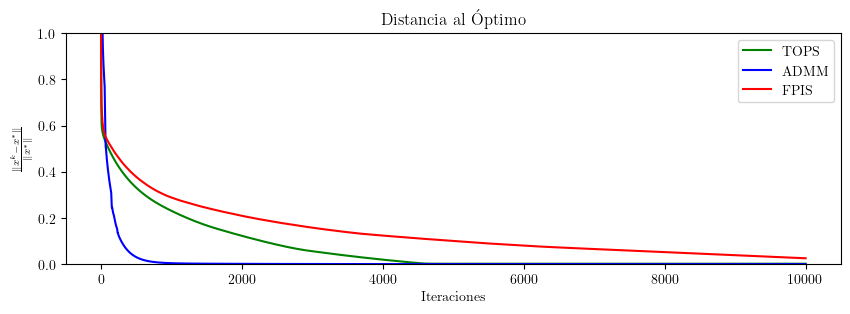

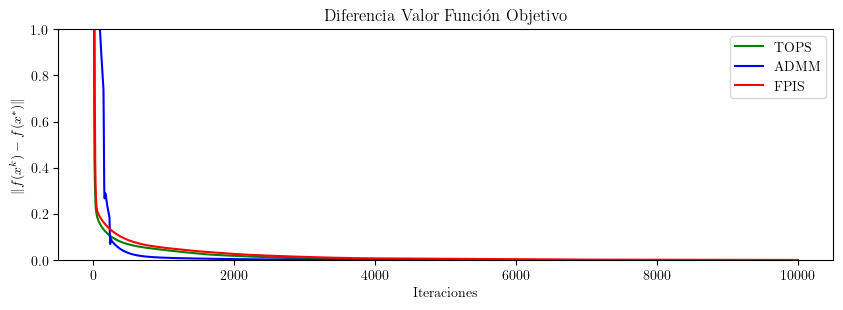

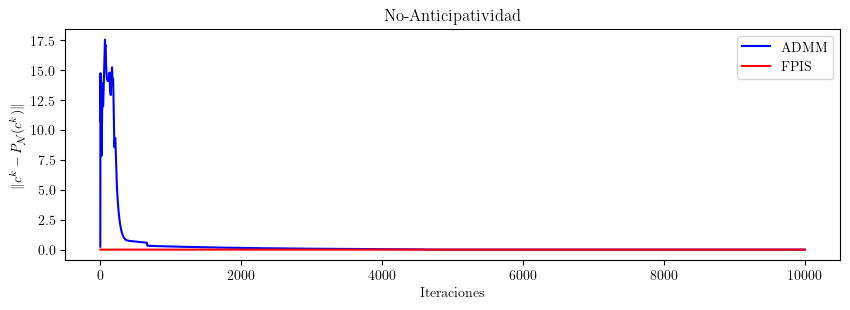

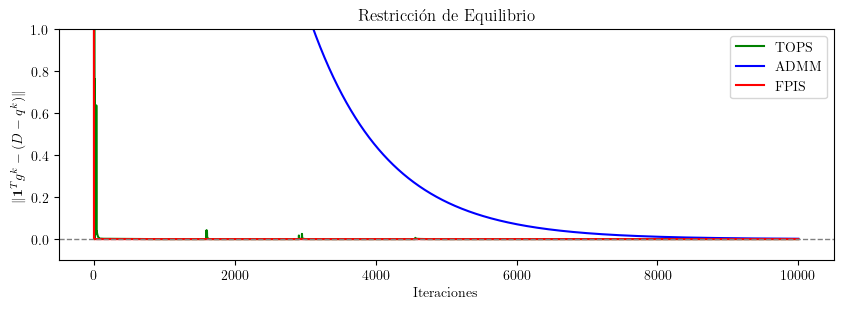

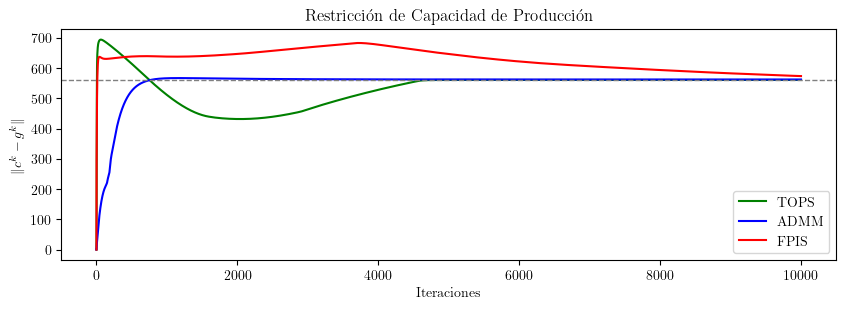

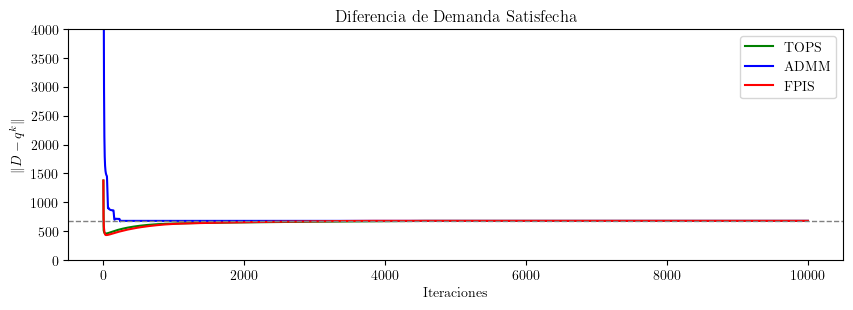

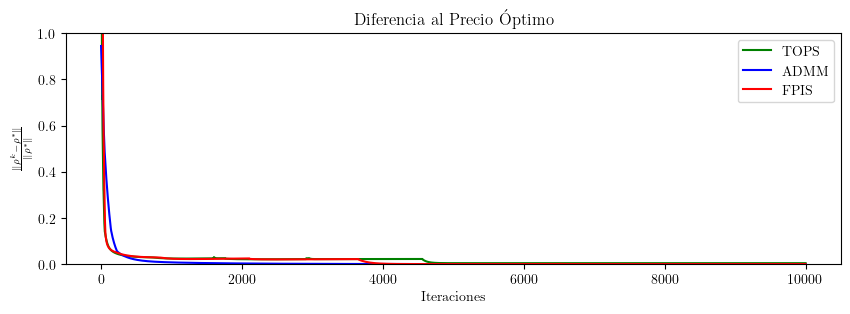

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Crear un rango de iteraciones para las gráficas
k = 0
l = int(max_iters_list / 1) + 1

zero_1 = np.zeros((N,1))
zero_2 = np.zeros((N,M))
zero_3 = np.zeros((1,M))
zeroo = (zero_1, zero_2, zero_3)

# Definir los niveles teóricos según tu solución teórica
nivel_teorico_equilibrio = norm_adjusted((zero_1,zero_2,x2.sum(axis=0) - (D - x3)), zeroo, Sigma)
nivel_teorico_capacidad = norm_adjusted((zero_1,x1 - x2,zero_3), zeroo, Sigma)
nivel_teorico_demanda = norm_adjusted((zero_1,zero_2,D - x3), zeroo, Sigma)

# Variable de sufijo para los nombres de archivo
suffix = "_3"

# Función para configurar y guardar cada gráfico
def configurar_grafico(ax, x_data, y_data, labels, colors, title, y_label, width, height, y_lim=None, nivel_teorico=None):
    for x, y, label, color in zip(x_data, y_data, labels, colors):
        ax.plot(x[k:l], y[k:l], '-', linewidth=1.5, label=label, color=color)
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel('Iteraciones')
    ax.legend()
    if y_lim:
        ax.set_ylim(y_lim)
    if nivel_teorico is not None:
        ax.axhline(y=nivel_teorico, color='gray', linestyle='--', linewidth=1)
    ax.figure.set_figwidth(width)
    ax.figure.set_figheight(height)

# Datos para los gráficos
iter_data = [iter_DY, iter_ADMM, iter_BA]
labels = ['TOPS', 'ADMM', 'FPIS']
colors = ['green', 'blue', 'red']

# Definir la altura y el ancho deseado para cada gráfico
width = 10  # Ajusta esta variable según sea necesario
height = 3  # Ajusta esta variable según sea necesario

# Crear y guardar cada figura individualmente
fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [x_DY_sol, x_ADMM_sol, x_BA_sol], labels, colors, 'Distancia al Óptimo', 
                   r'$\frac{\|x^{k} - x^{*}\|}{\|x^{*}\|}$', width, height, y_lim=(0, 1))
plt.savefig(f'images/caso{suffix}/distancia_al_optimo{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [Fx_DY_sol, Fx_ADMM_sol, Fx_BA_sol], labels, colors, 'Diferencia Valor Función Objetivo', 
                   r'$\|f(x^{k})-f(x^{*})\|$', width, height, y_lim=(0, 1))
plt.savefig(f'images/caso{suffix}/diferencia_valor_funcion_objetivo{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data[1:], [Non_anti_DY, Non_anti_ADMM, Non_anti_BA][1:], labels[1:], colors[1:], 'No-Anticipatividad', 
                   r'$\|c^{k}-P_{\mathcal{N}}(c^{k})\|$', width, height)#, y_lim=(0, 25))
plt.savefig(f'images/caso{suffix}/no_anticipatividad{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [equili_DY_solu, equili_ADMM_solu, equili_BA_solu], labels, colors, 'Restricción de Equilibrio', 
                   r'$\|\textbf{1}^{T}g^{k}-(D-q^{k})\|$', width, height, y_lim=(-0.1, 1.0), nivel_teorico=nivel_teorico_equilibrio)
plt.savefig(f'images/caso{suffix}/restriccion_de_equilibrio{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [capacity_DY_solu, capacity_ADMM_solu, capacity_BA_solu], labels, colors, 'Restricción de Capacidad de Producción', 
                   r'$\|c^{k} - g^{k}\|$', width, height, nivel_teorico=nivel_teorico_capacidad)
plt.savefig(f'images/caso{suffix}/restriccion_de_capacidad_de_produccion{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [demand_DY_sol, demand_ADMM_sol, demand_BA_sol], labels, colors, 'Diferencia de Demanda Satisfecha', 
                   r'$\|D-q^{k}\|$', width, height, y_lim=(0, 4000), nivel_teorico=nivel_teorico_demanda)
plt.savefig(f'images/caso{suffix}/diferencia_de_demanda_satisfecha{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [dual_DY_sol, dual_ADMM_sol, BA_dual_sol], labels, colors, 'Diferencia al Precio Óptimo', 
                   r'$\frac{\|\rho^{k}-\rho^{*}\|}{\|\rho^{*}\|}$', width, height, y_lim=(0, 1))
plt.savefig(f'images/caso{suffix}/diferencia_al_precio_optimo{suffix}.png', bbox_inches='tight')
plt.show()


In [16]:
Times

{'CP': 0.07350301742553711,
 'DY': 1221.2837600708008,
 'BA': 639.2064185142517,
 'ADMM': 590.0728597640991}

In [17]:
iter_DY[-1], x_DY_sol[-1], Fx_DY_sol[-1], Non_anti_DY[-1], equili_DY_solu[-1], capacity_DY_solu[-1], demand_DY_sol[-1], dual_DY_sol[-1]

(9999,
 0.0017463588316155116,
 6.464275022264534e-05,
 0.0,
 1.3737724853769713e-05,
 560.4113616876273,
 678.3377271662825,
 0.004081785799062849)

In [18]:
iter_BA[-1], x_BA_sol[-1], Fx_BA_sol[-1], Non_anti_BA[-1], equili_BA_solu[-1], capacity_BA_solu[-1], demand_BA_sol[-1], BA_dual_sol[-1]

(9999,
 0.025297524525941043,
 0.0008506170720444077,
 0.0,
 1.3738394881800364e-05,
 573.2305208441029,
 679.5783041766642,
 0.00019198954744443415)

In [19]:
iter_ADMM[-1], x_ADMM_sol[-1], Fx_ADMM_sol[-1], Non_anti_ADMM[-1], equili_ADMM_solu[-1], capacity_ADMM_solu[-1], demand_ADMM_sol[-1], dual_ADMM_sol[-1]

(9999,
 6.778335858578146e-07,
 3.1113836785228017e-06,
 1.5293280691890615e-13,
 0.0018299672255976131,
 561.9013253367126,
 679.434344407426,
 1.8575322539374224e-06)

In [20]:
nivel_teorico_equilibrio, nivel_teorico_capacidad, nivel_teorico_demanda

(1.3785159814039763e-05, 561.8996186150616, 679.434344407606)